# Concept of spectroscopy

flat 15초
M77 300초


In [2]:
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table,Column
from datetime import datetime
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.feature import peak_local_max
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from numpy.polynomial.chebyshev import chebfit, chebval
from astropy.modeling.models import Gaussian1D, Chebyshev2D
from astropy.modeling.fitting import LevMarLSQFitter
from matplotlib import gridspec, rcParams, rc
from IPython.display import Image

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

home = os.path.expanduser('~')
home = os.path.join(home,'coding')
wd = os.path.join(home, 'chun2')
subpath = os.path.join(wd, 'calibration')

Biaspath = os.path.join(subpath,'calib*bias.fit')
Biaslist = glob.glob(Biaspath)
Biaslist = sorted(Biaslist)

Darkpath = os.path.join(subpath,'Cali*d*.fit')
Darklist = glob.glob(Darkpath)
Darklist = sorted(Darklist)

Flatpath = os.path.join(subpath,'Flat*.fit')
Flatlist = glob.glob(Flatpath)
Flatlist = sorted(Flatlist)

Comppath = os.path.join(subpath,'Neon*.fit')
Complist = glob.glob(Comppath)
Complist = sorted(Complist)

Objectpath = os.path.join(subpath,'M74*.fit')
Objectlist = glob.glob(Objectpath)
Objectlist = sorted(Objectlist)

Standpath = os.path.join(subpath,'HR8634*.fit')
Standlist = glob.glob(Standpath)
Standlist = sorted(Standlist)

Sciencepath = os.path.join(subpath,'science')

print(Table([Biaslist], names=['Bias']),2*'\n')
print(Table([Darklist], names=['Darklist']),2*'\n')
print(Table([Flatlist], names=['Flatlist']),2*'\n')
print(Table([Complist], names=['Complist']),2*'\n')
print(Table([Objectlist], names=['Objectlist']),2*'\n')
print(Table([Standlist], names=['Standlist']),2*'\n')

                              Bias                             
---------------------------------------------------------------
C:\Users\user\coding\chun2\calibration\calibration-0001bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0002bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0003bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0004bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0005bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0006bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0007bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0008bias.fit
C:\Users\user\coding\chun2\calibration\calibration-0009bias.fit 


                            Darklist                            
----------------------------------------------------------------
  C:\Users\user\coding\chun2\calibration\calibration-0001dk1.fit
 C:\Users\user\coding\chun2\calibration\calibration-0001dk15.fit
  C:\Users\user\coding\chun2\cali

# 1. Preprocessing  (i.e., Bias subtraction, Dark subtraction, Flat fielding)
## 1.1 Making master bias

Before making master bias, we have to check whethere there is a peculiar bias image.


In [2]:
#Checking the bias image

Name = []
Mean = []
Min = []
Max = []
Std = []

for i in range(len(Biaslist)):
    hdul = fits.open(Biaslist[i])
    data = hdul[0].data
    data = np.array(data).astype('float64')  #Change datatype from uint16 to float64
    mean = np.mean(data)
    minimum = np.min(data)
    maximum = np.max(data)
    stdev = np.std(data)
    print(Biaslist[i],mean,minimum,maximum)
    
    Name.append(Biaslist[i].split('/')[-1])
    Mean.append("%.2f" %mean )
    Min.append("%.2f"%minimum)
    Max.append("{0:.2f}".format(maximum))
    Std.append('{:.2f}'.format(stdev))
    
table = Table([Name,Mean,Min,Max,Std],
              names=['Filename','Mean','Min','Max','Std'])    
print(table)    
    


C:\Users\coding\chun2\mystar\calibration-0001bias.fit 153.3765104482132 110.0 201.0
C:\Users\coding\chun2\mystar\calibration-0002bias.fit 153.43022410660205 112.0 203.0
C:\Users\coding\chun2\mystar\calibration-0003bias.fit 153.44856904906118 117.0 192.0
C:\Users\coding\chun2\mystar\calibration-0004bias.fit 153.4095074954573 121.0 192.0
C:\Users\coding\chun2\mystar\calibration-0005bias.fit 153.4556878407026 113.0 193.0
C:\Users\coding\chun2\mystar\calibration-0006bias.fit 153.42400249848578 114.0 205.0
C:\Users\coding\chun2\mystar\calibration-0007bias.fit 153.36638779527559 114.0 195.0
C:\Users\coding\chun2\mystar\calibration-0008bias.fit 153.3892830102968 117.0 195.0
C:\Users\coding\chun2\mystar\calibration-0009bias.fit 153.43673909751666 119.0 200.0
                       Filename                        Mean   Min    Max   Std 
----------------------------------------------------- ------ ------ ------ ----
C:\Users\coding\chun2\mystar\calibration-0001bias.fit 153.38 110.00 201.00 5.06

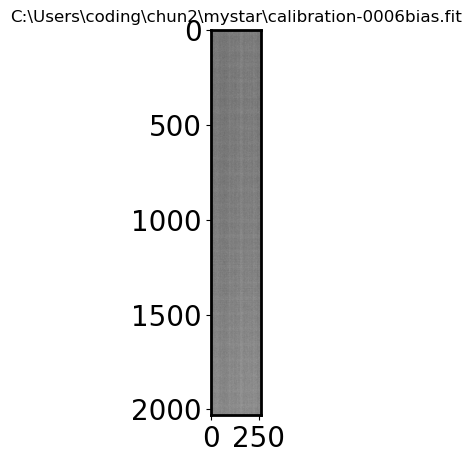

In [3]:
#Plot the Sample image of bias image
File = Biaslist[5]
sample_hdul = fits.open(File)
sample_data = sample_hdul[0].data

fig,ax = plt.subplots(1,1,figsize=(13,5))
vmin = np.mean(sample_data) - 40
vmax = np.mean(sample_data) + 40
im = ax.imshow(sample_data,
                  cmap='gray',vmin=vmin,vmax=vmax)
ax.set_title(File,fontsize=12)
plt.show()

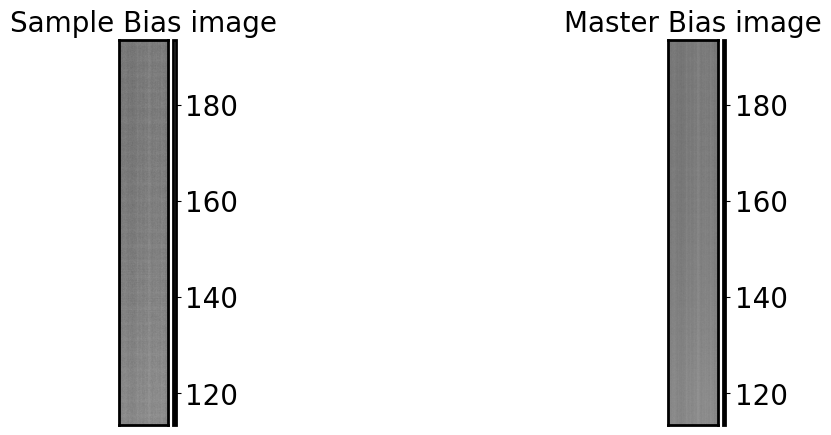

In [4]:
#Median combine Bias image    
    
Master_bias = []
for i in range(0,len(Biaslist)):
    hdul = fits.open(Biaslist[i])
    bias_data = hdul[0].data
    bias_data = np.array(bias_data).astype('float64')
    Master_bias.append(bias_data)
MASTER_Bias = np.median(Master_bias,axis=0)


#Let's make Master bias image fits file

#Making header part
bias_header = hdul[0].header
bias_header['OBJECT'] = 'Bias'
bias_header['COMMENT'] = '{0} bias images are median combined on '.format(len(Biaslist))\
+ datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')


SAVE_bias = os.path.join(subpath,'Master_Bias.fits' )
fits.writeto(SAVE_bias,MASTER_Bias,header = bias_header,overwrite=True)


#Plot Master bias 
fig,ax = plt.subplots(1,2,figsize=(13,5))
im = ax[0].imshow(sample_data,
                  cmap='gray',
                  vmin=vmin,vmax=vmax)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Sample Bias image',fontsize=20)
ax[0].tick_params(labelbottom=False,labelleft=False,
                 bottom=False,left=False)
plt.colorbar(im,cax=cax)

im1 = ax[1].imshow(MASTER_Bias,
                   cmap='gray',
                   vmin=vmin,vmax=vmax)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right",size='5%',pad=0.05)
ax[1].set_title('Master Bias image',fontsize=20)
ax[1].tick_params(labelbottom=False,labelleft=False,
                  bottom=False,left=False)
plt.colorbar(im1,cax=cax)
plt.show()

## 1.2Derive Readout Noise (RN)

In [5]:
#Let's derive RN

#Bring Bias1 data
hdul1 = fits.open(Biaslist[0]) 
bias1 = hdul1[0].data            
bias1 = np.array(bias1).astype('float64')

#Bring Bias2 data
hdul2 = fits.open(Biaslist[1])
bias2 = hdul2[0].data
bias2 = np.array(bias2).astype('float64')

#derive the differential image
dbias = bias2 - bias1

#Bring Gain 
gain = 1.5 #e/ADU

#Calculate RN
RN = np.std(dbias)*gain / np.sqrt(2)
print('Readout Noise is {0:.2f}'.format(RN))



#Do it for all bias data
Name = []
RN = []
for i in range(len(Biaslist)-1):
    hdul1 = fits.open(Biaslist[i])
    bias1 = hdul1[0].data
    bias1 = np.array(bias1).astype('float64')
    hdul2 = fits.open(Biaslist[i+1])
    bias2 = hdul2[0].data
    bias2 = np.array(bias2).astype('float64')
    dbias = bias2 - bias1

    print(i,'st',np.std(dbias)*gain / np.sqrt(2))
    RN.append(np.std(dbias)*gain / np.sqrt(2))
print(np.mean(RN))    
RN = np.mean(RN)

Readout Noise is 6.30
0 st 6.301053810779526
1 st 6.28631319017631
2 st 6.276447034590891
3 st 6.2946437729489695
4 st 6.309530096646811
5 st 6.321778084541075
6 st 6.29688312839261
7 st 6.29726171430349
6.2979888540474604


## 1.3 Making Master Dark
Master dark = median combine([Dark image1 - master bias, Dark image2 - master bias, Dark image3 - master bias,...])

In [6]:
#Checking what exposure time is taken
exptime = []

for i in range(len(Darklist)):
    hdul = fits.open(Darklist[i])[0]
    header = hdul.header
    exp = header['EXPTIME']
    exptime.append(exp)
exptime = set(exptime)    
exptime = sorted(exptime)
print(exptime)

[1.0, 2.0, 5.0, 15.0, 30.0, 300.0, 600.0, 900.0]


In [7]:
#Bring master bias
Mbias = fits.open(SAVE_bias)[0].data
Mbias = np.array(Mbias).astype('float64')

#Making master dark image for each exposure time
for exp_i in exptime:
    Master_dark = []
    for i in range(len(Darklist)):
        hdul = fits.open(Darklist[i])[0]
        header = hdul.header
        exp = header['EXPTIME']

        if exp == exp_i:
            data = hdul.data
            data = np.array(data).astype('float64')
            bdata = data - Mbias #Bias subtracting
            Master_dark.append(bdata)
            
    MASTER_dark = np.median(Master_dark,axis=0)
    header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    header["COMMENT"]='{0} dark images are median combined on '.format(len(Master_dark))\
    + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    SAVE_dark = os.path.join(subpath,'Master_Dark_'+str(exp_i)+'s.fits')
    fits.writeto(SAVE_dark,MASTER_dark,header = header,overwrite=True)
    print(exp_i ,'s is done!', SAVE_dark,' is made.')

1.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_1.0s.fits  is made.
2.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_2.0s.fits  is made.
5.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_5.0s.fits  is made.
15.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_15.0s.fits  is made.
30.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_30.0s.fits  is made.
300.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_300.0s.fits  is made.
600.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_600.0s.fits  is made.
900.0 s is done! C:\Users\coding\chun2\mystar\Master_Dark_900.0s.fits  is made.


## 1.4 Making Master Flat

### 1.4-1 Checking whether Flat image is shifted or not
The flat image could shift little by little depending on where the telescope is pointing. Because different images may have different flats to use, it can be dangerous to median combine all the flats image taken overnight. Let's do **quick** and **rough** check whether there is flat shift.

By using local peak location, I will check whether there was the flat shift or not. 

In [8]:
Flatlist

['C:\\Users\\coding\\chun2\\mystar\\Flat-0001.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0002.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0003.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0004.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0005.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0006.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0007.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0008.fit',
 'C:\\Users\\coding\\chun2\\mystar\\Flat-0009.fit']

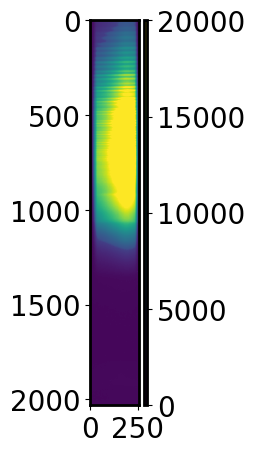

In [9]:
#Plot the flat image
fig,ax = plt.subplots(1,1,figsize=(5,5))

hdul = fits.open(Flatlist[4])[0]
data = hdul.data
im = ax.imshow(data,vmin=0, vmax = 20000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)
plt.show()

(2032, 260)
(2032, 260)
(2032, 260)
(2032, 260)
(2032, 260)
(2032, 260)
(2032, 260)
(2032, 260)
(2032, 260)


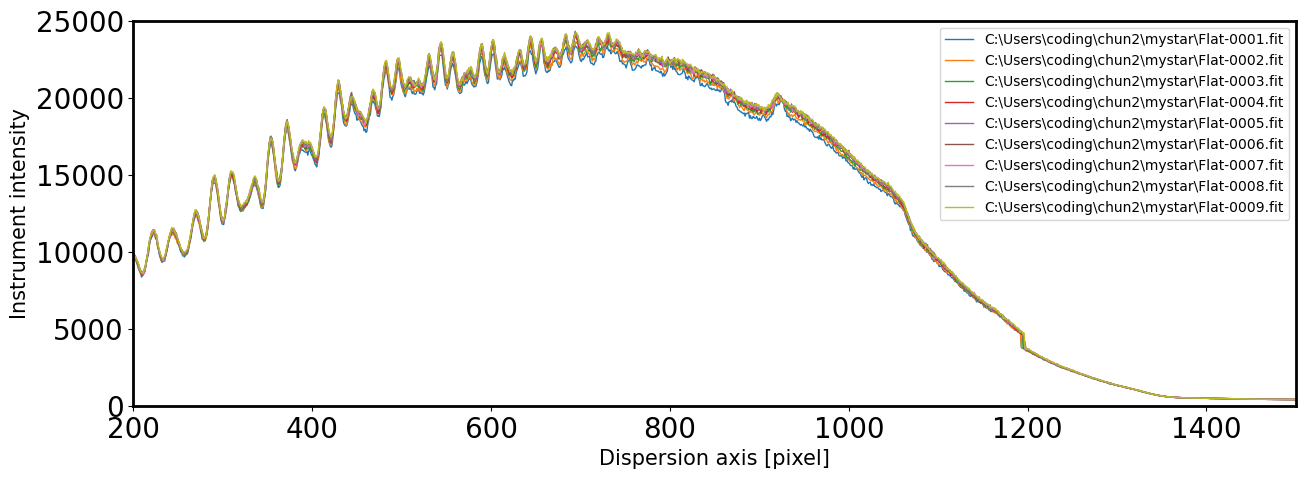

In [10]:
#Do bias and dark subtraction
Mbias = fits.open(SAVE_bias)[0].data
Mbias = np.array(Mbias).astype('float64')


fig,ax = plt.subplots(1,1,figsize=(15,5))

for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    #print(hdul)
    data = hdul.data
    print(data.shape)
    flat = np.median(data[:,50:250],axis=1) # flat은 0~260으로 잘려있으니, 50~250으로 잘라주자
    
    ax.plot(flat,label=Flatlist[i].split('/')[-1],lw=1)
    ax.set_xlim(200,1500)
    ax.legend(fontsize=10)
    ax.set_ylim(0,25000)
    ax.set_ylabel('Instrument intensity')
    ax.set_xlabel('Dispersion axis [pixel]')
plt.show()

####  Finding local peak

C:\Users\coding\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


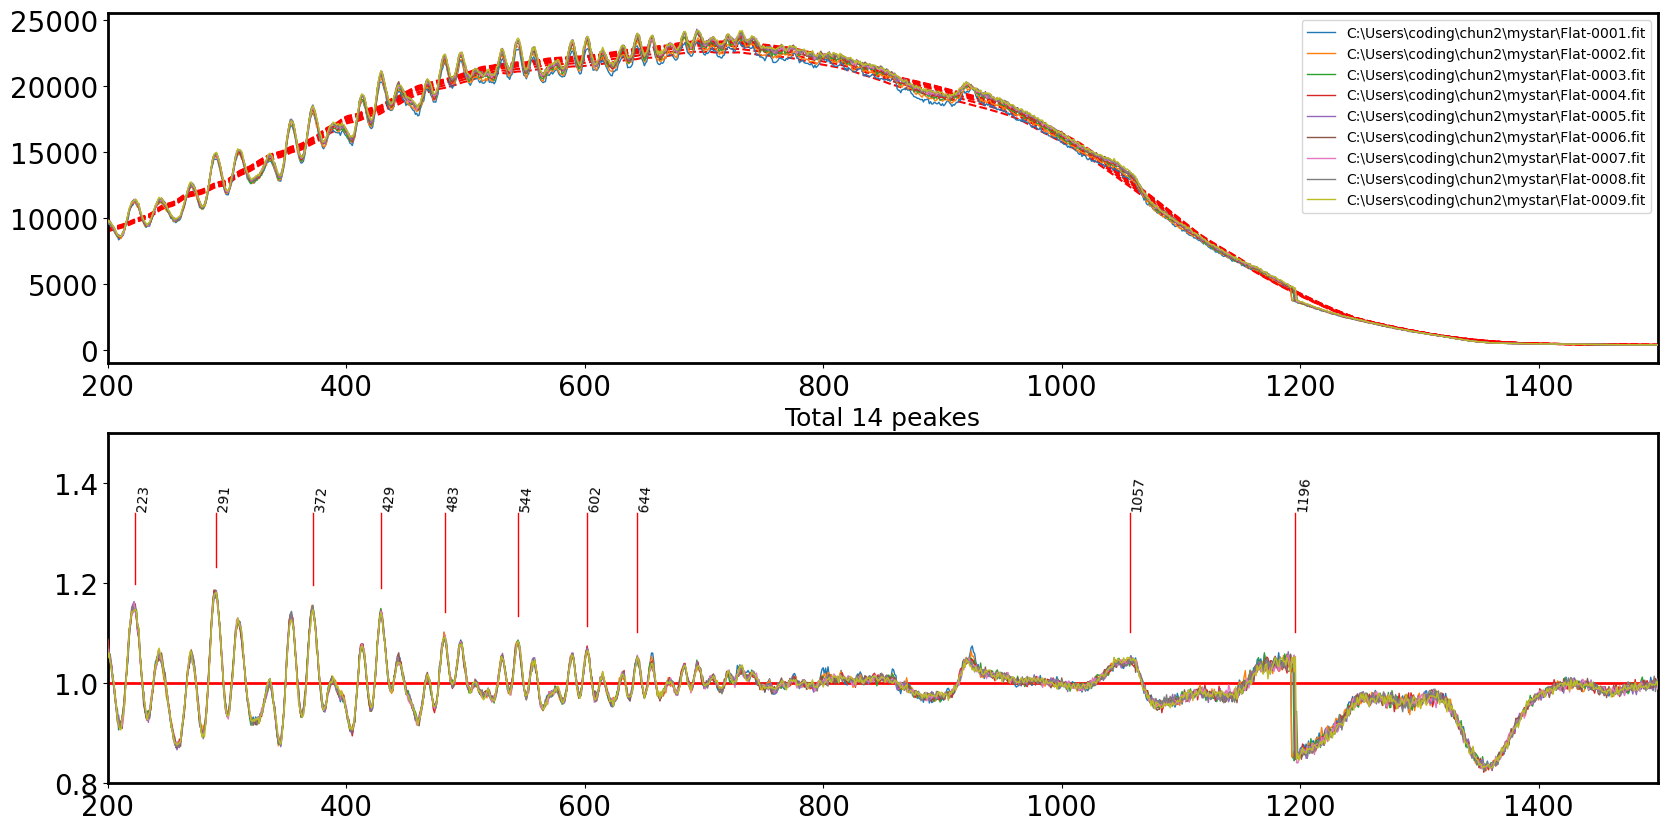

In [11]:
fig,ax = plt.subplots(2,1,figsize=(20,10))

def smooth(y,width):    # Moving box averaging
    box = np.ones(width)/width
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth   

Coor_shift = []
for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    data = hdul.data
    flat = np.median(data[:,50:250],axis=1) # 관측조건에 따라 바꿔줘야함!
    
    ax[0].plot(flat,label=Flatlist[i].split('/')[-1],lw=1,zorder=20)
    ax[0].set_xlim(200,1500)
    ax[0].legend(fontsize=10)
    
    
    sflat = smooth(flat,100)
    nor_flat = flat/sflat # flat field after the large-scale curve is divied
    ax[0].plot(sflat,color='r',ls='--')
    
    ax[1].plot(nor_flat,lw=1,zorder=15)
    ax[1].set_xlim(200,1500)
    ax[1].set_ylim(0.8,1.5)
    ax[1].axhline(1,color='r',lw=1)    
    
    coordinates = peak_local_max(nor_flat,min_distance=20,threshold_abs=1.05) 
    Coor_shift.append(coordinates)
    

    
for i in coordinates:
    ax[1].annotate(i[0],(i,1.35),
                  fontsize=10,rotation=85)
    ax[1].plot([i[0],i[0]],
            [nor_flat[i]+0.05,1.34],
            color='r',lw=1)
ax[1].set_title('Total {0} peakes'.format(int(len(coordinates))))       
plt.show()

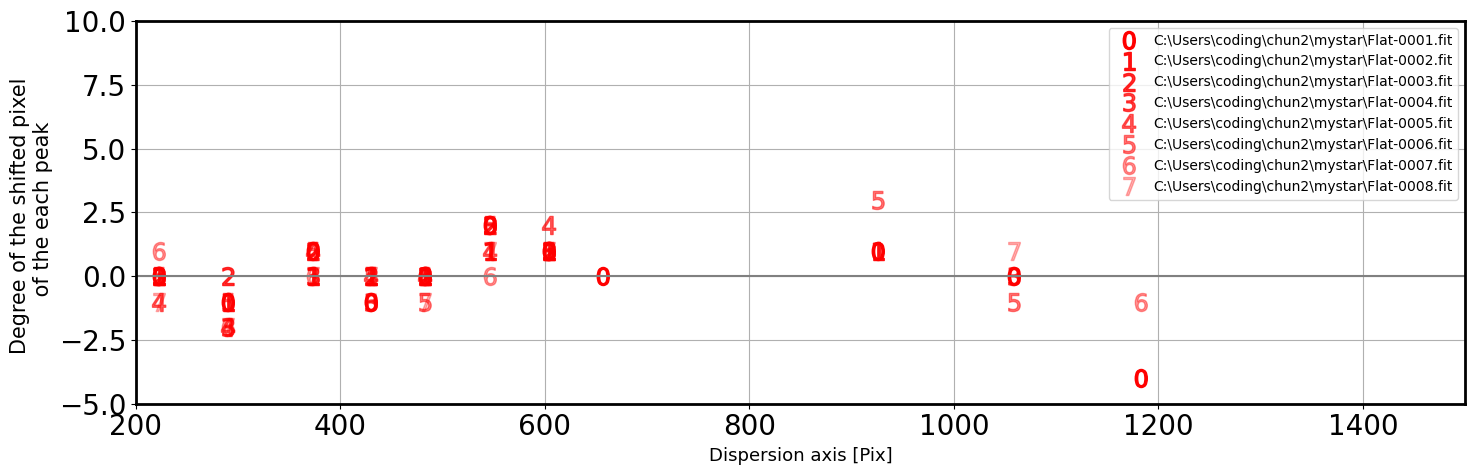

In [12]:
fig,ax = plt.subplots(1,1,figsize=(15,5))


reference_coor = sorted(Coor_shift[0])   
for i in range(len(Coor_shift)-1):
    coor_i = Coor_shift[i+1]
    x_shift = []
    y_shift = []
    for k in range(len(reference_coor)):
        for t in range(len(coor_i)):
            if abs(reference_coor[k]-coor_i[t]) <5 :
                y_shift.append(reference_coor[k]-coor_i[t])
                x_shift.append(reference_coor[k])
    ax.plot(x_shift,y_shift,ls='',marker='${0}$'.format(int(i)),
               markersize=13,color='r',alpha=1-i*0.1,label=Flatlist[i])  
ax.set_xlabel('Dispersion axis [Pix]',fontsize=13)    
ax.set_xlim(200,1500)    
ax.set_ylim(-5,10)
ax.set_ylabel('Degree of the shifted pixel \n of the each peak')
ax.axhline(0,color='gray')
ax.grid()
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

### 1.4-2 Median combine flat image to make Master Flat

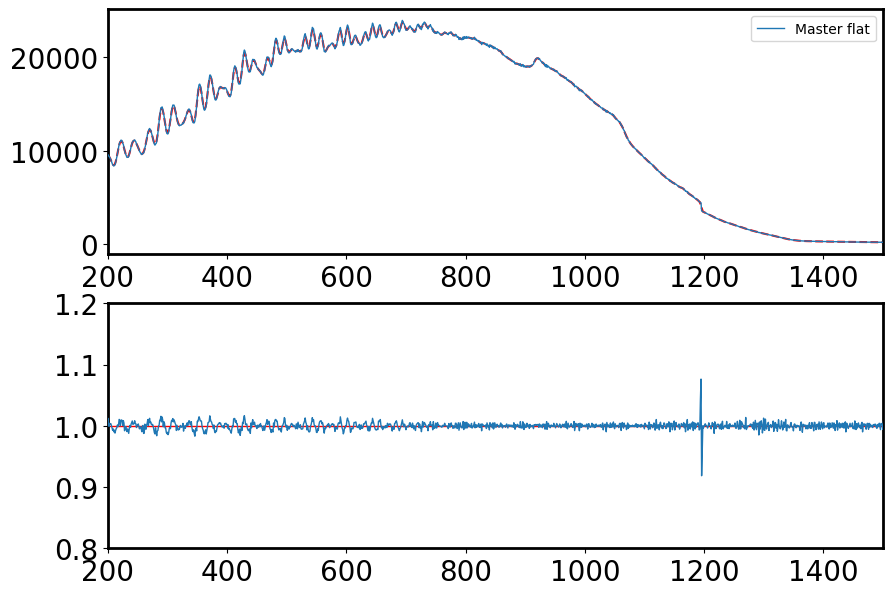

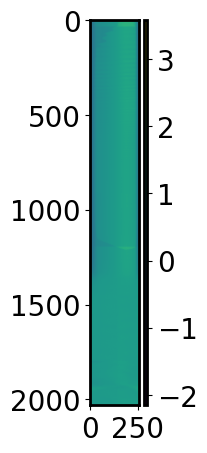

In [13]:
#Bring Master bias & Dark

biasfile = os.path.join(subpath,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

darkfile = os.path.join(subpath,'Master_Dark_15.0s.fits') # flat을 15초를 찍었으니 dark도 15초 가져오자
Mdark = fits.open(darkfile)[0].data 
Mdark = np.array(Mdark).astype('float64')


#Make master Flat image
Master_flat = []
for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    header = hdul.header
    
    data = hdul.data
    data = np.array(data).astype('float64')
    
    bdata = data - Mbias    
    dbdata = bdata - Mdark
    Master_flat.append(dbdata)
    
MASTER_flat = np.median(Master_flat,axis=0)
header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
header["COMMENT"]='{0} dark images are median combined on '.format(len(Master_dark))\
+ datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')+ 'with '+' Master_Dark_'+str(exp)+'s.fits'




flat = np.median(MASTER_flat[:,50:250],axis=1) # master flat은 0~260, 우리가 쓸 건 50~250
fig,ax=plt.subplots(2,1,figsize=(10,7))
ax[0].plot(flat,label='Master flat',lw=1,zorder=20)
ax[0].set_xlim(200,1500)
ax[0].legend(fontsize=10)


sflat = smooth(flat,5)
nor_flat = flat/sflat
ax[0].plot(sflat,color='r',ls='--')

ax[1].plot(nor_flat,lw=1,zorder=15)
ax[1].set_xlim(200,1500)
ax[1].set_ylim(0.8,1.2)
ax[1].axhline(1,color='r',lw=1)    

nor_flat2d = []
for i in range(len(MASTER_flat[0])):
    nor_flat2d.append(MASTER_flat[:,i] / sflat)
    
nor_flat2d = np.array(nor_flat2d).T    
header['COMMENT'] = 'Normalized' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')

SAVE_flat = os.path.join(subpath,'Master_Flat.fits')
fits.writeto(SAVE_flat,nor_flat2d,header = header,overwrite=True)



fig,ax = plt.subplots(1,1,figsize=(5,5))
im=ax.imshow(nor_flat2d)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)
plt.show()

## 1.5 Master Calibration image
### Check wavelength Calibration image shift

I will check the wavelength calibration image shift with the same manner done for flat image.

# Neon_5s

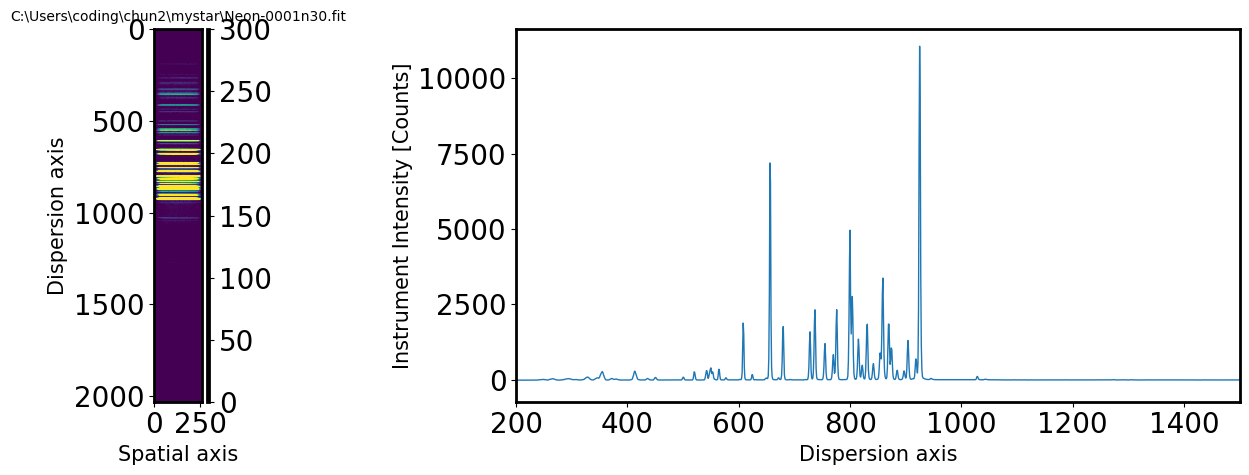

In [14]:
#Bring Master bias & Dark

biasfile = os.path.join(subpath,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

darkfile = os.path.join(subpath,'Master_Dark_5.0s.fits') # 5초짜리 네온이므로
Mdark5 = fits.open(darkfile)[0].data 
Mdark5 = np.array(Mdark).astype('float64')


#Plot the Comparison image
fig,ax = plt.subplots(1,2,figsize=(15,5))

hdul = fits.open(Complist[1])[0]
data = hdul.data
data = np.array(data).astype('float64')
data = data - Mbias - Mdark5

im = ax[0].imshow(data,vmin=0, vmax = 300)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)
ax[0].set_title(Complist[0],fontsize=10)
ax[0].set_xlabel('Spatial axis')
ax[0].set_ylabel('Dispersion axis')



#Cut the spectrum along the dispersion direction
ComSpec = np.median(data[:,50:250],axis=1)
ax[1].plot(ComSpec,lw=1)
ax[1].set_xlim(200,1500)
ax[1].set_xlabel('Dispersion axis')
ax[1].set_ylabel('Instrument Intensity [Counts]')
    
plt.tight_layout()
plt.show()

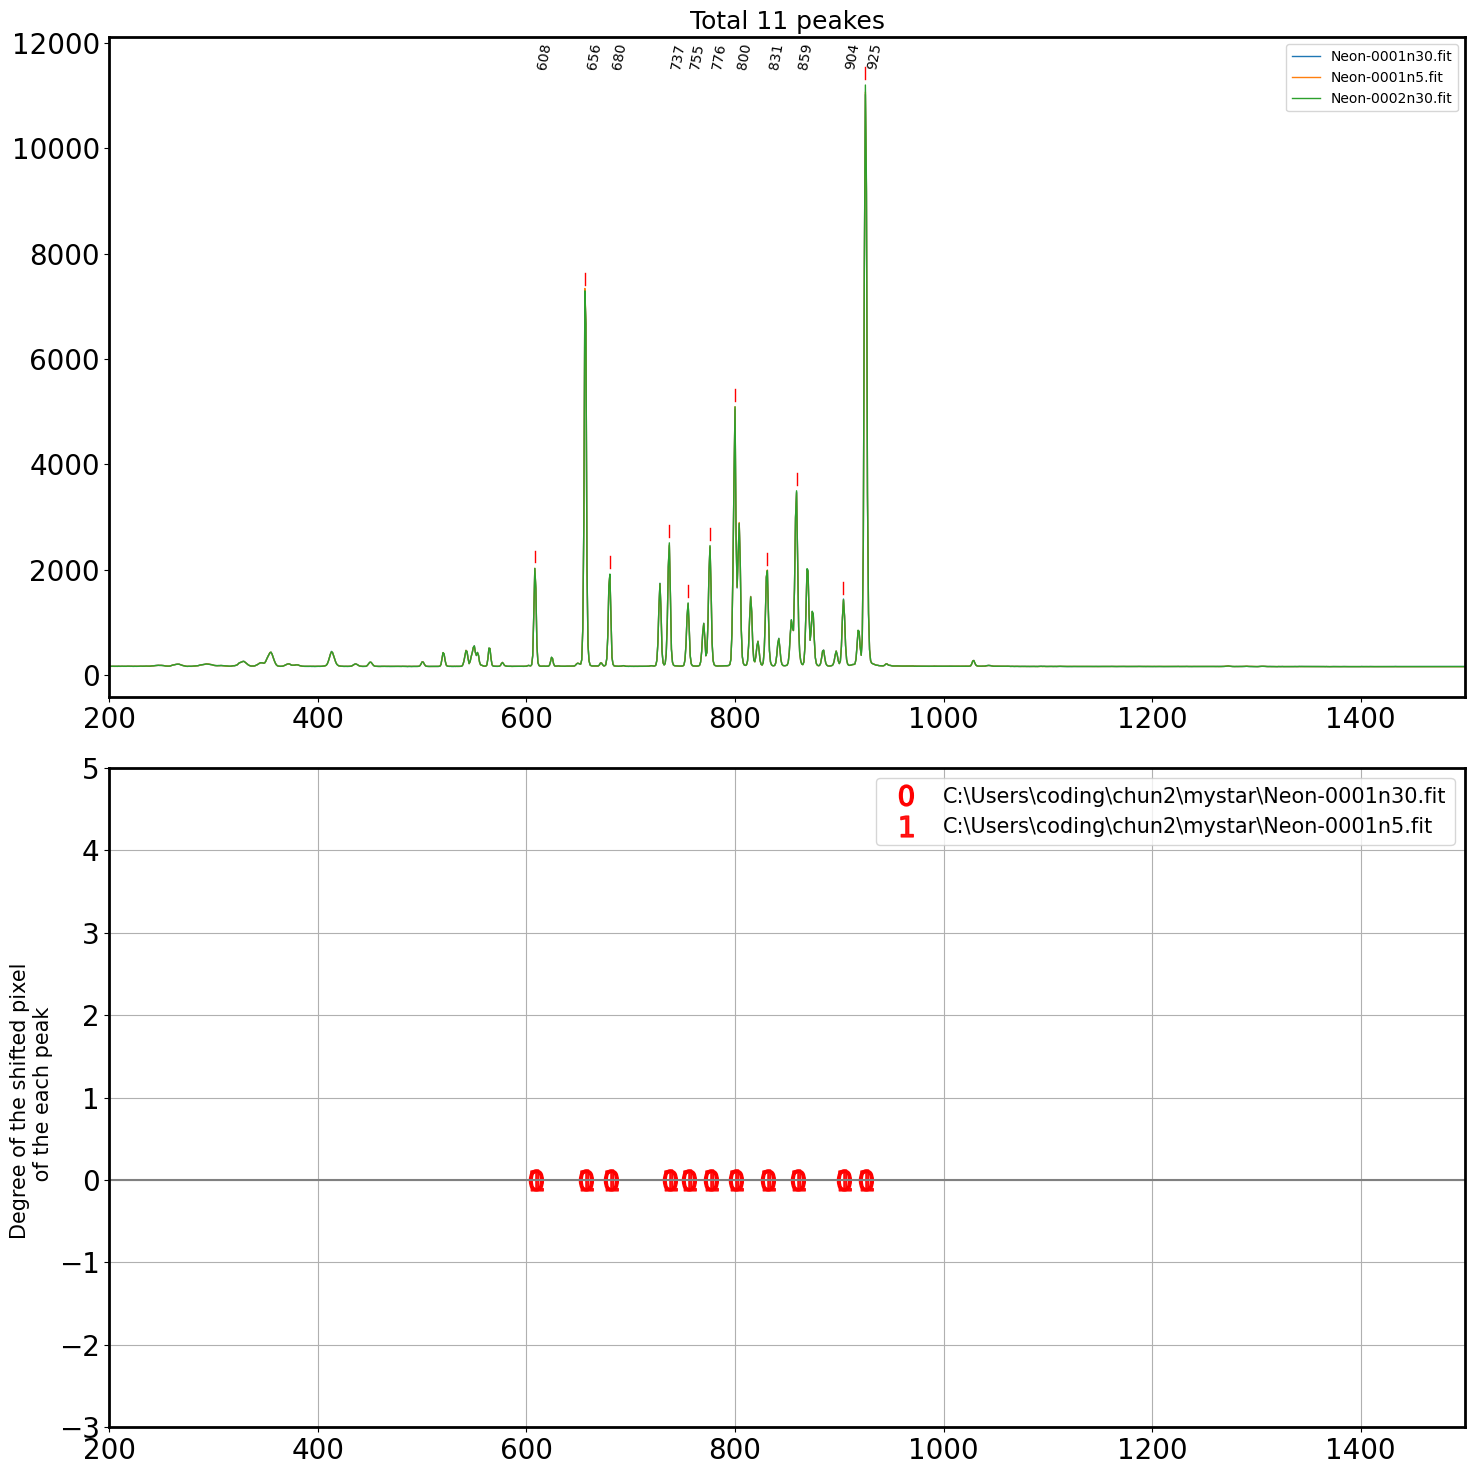

In [15]:
#Find the local peak for each image

fig,ax = plt.subplots(2,1,figsize=(15,15))
Coor_shift = []
for i in range(3):
    hdul = fits.open(Complist[2*i+1])[0]
    data = hdul.data
    data = np.array(data).astype('float64')
    neon = np.median(data[:,:],axis=1)
    
    ax[0].plot(neon,label=Complist[i].split('\\')[-1],lw=1)
    ax[0].set_xlim(200,1500)
    ax[0].legend(fontsize=10)
    
    
    x = np.arange(0,len(neon))
    coordinates = peak_local_max(neon, min_distance=10, 
                                 threshold_abs= max(neon)*0.05)
    
    Coor_shift.append(coordinates)
    
    

ax[0].set_title('Total {0} peakes'.format(int(len(coordinates))))

for i in coordinates:
    ax[0].annotate(i[0],(i,max(neon)+ max(neon)*0.03),
                  fontsize=10,rotation=80)
    ax[0].plot([i,i],
            [neon[i] + max(neon)*0.01, neon[i] + max(neon)*0.03],
            color='r',lw=1)
    
    
reference_coor = sorted(Coor_shift[0])    
     
for i in range(len(Coor_shift)-1):
    coor_i = Coor_shift[i+1]
    x_shift = []
    y_shift = []
    for k in range(len(reference_coor)):
        for t in range(len(coor_i)):
            if abs(reference_coor[k]-coor_i[t]) <5 :
                y_shift.append(reference_coor[k]-coor_i[t])
                x_shift.append(reference_coor[k])
    ax[1].plot(x_shift,y_shift,ls='',marker='${0}$'.format(int(i)),
               markersize=15,color='r',alpha=1-i*0.1, label=Complist[i])    
ax[1].set_xlim(200,1500)    
ax[1].set_ylim(-3,5)
ax[1].set_ylabel('Degree of the shifted pixel \n of the each peak')
ax[1].axhline(0,color='gray')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

### Median combine Comparison Lamp image

In [16]:
Master_Comp = []
for i in range(3):
    hdul = fits.open(Complist[2*i+1])[0]
    header = hdul.header    
    data = hdul.data
    data = data - Mbias - Mdark

    Master_Comp.append(data)
    
MASTER_Comp = np.median(Master_Comp,axis=0)
SAVE_comp = os.path.join(subpath,'Master_Neon_5.0s.fits')
fits.writeto(SAVE_comp,MASTER_Comp,header = header,overwrite=True)


# neon_30s

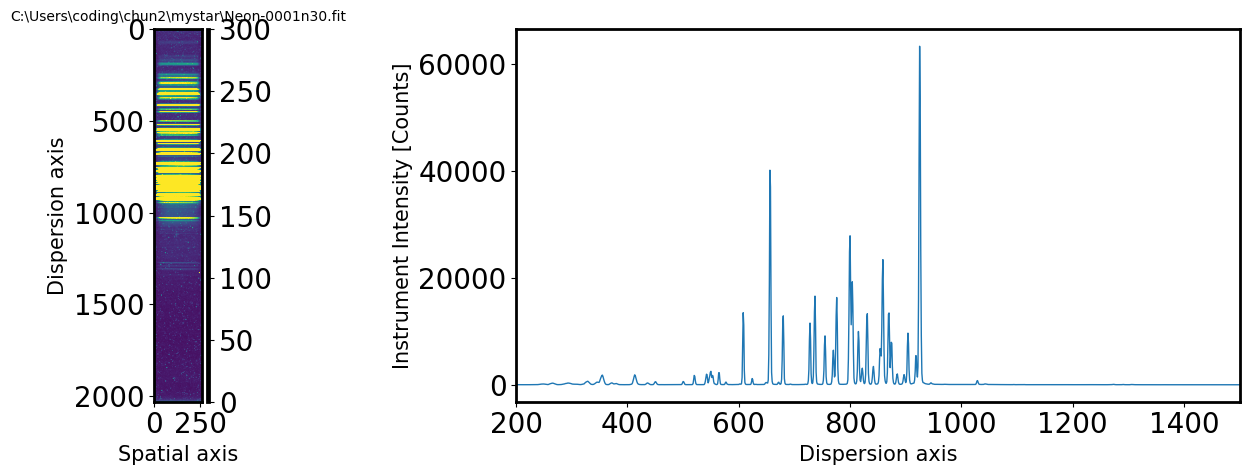

In [17]:
#Bring Master bias & Dark

biasfile = os.path.join(subpath,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

darkfile = os.path.join(subpath,'Master_Dark_30.0s.fits') # 5초짜리 네온이므로
Mdark5 = fits.open(darkfile)[0].data 
Mdark5 = np.array(Mdark).astype('float64')


#Plot the Comparison image
fig,ax = plt.subplots(1,2,figsize=(15,5))

hdul = fits.open(Complist[0])[0]
data = hdul.data
data = np.array(data).astype('float64')
data = data - Mbias - Mdark5

im = ax[0].imshow(data,vmin=0, vmax = 300)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)
ax[0].set_title(Complist[0],fontsize=10)
ax[0].set_xlabel('Spatial axis')
ax[0].set_ylabel('Dispersion axis')



#Cut the spectrum along the dispersion direction
ComSpec = np.median(data[:,50:250],axis=1)
ax[1].plot(ComSpec,lw=1)
ax[1].set_xlim(200,1500)
ax[1].set_xlabel('Dispersion axis')
ax[1].set_ylabel('Instrument Intensity [Counts]')
    
plt.tight_layout()
plt.show()

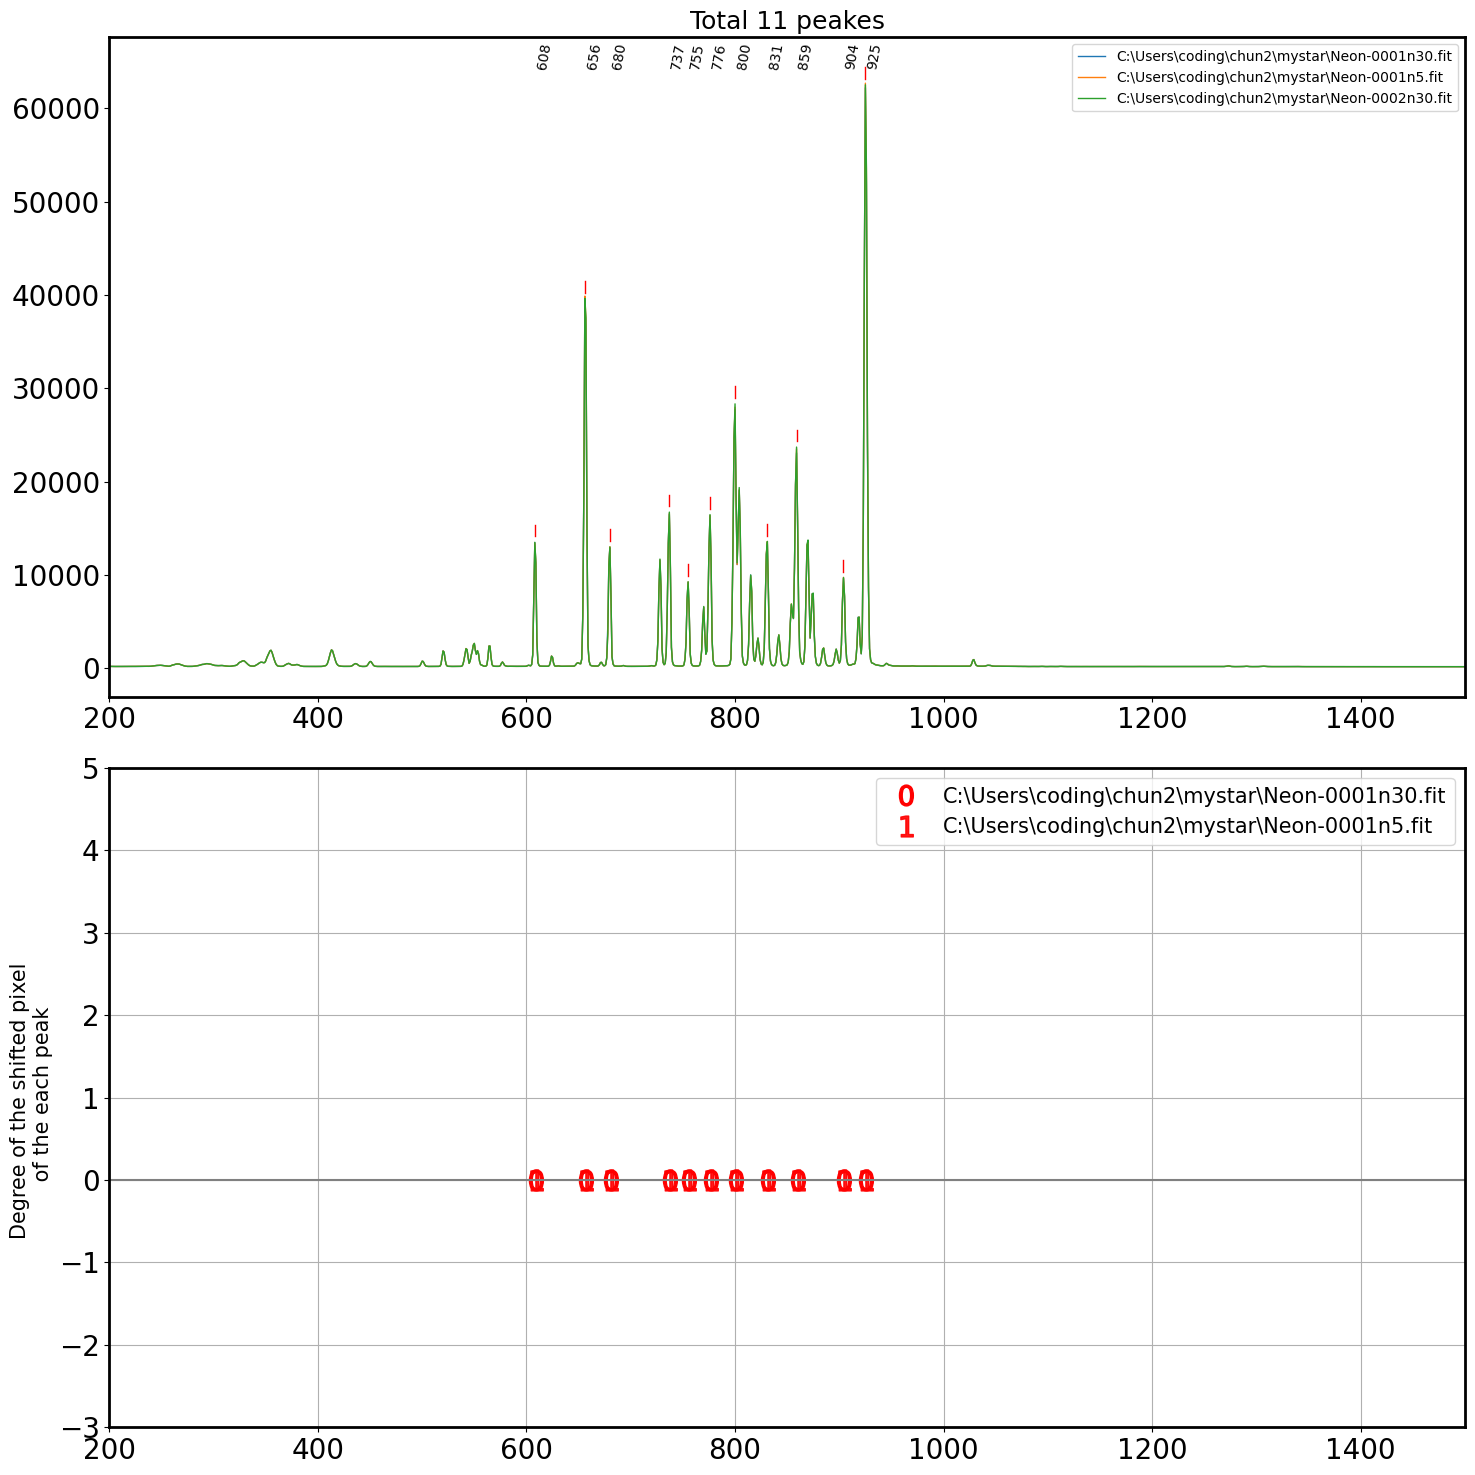

In [18]:
#Find the local peak for each image

fig,ax = plt.subplots(2,1,figsize=(15,15))
Coor_shift = []
for i in range(3):
    hdul = fits.open(Complist[2*i])[0]
    data = hdul.data
    data = np.array(data).astype('float64')
    neon = np.median(data[:,:],axis=1)
    
    ax[0].plot(neon,label=Complist[i].split('/')[-1],lw=1)
    ax[0].set_xlim(200,1500)
    ax[0].legend(fontsize=10)
    
    
    x = np.arange(0,len(neon))
    coordinates = peak_local_max(neon, min_distance=10, 
                                 threshold_abs= max(neon)*0.05)
    
    Coor_shift.append(coordinates)
    
    

ax[0].set_title('Total {0} peakes'.format(int(len(coordinates))))

for i in coordinates:
    ax[0].annotate(i[0],(i,max(neon)+ max(neon)*0.03),
                  fontsize=10,rotation=80)
    ax[0].plot([i,i],
            [neon[i] + max(neon)*0.01, neon[i] + max(neon)*0.03],
            color='r',lw=1)
    
    
reference_coor = sorted(Coor_shift[0])    
     
for i in range(len(Coor_shift)-1):
    coor_i = Coor_shift[i+1]
    x_shift = []
    y_shift = []
    for k in range(len(reference_coor)):
        for t in range(len(coor_i)):
            if abs(reference_coor[k]-coor_i[t]) <5 :
                y_shift.append(reference_coor[k]-coor_i[t])
                x_shift.append(reference_coor[k])
    ax[1].plot(x_shift,y_shift,ls='',marker='${0}$'.format(int(i)),
               markersize=15,color='r',alpha=1-i*0.1, label=Complist[i])    
ax[1].set_xlim(200,1500)    
ax[1].set_ylim(-3,5)
ax[1].set_ylabel('Degree of the shifted pixel \n of the each peak')
ax[1].axhline(0,color='gray')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [19]:
Master_Comp = []
for i in range(3):
    hdul = fits.open(Complist[2*i])[0]
    header = hdul.header    
    data = hdul.data
    data = data - Mbias - Mdark

    Master_Comp.append(data)
    
MASTER_Comp = np.median(Master_Comp,axis=0)
SAVE_comp = os.path.join(subpath,'Master_Neon_30.0s.fits')
fits.writeto(SAVE_comp,MASTER_Comp,header = header,overwrite=True)


## 1.6 Bias subtraction & Dark subtraction (Pre-Processing)

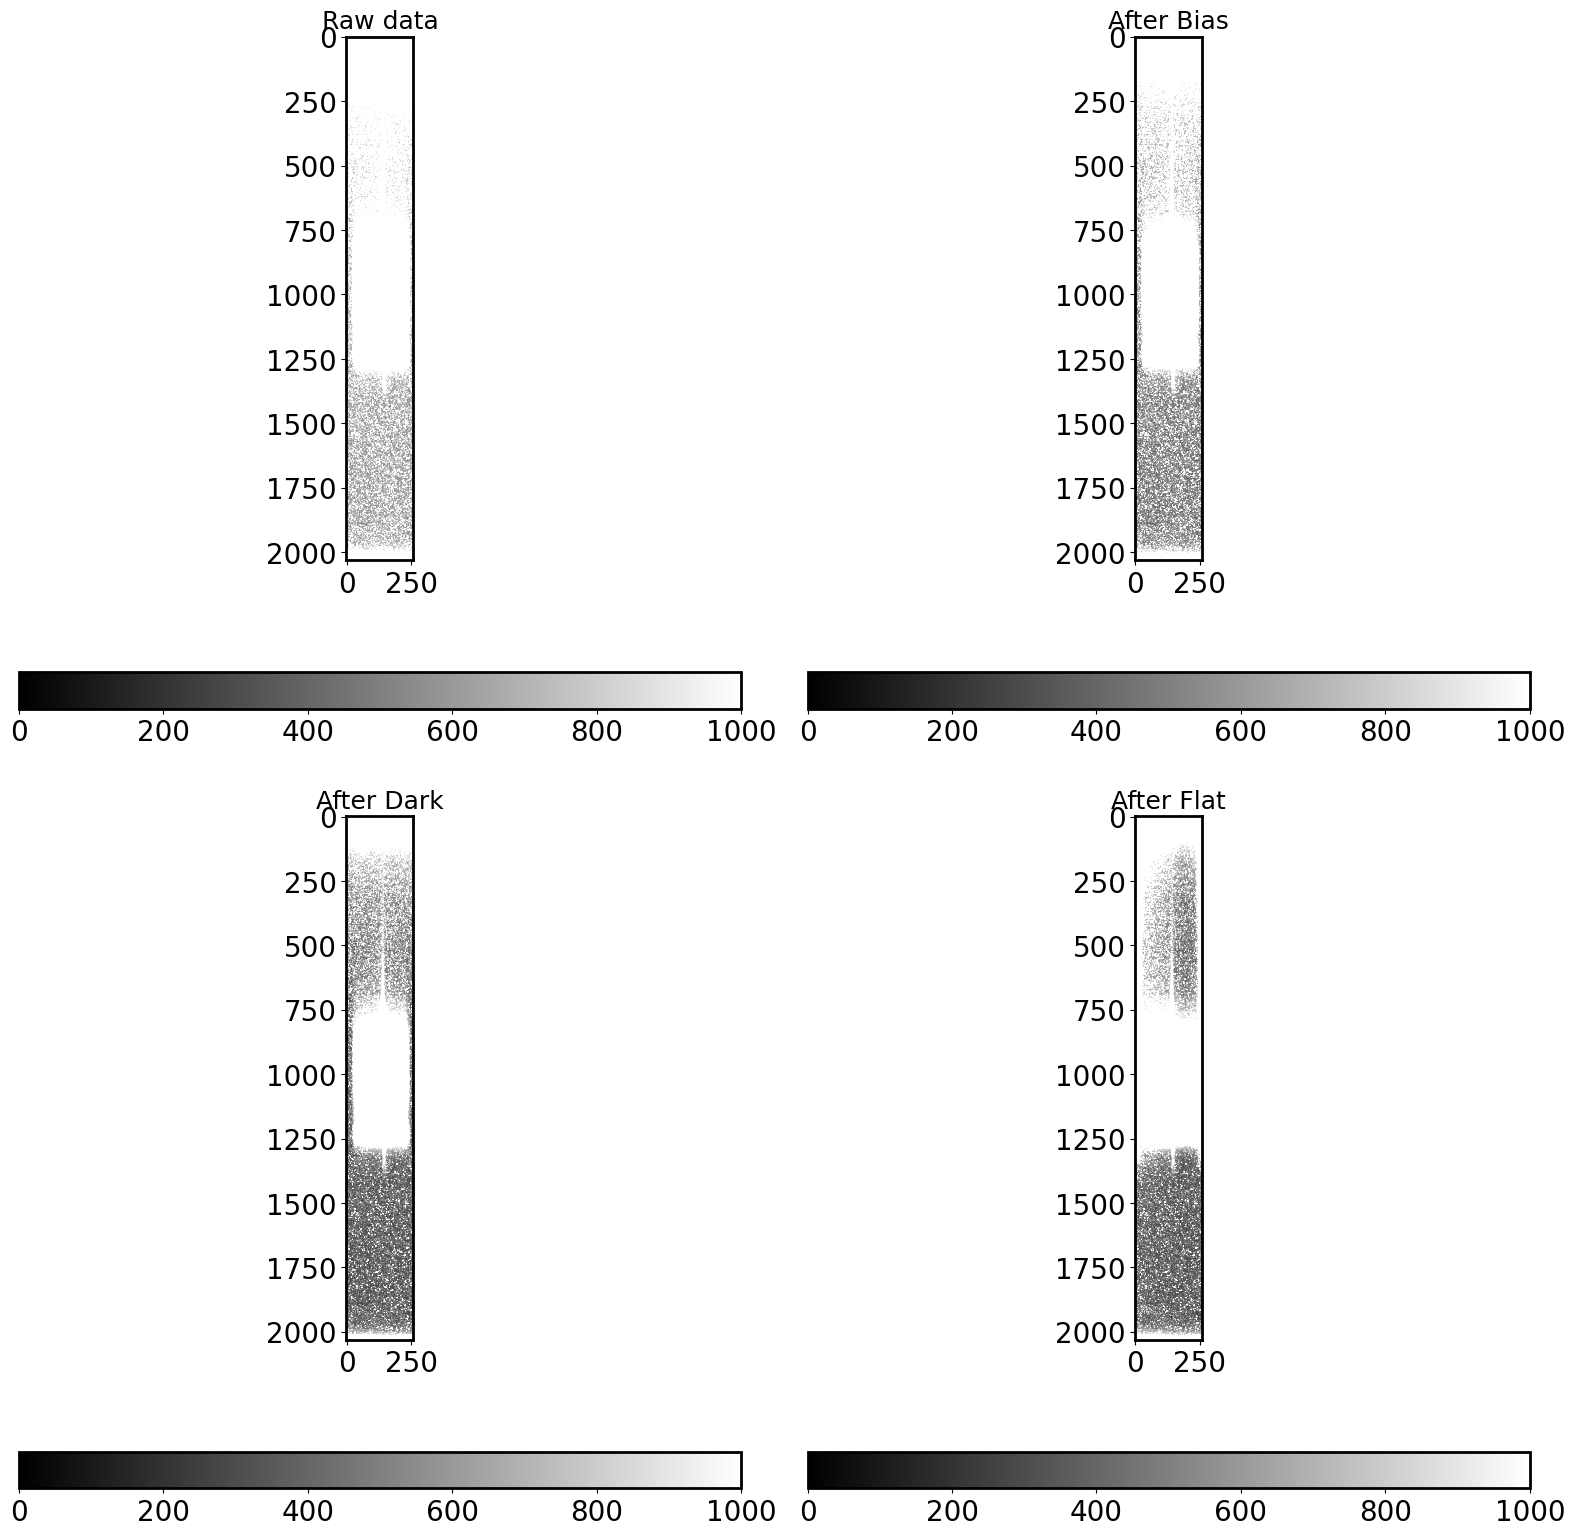

In [20]:
#Bring the sample image 
raw_data = os.path.join(subpath,'M74-0001.fit')
objhdul = fits.open(raw_data)
raw_data = objhdul[0].data

#Bring Master Bias
biasfile = os.path.join(subpath,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

#Bring Master Dark
darkfile = os.path.join(subpath,'Master_Dark_300.0s.fits')
Mdark = fits.open(darkfile)[0].data 
Mdark = np.array(Mdark).astype('float64')

#Bring Master Flat
flatfile = os.path.join(subpath,'Master_Flat.fits')
Mflat = fits.open(flatfile)[0].data 
Mflat = np.array(Mflat).astype('float64')


#Bias subtracting
bobjdata = raw_data - Mbias 

#Dark_subtracting
dbobjdata = bobjdata - Mdark

#Flat fielding
fdbobjdata = dbobjdata/Mflat


fig,ax = plt.subplots(2,2,figsize=(16,16))

ax1 = ax[0,0].imshow(raw_data,vmin=0,vmax=1000,cmap='gray')
fig.colorbar(ax1, ax=ax[0,0],orientation = 'horizontal')
ax[0,0].set_title('Raw data')



ax2 = ax[0,1].imshow(bobjdata,vmin=0,vmax=1000,cmap='gray')
fig.colorbar(ax2, ax=ax[0,1],orientation = 'horizontal')
ax[0,1].set_title('After Bias')

ax3 = ax[1,0].imshow(dbobjdata,vmin=0,vmax=1000,cmap='gray')
fig.colorbar(ax3, ax=ax[1,0],orientation = 'horizontal')
ax[1,0].set_title('After Dark')

ax4 = ax[1,1].imshow(fdbobjdata,vmin=0,vmax=1000,cmap='gray')
fig.colorbar(ax3, ax=ax[1,1],orientation = 'horizontal')
ax[1,1].set_title('After Flat')

plt.tight_layout()
plt.show()

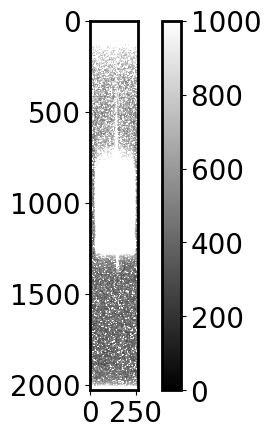

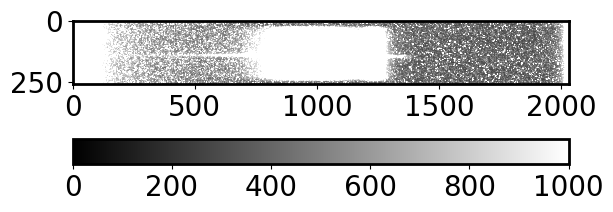

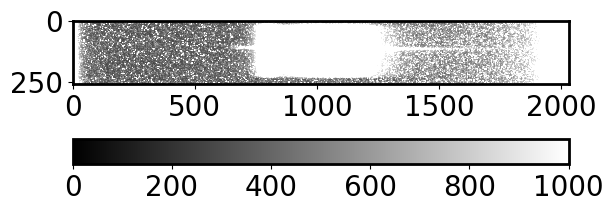

In [21]:
#Trimming 할 필요 없음
Trim = dbobjdata[:,:]
fig,ax = plt.subplots(1,1)
im = ax.imshow(Trim,vmin=0,vmax=1000,cmap='gray')
fig.colorbar(im, ax=ax)

Turn = Trim.T
fig,ax = plt.subplots(1,1)
im = ax.imshow(Turn,vmin=0,vmax=1000,cmap='gray')
fig.colorbar(im, ax=ax,orientation = 'horizontal')

Flip = np.flip(Turn)
fig,ax = plt.subplots(1,1)
im = ax.imshow(Flip,vmin=0,vmax=1000,cmap='gray')
fig.colorbar(im, ax=ax,orientation = 'horizontal')
plt.show()

In [22]:
OBJ = np.concatenate([Objectlist,Standlist])
OBJ

array(['C:\\Users\\coding\\chun2\\mystar\\M74-0001.fit',
       'C:\\Users\\coding\\chun2\\mystar\\M74-0002.fit',
       'C:\\Users\\coding\\chun2\\mystar\\M74-0003.fit',
       'C:\\Users\\coding\\chun2\\mystar\\M74-0004.fit',
       'C:\\Users\\coding\\chun2\\mystar\\M74-0005.fit',
       'C:\\Users\\coding\\chun2\\mystar\\hr8634-0001.fit',
       'C:\\Users\\coding\\chun2\\mystar\\hr8634-0002.fit',
       'C:\\Users\\coding\\chun2\\mystar\\hr8634-0003.fit',
       'C:\\Users\\coding\\chun2\\mystar\\hr8634-0004.fit',
       'C:\\Users\\coding\\chun2\\mystar\\hr8634-0005.fit'], dtype='<U44')

In [23]:
np.shape(raw_data)

(2032, 260)

In [25]:
#Do it for all object image

OBJ = np.concatenate([Objectlist,Standlist])
OBJ = list(OBJ)
del(OBJ[1:5])
OBJ = np.array(OBJ)
for i in range(len(OBJ)):
    #Bring the sample image 
    objhdul = fits.open(OBJ[i])
    raw_data = objhdul[0].data
    header = objhdul[0].header

    #Bring Master Bias
    biasfile = os.path.join(subpath,'Master_Bias.fits')
    Mbias = fits.open(biasfile)[0].data
    Mbias = np.array(Mbias).astype('float64')

    #Bring Master Dark
    EXPTIME = objhdul[0].header['EXPTIME']
    darkfile = os.path.join(subpath,'Master_Dark_{0:.1f}s.fits'.format(EXPTIME))
    Mdark = fits.open(darkfile)[0].data 
    Mdark = np.array(Mdark).astype('float64')

    #Bias subtracting
    bobjdata = raw_data - Mbias 

    #Dark_subtracting
    dbobjdata = bobjdata - Mdark
    
    #Trim the image 필요없서
    #Trim = dbobjdata[:,50:250]
    
    #Flat_fielding(If you want) 플랫ㄴㄴ
    #fdbobjdata = dbobjdata/Mflat
    
    #Rotate and Filp the image 
    Turn = dbobjdata.T
    Flip = np.flip(Turn)
    
    #Add header comment
    header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    header["COMMENT"]='{0} dark images are median combined on '.format(len(Master_dark))\
    + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')+ 'with '+' Master_Dark_'+str(exp)+'s.fits'
    
    #Save the image
    SAVE_name = os.path.join(subpath,'p'+ OBJ[i].split('\\')[-1]+'s')
    fits.writeto(SAVE_name,Flip,header = header,overwrite=True)
    print(SAVE_name,' is made!')

    
#Trim the Neon 5s image
Master_comparison = os.path.join(subpath,'Master_Neon_5.0s.fits')
hdul = fits.open(Master_comparison)[0]
data = hdul.data
#tdata = data[:,880:1100]
Turn = data.T
Flip = np.flip(Turn)
fits.writeto(os.path.join(subpath,'pMaster_Neon_5.0s.fits'),Flip,header=hdul.header,overwrite=True)
print(os.path.join(subpath,'pMaster_Neon_5.0.fits'),' is made!')

#Trim the Neon 30s image
Master_comparison = os.path.join(subpath,'Master_Neon_30.0s.fits')
hdul = fits.open(Master_comparison)[0]
data = hdul.data
#tdata = data[:,880:1100]
Turn = data.T
Flip = np.flip(Turn)
fits.writeto(os.path.join(subpath,'pMaster_Neon_30.0s.fits'),Flip,header=hdul.header,overwrite=True)
print(os.path.join(subpath,'pMaster_Neon_30.0.fits'),' is made!')

C:\Users\coding\chun2\mystar\pM74-0001.fits  is made!
C:\Users\coding\chun2\mystar\phr8634-0001.fits  is made!
C:\Users\coding\chun2\mystar\phr8634-0002.fits  is made!
C:\Users\coding\chun2\mystar\phr8634-0003.fits  is made!
C:\Users\coding\chun2\mystar\phr8634-0004.fits  is made!
C:\Users\coding\chun2\mystar\phr8634-0005.fits  is made!
C:\Users\coding\chun2\mystar\pMaster_Neon_5.0.fits  is made!
C:\Users\coding\chun2\mystar\pMaster_Neon_30.0.fits  is made!


# 여기까지 함!! 11/15

# 2. Spectroscopic data reduction
# 2-1. Extract the Spectrum

## Identification of Object's peak & Set the area of background

In [26]:
# Brin the image and combine
#obj = []
#for i in range(1,6):
#    objname = 'pM77-000{}.fits'.format(i)
#    objname = os.path.join(subpath, objname) # you should change the path properly depending the directory
#    hdul = fits.open(objname)[0]
#    obj0 = hdul.data
#    header = hdul.header
#    obj.append(obj0)
#
#obj = np.array(obj)
#obj = np.median(obj, axis = 0) # median combine
#EXPTIME = header['EXPTIME']
#fig,ax = plt.subplots(1,1,figsize=(10,15))
#ax.imshow(obj,vmin=0, vmax=1000)
#ax.set_title('EXPTIME = {0}s'.format(EXPTIME))
#ax.set_xlabel('Dispersion axis [pixel]')
#ax.set_ylabel('Spatial axis \n [pixel]')
#plt.ylim(50,250)
#plt.show()

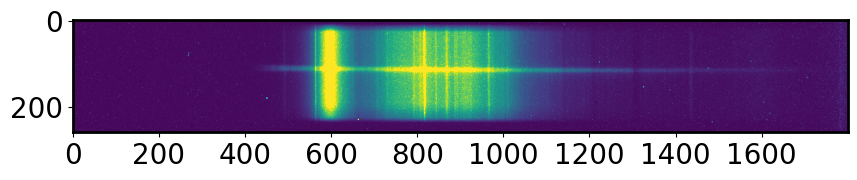

In [27]:
# 한장짜리 코드

#Bring the sample image
#
objname = os.path.join(subpath,'pM74-0001.fits')
stdname = os.path.join(subpath,'phr8634-0001.fits')
hdul = fits.open(objname)[0]
obj = hdul.data
obj = obj[:,200:2000]
header = hdul.header
EXPTIME = header['EXPTIME']
fig,ax = plt.subplots(1,1,figsize=(10,15))
ax.imshow(obj,vmin=0,vmax=3000)
#ax.set_title('EXPTIME = {0}s'.format(EXPTIME))
#ax.set_ylabel('Dispersion axis [pixel]')
#ax.set_xlabel('Spatial axis \n [pixel]')
plt.show()

[[115]]


<ipython-input-28-375ab73897f1>:19: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(apall_1, indices=True,num_peaks=10,


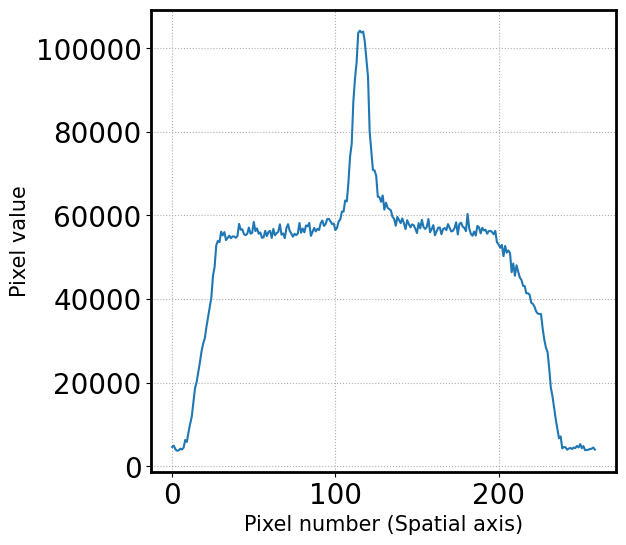

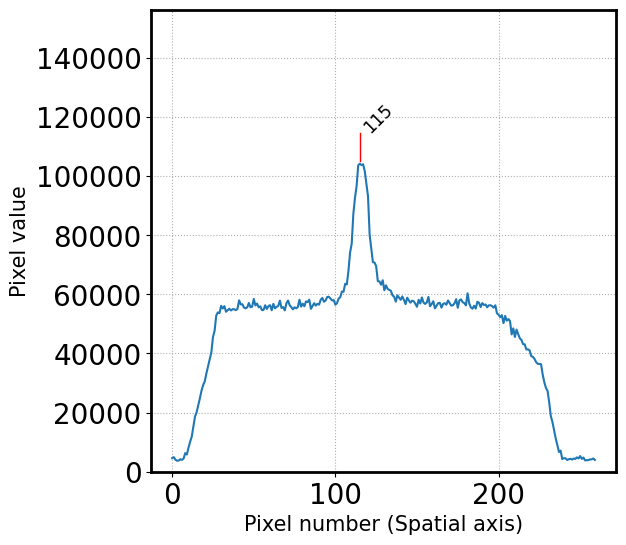

Pixel coordinatate in spatial direction = 115


In [28]:
#Let's find the peak

#Plot the spectrum along the spatial direction



lower_cut = 1000
upper_cut = 1050 # 이건 중심이 찍히는 곳의 픽셀값을 임의로 잡아서 50픽셀 간격으로 설정
apall_1 = np.sum(obj[:,lower_cut:upper_cut],axis=1)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(apall_1)
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.grid(ls=':')

#Find the peak

peak_pix = peak_local_max(apall_1, indices=True,num_peaks=10,
                          min_distance = 30,
                          threshold_abs=np.median(apall_1)*1.5)
print(peak_pix)

fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.arange(0, len(apall_1))
ax.plot(x,apall_1)
ax.set_xlabel('Spatial axis')

peak = []
for i in peak_pix:
    ax.plot((i, i), 
            (apall_1[i]+0.01*max(apall_1),apall_1[i]+0.1*max(apall_1)),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i[0], apall_1[i][0]+0.1*max(apall_1)),
            fontsize='small', rotation=45)
    peak.append(apall_1[i])

order = peak.index(max(peak))
pix_peak = peak_pix[order] 

ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, apall_1[pix_peak]*1.5)

plt.show()

print('Pixel coordinatate in spatial direction = {0}'.format(pix_peak[0]))

Peak pixel is 115 pix
ap_sky =  [ 35  75 155 195]
x_sky =  [ 35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194]
sky_val =  [55154. 54542. 54985. 54949. 54674. 55071. 57985. 56586. 56677. 55526.
 55281. 55614. 57082. 55644. 55825. 58449. 56259. 56884. 55632. 55936.
 54660. 54754. 56317. 55067. 56005. 56351. 54613. 56785. 55265. 55769.
 56087. 57883. 55391. 55690. 54576. 56967. 57906. 56326. 55685. 54919.
 56761. 57247. 59135. 55973. 56722. 57683. 55268. 56195. 57056. 57123.
 55508. 56750. 56985. 56490. 57919. 57036. 56177. 56314. 56988. 58363.
 55458. 57964. 58280. 57326. 57038. 56256. 60364. 56923. 55592. 55147.
 56152. 55198. 57510. 57150. 55713. 57031. 56408. 56575. 55629. 56272.]
Sky area is from 35 pix ~ 75 pix an

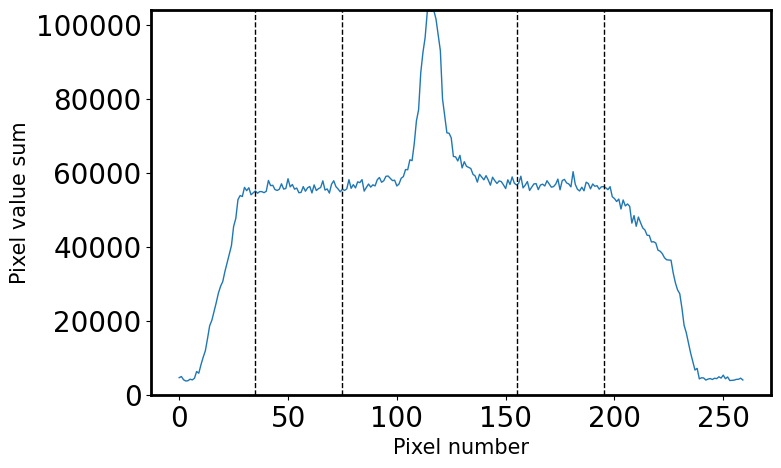

In [29]:
#select the sky area
peak = pix_peak[0] # Center
print('Peak pixel is {0} pix'.format(pix_peak[0]))

lower_limit = 40
upper_limit = 80
ap_sky = np.array([peak-upper_limit,peak-lower_limit,
                   peak+lower_limit,peak+upper_limit]) #Setting the Sky area
print('ap_sky = ',ap_sky)

x_sky = np.hstack((np.arange(ap_sky[0], ap_sky[1]), 
                   np.arange(ap_sky[2], ap_sky[3])))  #Bring the 
print('x_sky = ',x_sky)

sky_val = np.hstack((apall_1[ap_sky[0]:ap_sky[1]], 
                     apall_1[ap_sky[2]:ap_sky[3]]))
print('sky_val = ',sky_val)

print('Sky area is from {0} pix ~ {1} pix \
and {2} pix ~ {3} pix'.format(ap_sky[0], ap_sky[1], ap_sky[2], ap_sky[3]))


#Plot the sky area
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.plot(x, apall_1, lw=1)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]

ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*1)
plt.show()

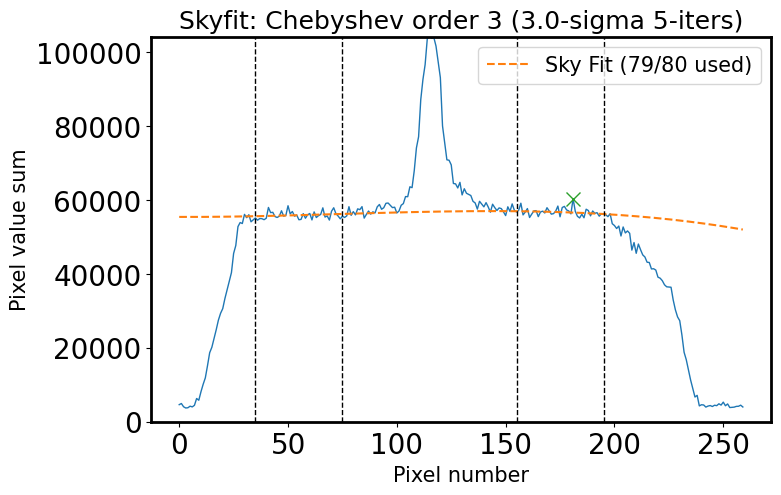

In [30]:
#Sigma Clipping
Sigma = 3
clip_mask = sigma_clip(sky_val,
                       sigma= Sigma,
                       maxiters= 5).mask

#Fit the sky
ORDER_APSKY = 3
coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
                               sky_val[~clip_mask],
                               deg=ORDER_APSKY,
                               full=True)
sky_fit = chebval(x, coeff_apsky) 

#Calculate the RMS of Fit
residual = fitfull[0][0] 
fitRMS = np.sqrt(residual/len(x_sky[~clip_mask]))


n_sky = len(x_sky)
n_rej = np.count_nonzero(clip_mask)

#Plot the sky area & fitted sky
fig,ax = plt.subplots(1,1,figsize=(8, 5))

ax.plot(x, apall_1, lw=1)
ax.plot(x, sky_fit, ls='--',
        label='Sky Fit ({:d}/{:d} used)'.format(n_sky - n_rej, n_sky))
ax.plot(x_sky[clip_mask], sky_val[clip_mask], marker='x', ls='', ms=10)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]


title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*1)
ax.legend()
ax.set_title(title_str.format('Chebyshev', ORDER_APSKY,
                              Sigma, 5))
plt.show()

Center pix of Peak is 115.95 with FWHM 11.62


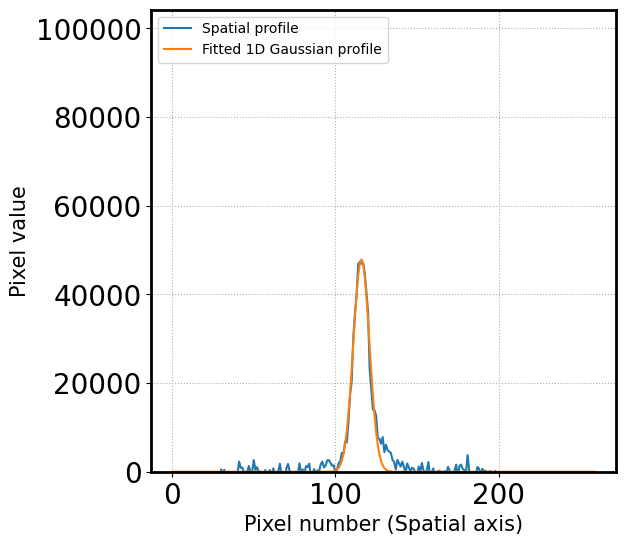

In [31]:
#Finding the peak center by fitting the gaussian 1D function again

sub_apall_1 = apall_1 - sky_fit #Profile - sky 

g_init = Gaussian1D(amplitude=sub_apall_1[pix_peak], 
                    mean = pix_peak,
                    stddev = 15* gaussian_fwhm_to_sigma)

fitter = LevMarLSQFitter()
fitted = fitter(g_init, x, sub_apall_1) # 이 코드 잘못됨 슬랙참고
center_pix = fitted.mean.value
std = fitted.stddev.value
FWHM_AP = fitted.fwhm
print('Center pix of Peak is {0:.2f} with FWHM {1:.2f}'.format(center_pix, FWHM_AP))


#Plot the image 
fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.arange(0, len(apall_1))
ax.plot(x,sub_apall_1, label='Spatial profile')

re_g_init = Gaussian1D(amplitude=fitted.amplitude.value, 
                       mean = center_pix,
                       stddev = std)
ax.plot(x,re_g_init(x), label='Fitted 1D Gaussian profile')
ax.set_xlabel('Spatial axis')

ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, apall_1[pix_peak])
ax.legend(loc=2,fontsize=10)

plt.show()

In [32]:
#Trace the Aperture (Peak) along the wavelength
#Repeat the above process for all wavelength bands.
aptrace = []
aptrace_fwhm = []
STEP_AP = 10  
N_AP = len(obj[0])//STEP_AP
FWHM_AP = 10
peak = center_pix
for i in range(N_AP - 1):
    lower_cut, upper_cut = i*STEP_AP, (i+1)*STEP_AP
    apall_i = np.sum(obj[:, lower_cut:upper_cut], axis=1)
    sky_val = np.hstack( (apall_i[ap_sky[0]:ap_sky[1]], 
                          apall_i[ap_sky[2]:ap_sky[3]]) )
    clip_mask = sigma_clip(sky_val,
                           sigma=3,
                           maxiters=5).mask
    coeff, fitfull = chebfit(x_sky[~clip_mask], 
                             sky_val[~clip_mask],
                             deg=ORDER_APSKY,
                             full=True)
    apall_i -= chebval(x,coeff)  # Object profile - the fitted sky #apall_i = apall_i - chebval(x,coeff)
    
    search_min = int(peak - 3*FWHM_AP)
    search_max = int(peak + 3*FWHM_AP)
    cropped = apall_i[search_min:search_max]
    x_cropped = np.arange(len(cropped))
    
    peak_pix = peak_local_max(cropped, 
                              indices=True,
                              min_distance=FWHM_AP,
                              num_peaks=1)
 
    if len(peak_pix)==0: #만약 스펙트럼의 중심을 찾을 수 없으면
        aptrace.append(np.nan)
        aptrace_fwhm.append(0)
        continue
        
    else:
        peak_pix = peak_pix[0][0] #스펙트럼의 중심을 찾았다면

        g_init = Gaussian1D(amplitude=cropped[peak_pix], #가우시안 피팅을 해서 중심을 다시 찾자
                            mean = peak_pix,
                            stddev = FWHM_AP * gaussian_fwhm_to_sigma,
                            bounds={'amplitude':(0, 2*cropped[peak_pix]) ,
                                   'mean':(peak_pix-3*FWHM_AP, peak_pix+3*FWHM_AP),
                                   'stddev':(0.00001, FWHM_AP*gaussian_fwhm_to_sigma)})
        fitted = fitter(g_init, x_cropped, cropped)
        center_pix_new = fitted.mean.value + search_min
        aptrace_fwhm.append(fitted.fwhm)
        aptrace.append(center_pix_new)    
        
aptrace = np.array(aptrace)
aptrace_fwhm = np.array(aptrace_fwhm)          




<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-32-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

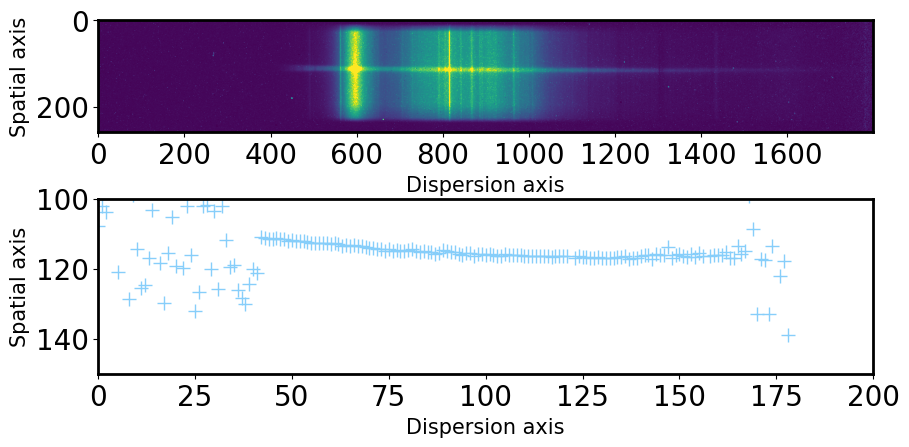

In [33]:
#Plot the center of profile peak
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].imshow(obj,vmin=0,vmax=4000)
ax[0].set_xlabel('Dispersion axis',fontsize=15)
ax[0].set_ylabel('Spatial axis',fontsize=15)

ax[1].plot(aptrace,ls='', marker='+', ms=10,color='lightskyblue')
ax[1].set_xlim(0,200)
ax[1].set_ylim(150,100) #확대해보면 찌글찌글하다
ax[1].set_xlabel('Dispersion axis',fontsize=15)
ax[1].set_ylabel('Spatial axis',fontsize=15)
plt.show()

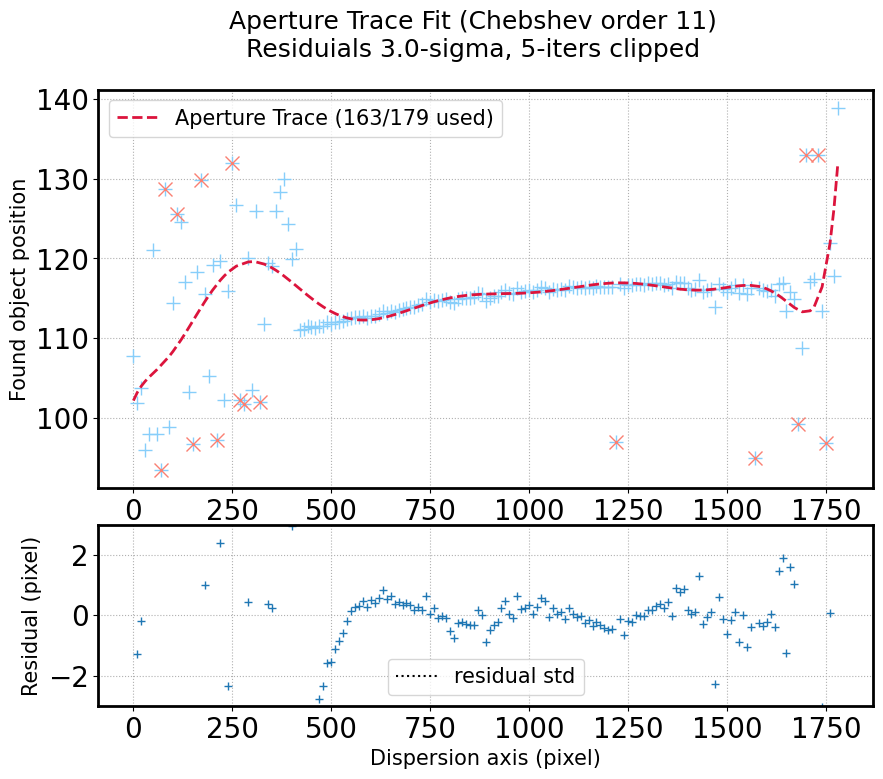

In [34]:
#Fitting the peak with Chebyshev function

ORDER_APTRACE = 11
SIGMA_APTRACE = 3
ITERS_APTRACE = 5 #When sigma_clipping

#Fitting the line
x_aptrace = np.arange(N_AP-1) * STEP_AP
coeff_aptrace = chebfit(x_aptrace, aptrace, deg=ORDER_APTRACE)

#Sigma clipping
resid_mask = sigma_clip(aptrace - chebval(x_aptrace, coeff_aptrace), 
                        sigma=SIGMA_APTRACE, maxiters=ITERS_APTRACE).mask

#Fitting the peak again after sigma clipping
x_aptrace_fin = x_aptrace[~resid_mask]
aptrace_fin = aptrace[~resid_mask]
coeff_aptrace_fin = chebfit(x_aptrace_fin, aptrace_fin, deg=ORDER_APTRACE)   

fit_aptrace_fin   = chebval(x_aptrace_fin, coeff_aptrace_fin)
resid_aptrace_fin = aptrace_fin - fit_aptrace_fin
del_aptrace = ~np.in1d(x_aptrace, x_aptrace_fin) # deleted points #x_aptrace에서 x_aptrace_fin이 없으면 True
'''
test = np.array([0, 1, 2, 5, 0])
states = [0, 2]
mask = np.in1d(test, states)
mask
array([ True, False,  True, False,  True])
'''


#Plot the Fitted line & residual
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])

ax1.plot(x_aptrace, aptrace, ls='', marker='+', ms=10,color='lightskyblue')
ax1.plot(x_aptrace_fin, fit_aptrace_fin, ls='--',color='crimson',zorder=10,lw=2,
         label="Aperture Trace ({:d}/{:d} used)".format(len(aptrace_fin), N_AP-1))
ax1.plot(x_aptrace[del_aptrace], aptrace[del_aptrace], ls='', marker='x',color='salmon', ms=10)
ax1.set_ylabel('Found object position')
ax1.grid(ls=':')
ax1.legend()


ax2.plot(x_aptrace_fin, resid_aptrace_fin, ls='', marker='+')
ax2.axhline(+np.std(resid_aptrace_fin, ddof=1), ls=':', color='k')
ax2.axhline(-np.std(resid_aptrace_fin, ddof=1), ls=':', color='k', 
            label='residual std')


ax2.set_ylabel('Residual (pixel)')
ax2.set_xlabel('Dispersion axis (pixel)')

ax2.grid(ls=':')
ax2.set_ylim(-3, 3)
ax2.legend()

#Set plot title
title_str = ('Aperture Trace Fit ({:s} order {:d})\n'
            + 'Residuials {:.1f}-sigma, {:d}-iters clipped')
plt.suptitle(title_str.format('Chebshev', ORDER_APTRACE,
                              SIGMA_APTRACE, ITERS_APTRACE))
plt.show()


In [35]:
residual_std=np.std(resid_aptrace_fin)
print(f'residual의 std는 {residual_std}')

residual의 std는 3.844624951310174


In [36]:
#Aperture sum
apsum_sigma_lower = 3 #[Sigma]
apsum_sigma_upper = 3
ap_fwhm = np.median(aptrace_fwhm[~resid_mask]) #[pix]
ap_sigma = ap_fwhm *gaussian_fwhm_to_sigma #[pixel/sigma]
x_ap = np.arange(len(obj[0])) #Pixel along the dispersion axis
y_ap = chebval(x_ap, coeff_aptrace_fin) #Center of peak for each line
ap_sky_offset = ap_sky - pix_peak #location of sky area regarding of peak point


#Extract the spectrum along the dispersion axis
ap_summed  = []
ap_sig = []

for i in range(len(obj[0])):
    cut_i = obj[:,i] #Cut spatial direction
    peak_i = y_ap[i]
    ap_sky_i = int(peak_i) + ap_sky_offset
    
    #aperture size = apsum_sigma_lower * ap_sigma
    x_obj_lower = int(np.around(peak_i - apsum_sigma_lower * ap_sigma)) 
    x_obj_upper = int(np.around(peak_i + apsum_sigma_upper * ap_sigma))         
    x_obj = np.arange(x_obj_lower, x_obj_upper)
    obj_i = cut_i[x_obj_lower:x_obj_upper]
    


    #Fitting Sky value
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])) )
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]) )
    clip_mask = sigma_clip(sky_val, sigma= Sigma,
                           maxiters= 5).mask
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    #Subtract the sky
    sub_obj_i = obj_i - chebval(x_obj, coeff) # obj - lsky  subtraction

    
    #Calculate error
    sig_i = RN **2 + sub_obj_i \
    + chebval(x_obj,coeff)
    #RN**2 + flux_i + sky value 
    
    ap_summed.append(np.sum(sub_obj_i)) 
    ap_sig.append(np.sqrt(np.sum(sig_i)))
    
ap_summed = np.array(ap_summed)/EXPTIME    
ap_std = np.array(ap_sig) / EXPTIME    

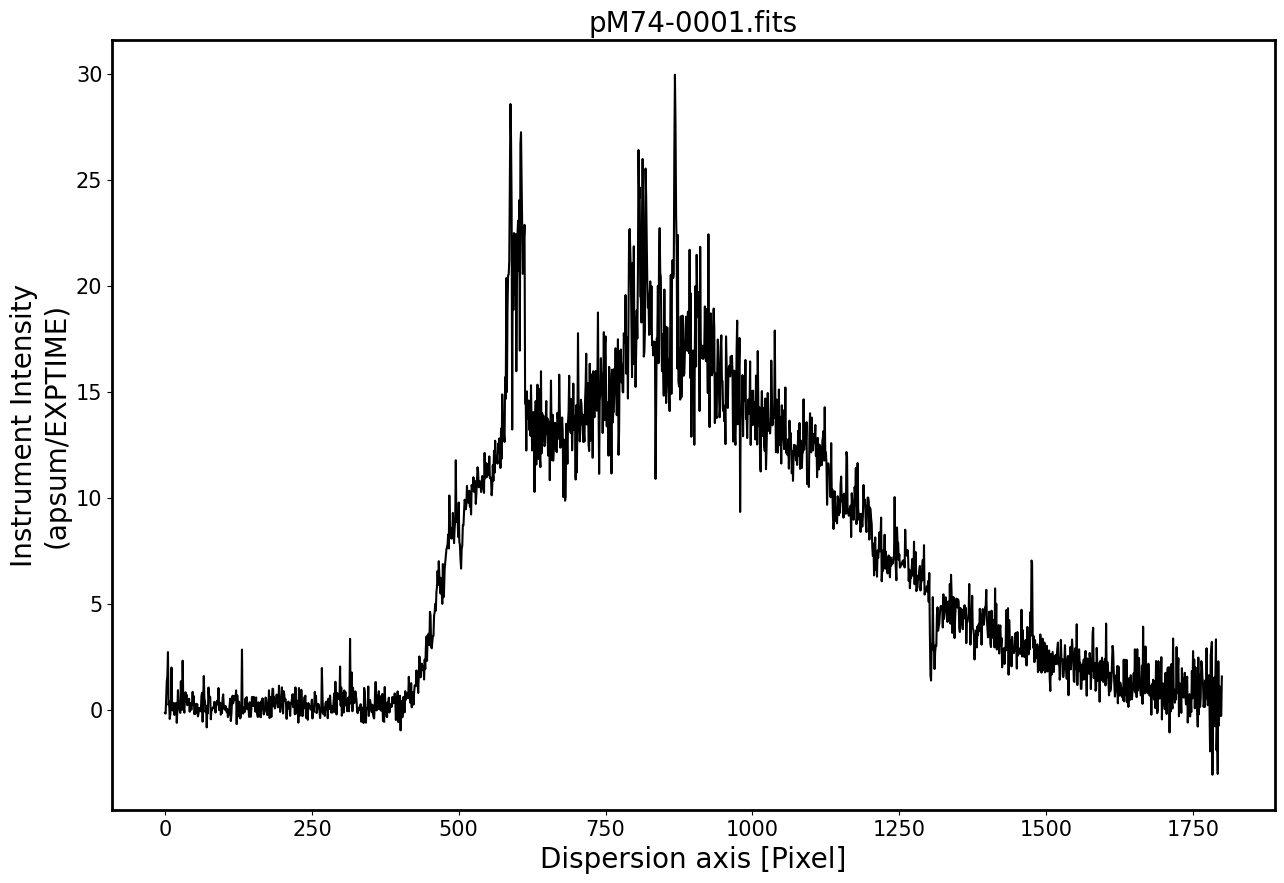

In [37]:
#Plot the spectrum 

x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(x_pix,ap_summed,color='k',alpha=1)


FILENAME = objname.split('\\')[-1]
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis [Pixel]',fontsize=20) 
ax.tick_params(labelsize=15)
plt.show()




In [ ]:
## taewon
#
##Aperture sum
#
#apsum_sigma_lower = 3 #[Sigma]
#apsum_sigma_upper = 3
#ap_fwhm = np.median(aptrace_fwhm[~resid_mask]) # The meian of the fwhm of the peak along the dispersion axis
#ap_sigma = ap_fwhm *gaussian_fwhm_to_sigma # change the ap_fwhm(pixel) to actual value
#x_ap = np.arange(len(obj[0])) #Pixel along the dispersion axis
#y_ap = chebval(x_ap, coeff_aptrace_fin) # Center of the peak for each pixel along the dispersion axis
#ap_sky_offset = ap_sky - pix_peak #location of sky area relative to the peak point # so this is the relative range of the sky area
#
#
##Extract the spectrum along the dispersion axis
#Ap_summed  = []
#Ap_sig = []
#pradi = []
#
#for i in range(len(obj[0])):
#    cut_i = obj[:,i] # select the spatial pixel
#    peak_i = y_ap[i] # the location of the peak along the spatial direction at i-th dispersion pixel
#    ap_sky_i = int(peak_i) + ap_sky_offset 
#    
#    #aperture size = apsum_sigma_lower * ap_sigma. The spectrum should be in this aperture
#    apsum_range_lower = apsum_sigma_lower * ap_sigma
#    apsum_range_upper = apsum_sigma_upper * ap_sigma
#    x_obj_lower = int(np.around(peak_i - apsum_range_lower)) #numpy.around returns the closed even number
#    x_obj_upper = int(np.around(peak_i + apsum_range_upper))         
#    x_obj = np.arange(x_obj_lower, x_obj_upper)
#    obj_i = cut_i[x_obj_lower:x_obj_upper]
#    
#
#
#    #Fitting Sky value # same with the sample
#    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
#                        np.arange(ap_sky_i[2], ap_sky_i[3])) )
#    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
#                          cut_i[ap_sky_i[2]:ap_sky_i[3]]) )
#    clip_mask = sigma_clip(sky_val, sigma= Sigma,
#                           maxiters= 5).mask
#    coeff = chebfit(x_sky[~clip_mask],
#                    sky_val[~clip_mask],
#                    deg=ORDER_APSKY)
#
#    #Subtract the sky
#    sub_obj_i = obj_i - chebval(x_obj, coeff) # obj - lsky  subtraction
#
#    
#    #Calculate error
#    sig_i = RN **2 + sub_obj_i \
#    + chebval(x_obj,coeff)
#    #RN**2 + flux_i + sky value 
#    
#    r_ap_summed = []
#    r_ap_sig_i = []
#    
#    pcenter = int(np.around(apsum_range_lower))
#    pradius = int(np.around(apsum_range_upper))
#    pradi0 = []
#    for j in range(pradius):
#        if j%1 == 0:
#            radi = pcenter+j
#            r_obj_i = sub_obj_i[radi:radi+1]
#            r_sig_i = sig_i[radi:radi+1]
#            r_ap_summed.append(np.sum(r_obj_i))
#            r_ap_sig_i.append(np.sqrt(np.sum(r_sig_i)))
#            pradi0.append(j)
#    Ap_summed.append(np.array(r_ap_summed)) 
#    Ap_sig.append(np.array(r_ap_sig_i))
#    pradi.append(pradi0)
#    
#Ap_summed = np.array(Ap_summed).T
#Ap_summed = Ap_summed/EXPTIME
#Ap_sig = np.array(Ap_sig).T
#Ap_std = np.array(Ap_sig) / EXPTIME 
#
#print('pixel radius is', np.median(np.array(pradi), axis=0))

In [ ]:
##Plot the spectrum 
#
#x_pix = np.arange(len(obj[0]))
#
#fig,ax = plt.subplots(1,1,figsize=(15,10))
#ax.plot(x_pix,Ap_summed[0], label='r=0',color='black')
##ax.plot(x_pix,Ap_summed[1], label='r=1')
##ax.plot(x_pix,Ap_summed[2], label='r=2')
##ax.plot(x_pix,Ap_summed[3], label='r=3')
##ax.plot(x_pix,Ap_summed[4], label='r=4')
##ax.plot(x_pix,Ap_summed[5], label='r=5')
##ax.plot(x_pix,Ap_summed[6], label='r=6')
##ax.plot(x_pix,Ap_summed[7], label='r=7')
##ax.plot(x_pix,Ap_summed[8], label='r=8')
##ax.plot(x_pix,Ap_summed[9], label='r=9')
##ax.plot(x_pix,Ap_summed[10], label='r=10')
##ax.plot(x_pix,Ap_summed[11], label='r=11')
#plt.legend()
#
#
#FILENAME = objname.split('\\')[-1]
#ax.set_title('M74 - 0 pixels away from center',fontsize=20)
#ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
#ax.set_xlabel(r'Dispersion axis [Pixel]',fontsize=20) 
#ax.tick_params(labelsize=15)
##plt.ylim(-10,20)
##plt.xlim(750,800)
#plt.show()
#
#
#

# 2-2. Wavelength calibration

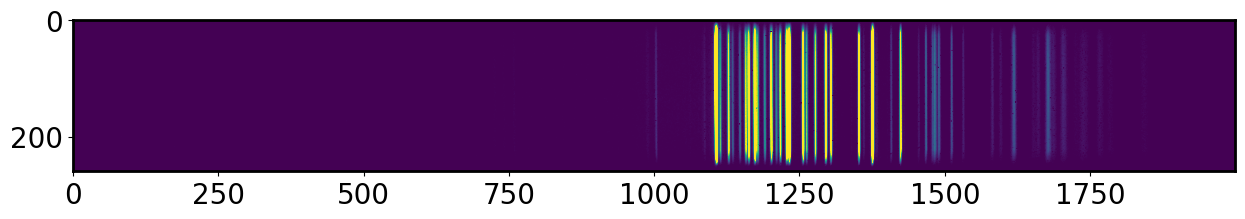

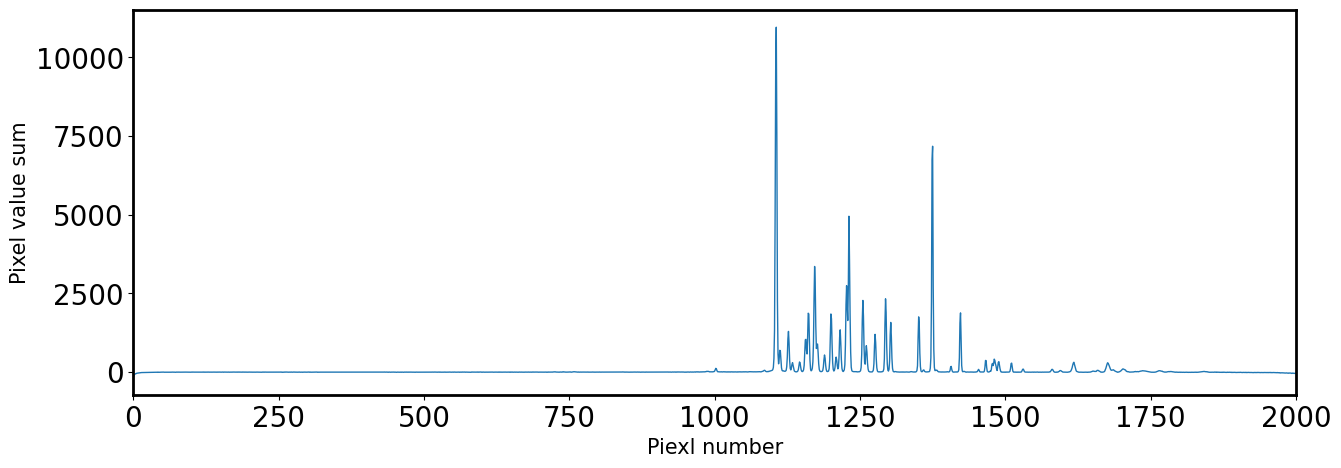

In [38]:
#Bring the Master Comparison image
Master_comparison = os.path.join(subpath,'pMaster_Neon_5.0s.fits')
compimage = fits.open(Master_comparison)[0].data
compimage = compimage[:,:2000]
identify = np.median(compimage[90:110,:],
                         axis=0)
fig,ax = fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(compimage, vmin=0, vmax=1000)

fig,ax = plt.subplots(1,1,figsize=(15,5))
x_identify = np.arange(0,len(identify))
ax.plot(x_identify,identify,lw=1)
ax.set_xlabel('Piexl number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(0,len(identify))
plt.show()
plt.tight_layout()


<Figure size 640x480 with 0 Axes>

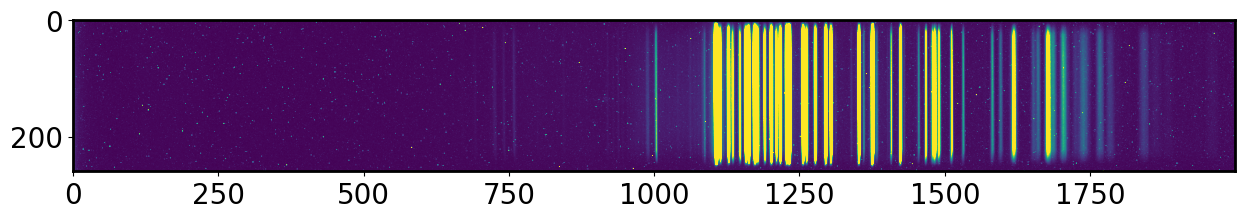

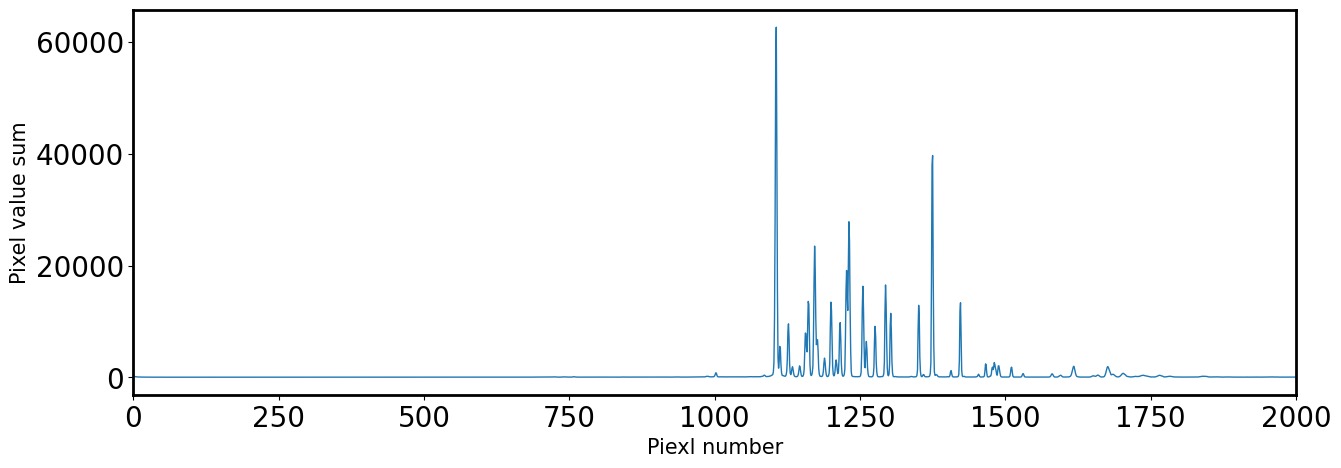

In [39]:
#Bring the Master Comparison image
Master_comparison = os.path.join(subpath,'pMaster_Neon_30.0s.fits')
compimage = fits.open(Master_comparison)[0].data
compimage = compimage[:,:2000]
identify = np.median(compimage[90:110,:],
                         axis=0)
fig,ax = fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(compimage, vmin=0, vmax=1000)

fig,ax = plt.subplots(1,1,figsize=(15,5))
x_identify = np.arange(0,len(identify))
ax.plot(x_identify,identify,lw=1)
ax.set_xlabel('Piexl number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(0,len(identify))
plt.show()
plt.tight_layout()


<ipython-input-40-00167a118ba9>:3: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(identify,


<Figure size 640x480 with 0 Axes>

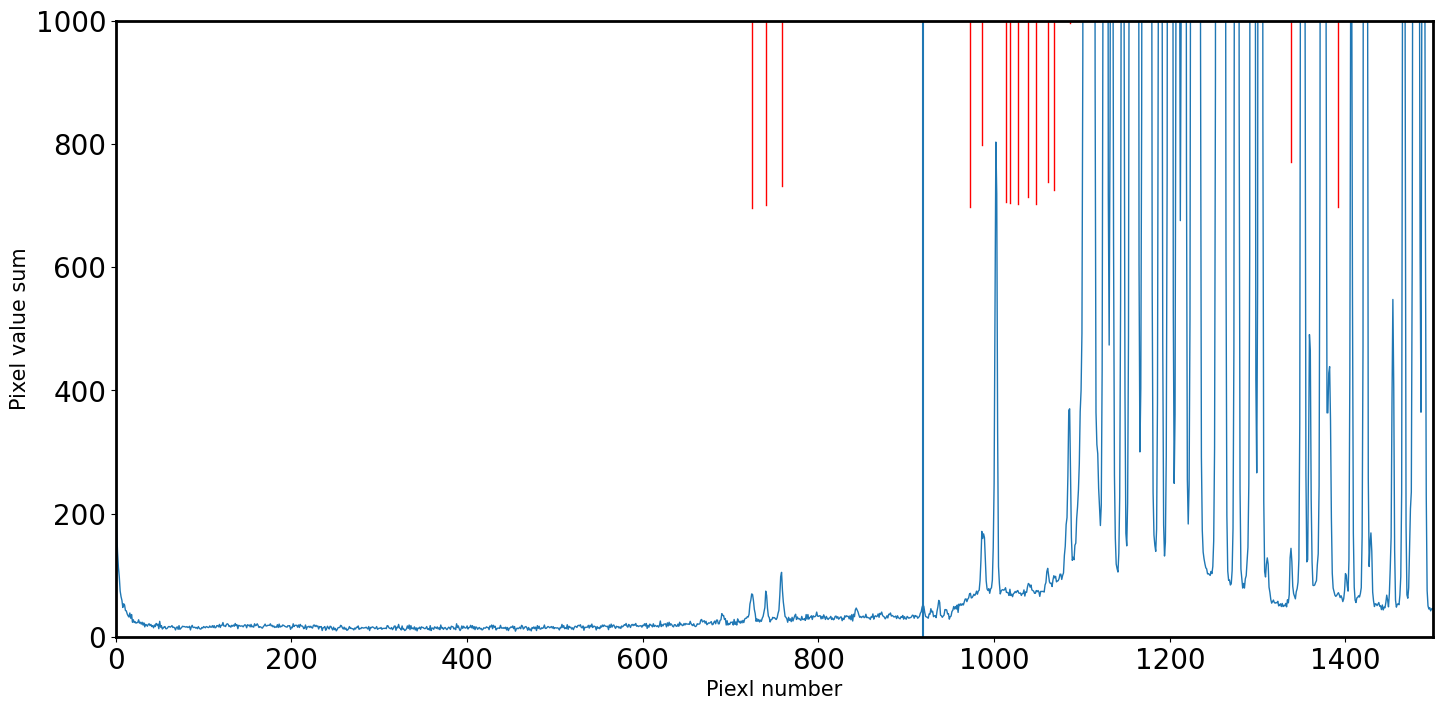

In [40]:
## Find the local peak

peak_pix = peak_local_max(identify,
                          indices=True,
                          num_peaks = max(identify),
                          min_distance = 4,
                          threshold_abs= max(identify)*0.001)


fig,ax = plt.subplots(1,1,figsize=(17,8))
x_identify = np.arange(0,len(identify))
ax.plot(x_identify,identify,lw=1)
for i in peak_pix:
    ax.plot([i,i],
            [identify[i]+0.01*max(identify),identify[i]+0.06*max(identify)],
            color='r',lw=1)
    ax.annotate(i[0],(i,identify[i]+0.06*max(identify)),
                fontsize=10,
                rotation=80)

ax.set_xlabel('Piexl number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(0,1500)
ax.set_ylim(0,1000)
#ax.set_ylim(-20,max(identify) + max(identify)*0.2)
#ax.set_ylim(0,5000)
ax.axvline(919)
plt.show()
plt.tight_layout()

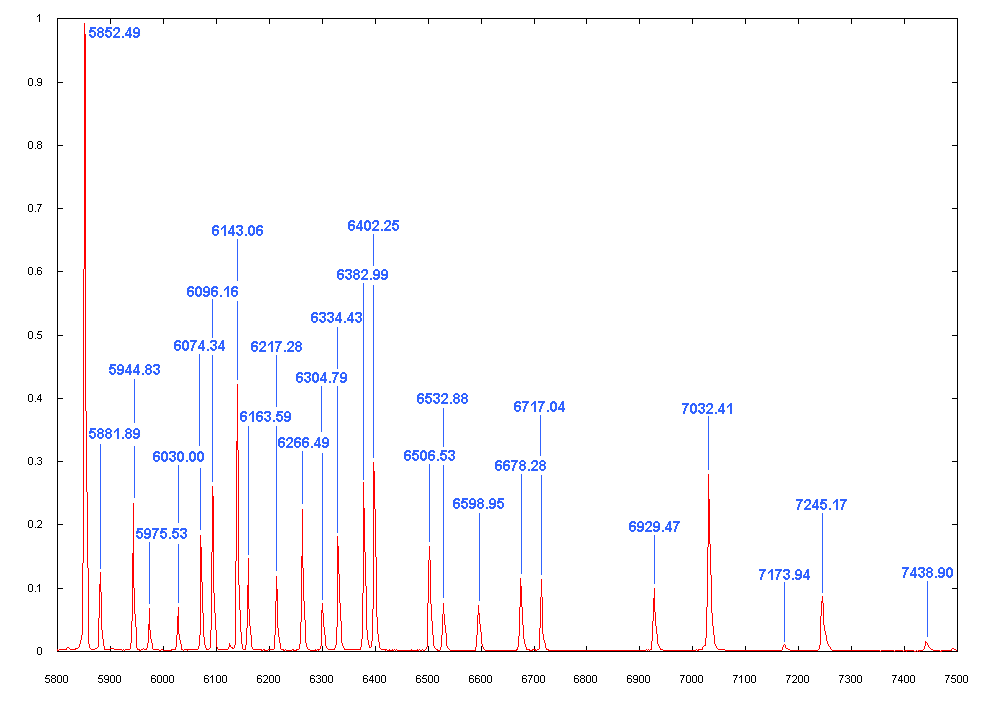

In [41]:
#Comparison Lampe line list

LISTFILE = os.path.join(subpath,'neon1.gif')
Image(filename = LISTFILE, width=800)
#http://astrosurf.com/buil/us/spe2/hresol4.htm

3198.9596288642774


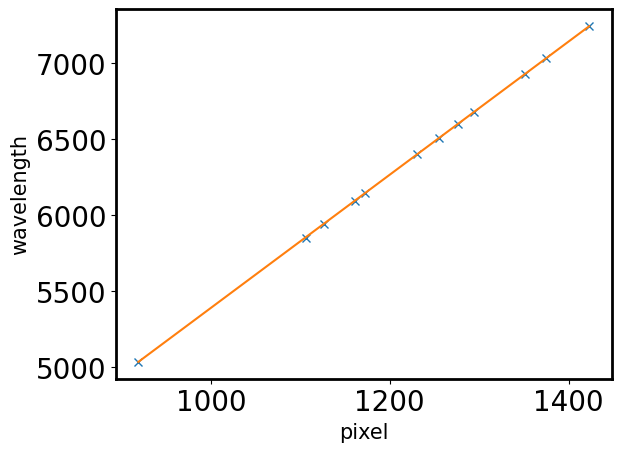

In [42]:
#Find the matching pair of wavelength and pixel

#ID_init = dict(pixel_init = [1106,1172,1231,1255,1276,1294,1303,1351,1375,1425],
 #             wavelength = [5852.49,6143.06,6402.25,6506.53,6598.95,6678.28,6717.04,6929.47,7032.41,7245.17]
 #             )


a = np.array([1086-500,606,627,661,672,731,755,776,794,803, 851,875,923]) + 500
a = np.array([419,606,627,661,672,731,755,776,794, 851,875,923]) + 500
#ID_init = dict(pixel_init = [606,627,661,672,731,
#                             755,776,794,803,
#                             851,875,923],
#            wavelength = [5852.49,5944.83,6096.16,6143.06,6402.25,
#                          6506.53,6598.95,6678.28,6717.04,
#                          6929.47,7032.41,7245.17])

ID_init = dict(pixel_init = a,
            wavelength = [5037.37,5852.49,5944.83,6096.16,6143.06,6402.25,
                          6506.53,6598.95,6678.28,
                          6929.47,7032.41,7245.17])

ID_init = Table(ID_init)
plt.plot(ID_init['pixel_init'],ID_init['wavelength'],marker='x',ls='')

def linear(x,a,b):
    return a*x + b
popt,pcov = curve_fit(linear,ID_init['pixel_init'],ID_init['wavelength'])
plt.plot(ID_init['pixel_init'],linear(ID_init['pixel_init'],*popt))
plt.xlabel('pixel')
plt.ylabel('wavelength')
print(linear(500,*popt))
plt.show()

In [43]:
#astrosurf.com/buil/us/spe2/hresol4.htm
#Fit the each peak with Gaussian 1D function

peak_gauss = []
fitter = LevMarLSQFitter()
LINE_FITTER = LevMarLSQFitter()
FWHM_ID = 3
x_identify = np.arange(0,len(identify))

#Gaussian fitting for each peak (pixel)
for peak_pix in ID_init['pixel_init']:
    g_init = Gaussian1D(amplitude = identify[peak_pix],
                        mean = peak_pix,
                        stddev = FWHM_ID*gaussian_fwhm_to_sigma,
                        bounds={'amplitude':(0,2*identify[peak_pix]),
                                'mean':(peak_pix - FWHM_ID,peak_pix + FWHM_ID),
                                'stddev':(0,FWHM_ID)})
    fitted = LINE_FITTER(g_init,x_identify,identify) #Model, x, y
    peak_gauss.append(fitted.mean.value)
    print(peak_pix,'->',fitted.mean.value)
    
    
peak_gauss = Column(data=peak_gauss,
                        name='pixel_gauss',
                        dtype=float)    
peak_shift = Column(data=peak_gauss - ID_init['pixel_init'],
                    name='piexl_shift',
                    dtype=float) 
ID_init['pixel_gauss'] = peak_gauss
ID_init['pixel_shift'] = peak_gauss - ID_init['pixel_init']
ID_init.sort('wavelength')
ID_init.pprint()

919 -> 919.2740596282075
1106 -> 1105.7111066133218
1127 -> 1126.8675967449244
1161 -> 1160.227177489033
1172 -> 1172.268268055503
1231 -> 1229.8643966214895
1255 -> 1255.0836374123517
1276 -> 1276.0944415243325
1294 -> 1294.177497316482
1351 -> 1351.2016008773305
1375 -> 1374.5577695267
1423 -> 1422.7478894492733
pixel_init wavelength    pixel_gauss         pixel_shift     
---------- ---------- ------------------ --------------------
       919    5037.37  919.2740596282075   0.2740596282075103
      1106    5852.49 1105.7111066133218 -0.28889338667818265
      1127    5944.83 1126.8675967449244 -0.13240325507558737
      1161    6096.16  1160.227177489033  -0.7728225109669893
      1172    6143.06  1172.268268055503  0.26826805550308563
      1231    6402.25 1229.8643966214895  -1.1356033785104955
      1255    6506.53 1255.0836374123517  0.08363741235166344
      1276    6598.95 1276.0944415243325  0.09444152433252384
      1294    6678.28  1294.177497316482  0.17749731648200395
  

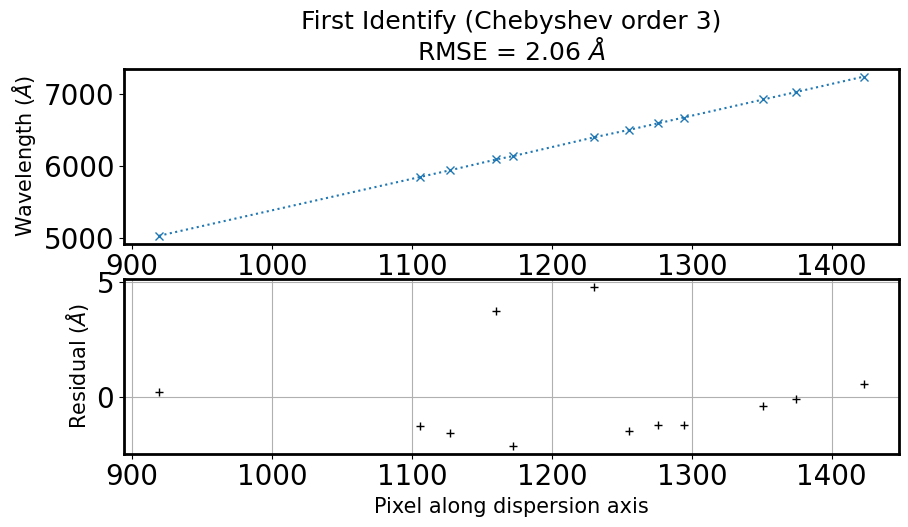

In [44]:
#Derive dispersion solution

ORDER_ID = 3 #Order of fitting function #보통 3 이하로 함. 기기의 사용파장대가 넓으면 4를 사용할때도 있음. 
coeff_ID, fitfull = chebfit(ID_init['pixel_gauss'],
                           ID_init['wavelength'],
                           deg=ORDER_ID,
                           full=True)  #Derive the dispersion solution

fitRMS = np.sqrt(fitfull[0][0]/len(ID_init))
rough_error = ((max(ID_init['wavelength'])-min(ID_init['wavelength']))
               /(max(ID_init['pixel_gauss'])-min(ID_init['pixel_gauss'])))/2
residual = (ID_init['wavelength'] #wavelength from reference
            -chebval(ID_init['pixel_gauss'],coeff_ID)) #wavelength derived from fitting
res_range = np.max(np.abs(residual))

fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(ID_init['pixel_gauss'],
         ID_init['wavelength'],
         ls = ':',marker='x')
ax[1].plot(ID_init['pixel_gauss'],
          residual,
          ls='',marker='+',
          color='k')
#ax[1].set_xlim(600,950)
#ax[0].set_xlim(600,950)
ax[0].set_ylabel(r'Wavelength ($\AA$)')
ax[1].set_ylabel(r'Residual ($\AA$)')
ax[1].set_xlabel('Pixel along dispersion axis')
ax[0].set_title('First Identify (Chebyshev order {:d})\n'.format(ORDER_ID) 
              + r'RMSE = {:.2f} $\AA$'.format(fitRMS))
ax[1].grid()
plt.show()

In [45]:
residual
rrms = (np.mean(residual**2))**0.5
rrms
print(f'평균제곱근오차 RMS는 {rrms}이다.')

평균제곱근오차 RMS는 2.0557167393844824이다.


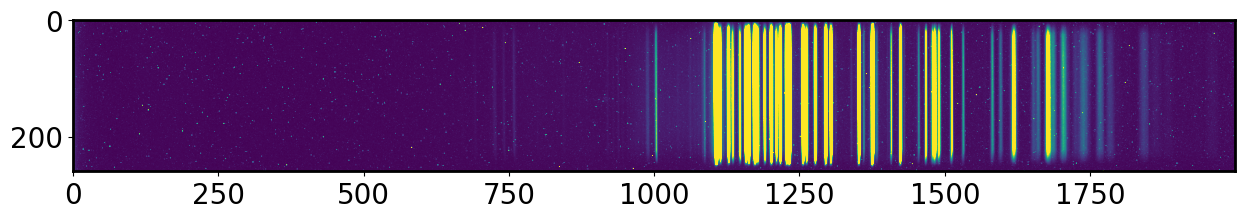

In [46]:
fig,ax = fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(compimage,vmin=0,vmax=1000)
plt.show()

In [47]:
#REIDENTIFY 

STEP_AP = 5 #Step size in pixel (dispersion direction)
STEP_REID = 10 #Step size in pixel (spatial direction)
N_SPATIAL,N_WAVELEN = np.shape(compimage) #(220, 2048)
#N_SPATIAL,N_WAVELEN = (220,2048)
N_REID = N_SPATIAL//STEP_REID #Spatial direction 
N_AP = N_WAVELEN//STEP_AP #Dispersion direction
TOL_REID = 5 # tolerence to lose a line in pixels

ORDER_WAVELEN_REID = 3 
ORDER_SPATIAL_REID = 3

line_REID = np.zeros((N_REID-1,len(ID_init))) #Make the empty array (height, width)
spatialcoord = np.arange(0,(N_REID-1)*STEP_REID,STEP_REID) + STEP_REID/2
# spatialcoord = array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
#       115., 125., 135., 145., 155., 165., 175., 185., 195., 205.])
#print(spatialcoord)




#Repeat we did above along the spatial direction
for i in range(0,N_REID-1): 
    lower_cut = i*STEP_REID
    upper_cut = (i+1)*STEP_REID
    reidentify_i = np.sum(compimage[lower_cut:upper_cut,:],axis=0)

    peak_gauss_REID = [] 
    
    for peak_pix_init in ID_init['pixel_gauss']:
        search_min = int(np.around(peak_pix_init - TOL_REID))
        search_max = int(np.around(peak_pix_init + TOL_REID))
        cropped = reidentify_i[search_min:search_max]
        x_cropped = np.arange(len(cropped)) + search_min

        #Fitting the initial gauss peak by usijng Gausian1D
        Amplitude_init = np.max(cropped)
        mean_init = peak_pix_init
        stddev_init = 5*gaussian_fwhm_to_sigma
        g_init = Gaussian1D(amplitude = Amplitude_init,
                           mean = mean_init,
                           stddev = stddev_init,
                           bounds={'amplitude':(0, 2*np.max(cropped)) ,
                                 'stddev':(0, TOL_REID)})
        g_fit = fitter(g_init,x_cropped,cropped)
        fit_center = g_fit.mean.value    
        if abs(fit_center - peak_pix_init) > TOL_REID: #스펙트럼 끝에서는 잘 안 잡힐수있으니까
            peak_gauss_REID.append(np.nan)
            continue
        else:
            peak_gauss_REID.append(fit_center)
            
    peak_gauss_REID = np.array(peak_gauss_REID)  
    nonan_REID = np.isfinite(peak_gauss_REID)
    line_REID[i,:] = peak_gauss_REID  
    peak_gauss_REID_nonan = peak_gauss_REID[nonan_REID] 
    n_tot = len(peak_gauss_REID)
    n_found = np.count_nonzero(nonan_REID)
    coeff_REID1D, fitfull = chebfit(peak_gauss_REID_nonan,
                                    ID_init['wavelength'][nonan_REID], 
                                    deg=ORDER_WAVELEN_REID,
                                    full=True)
    fitRMS = np.sqrt(fitfull[0][0]/n_found)
    
points = np.vstack((line_REID.flatten(),
                    np.tile(spatialcoord, len(ID_init['pixel_init']))))
#np.tile(A,reps):Construct an array by repeating A the number of times given by reps.
# a = np.array([1, 2, 3])
# b = np.array([2, 3, 4])
# np.vstack((a,b)) = array([[1, 2, 3],[2, 3, 4]])
points = points.T # list of ()  
                   

values = np.tile(ID_init['wavelength'], N_REID - 1) #Wavelength corresponding to each point
values = np.array(values.tolist())  #
# errors = np.ones_like(values)


# #Fitting the wavelength along spatial direction and dispertion direction 
coeff_init = Chebyshev2D(x_degree=ORDER_WAVELEN_REID, y_degree=ORDER_SPATIAL_REID)
fit2D_REID = fitter(coeff_init, points[:, 0], points[:, 1], values) 
#Dispersion solution (both spatial & dispersion) #fitter(order,x,y,f(x,y))

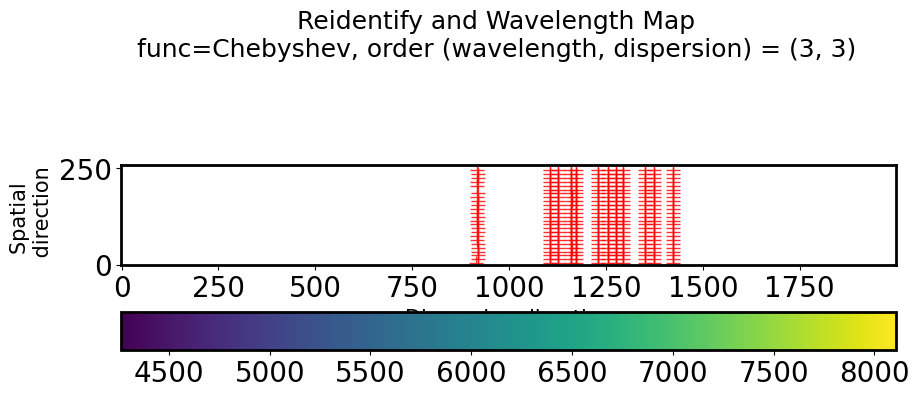

In [48]:
#Plot 2D wavelength callibration map and #Points to used re-identify

fig,ax = plt.subplots(1,1,figsize=(10,4))
ww, ss = np.mgrid[:N_WAVELEN, :N_SPATIAL]
im = ax.imshow(fit2D_REID(ww, ss).T, origin='lower',vmin=4264.4,vmax=8108.99)
ax.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
fig.colorbar(im, ax=ax,orientation = 'horizontal')

ax.set_ylabel('Spatial \n direction')
ax.set_xlabel('Dispersion direction')
title_str = ('Reidentify and Wavelength Map\n'
+ 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')


plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))
plt.show()

C:\Users\coding\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\coding\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


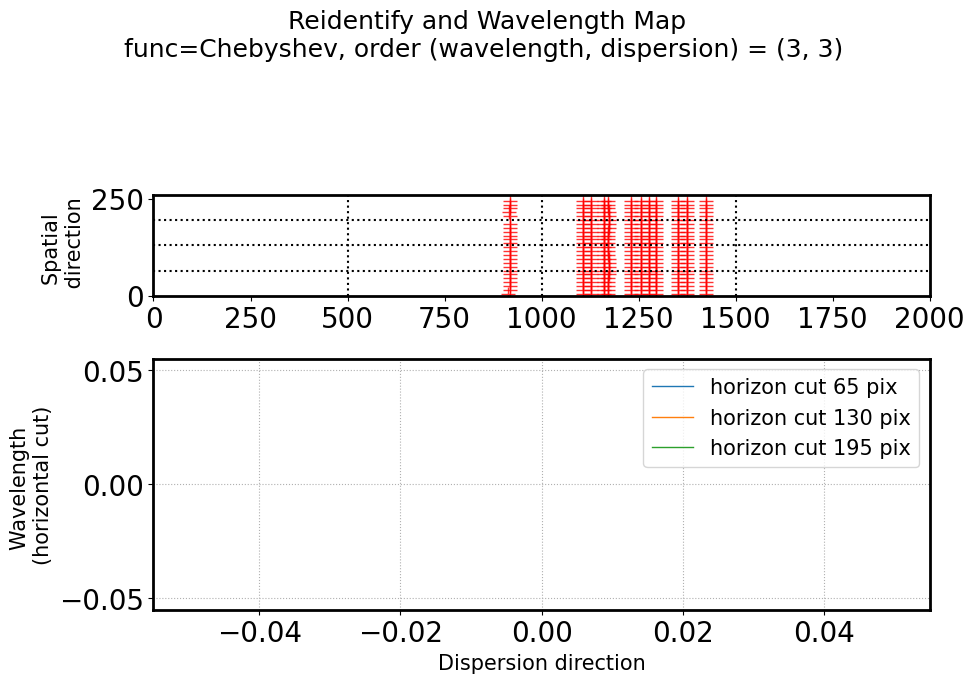

In [49]:
# Check how the dispersion solution change along the spatial axis
# Divide spectrum into 4 equal parts in the spatial direction

fig,ax = plt.subplots(2,1,figsize=(10,7))
ax[0].imshow(fit2D_REID(ww, ss).T, origin='lower')
ax[0].plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
ax[0].set_xlim(0,2000)
ax[0].set_ylabel('Spatial \n direction')

title_str = ('Reidentify and Wavelength Map\n'
+ 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d}) \n')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))


for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2 #Spatial dir coordinate
    hcutax  = np.arange(0, N_WAVELEN, 1) # pixel along dispersion axis
    
    vcutrep = np.repeat(vcut, len(vcutax)) #i/4에 해당하는 dispersion pixel * len(spatial)
    hcutrep = np.repeat(hcut, len(hcutax)) #i/4에 해당하는 spatial pixel * len(dispersion)

    ax[0].axvline(x=vcut, ls=':', color='k')   
    ax[0].axhline(y=hcut, ls=':', color='k')

    ax[1].plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="horizon cut {:d} pix".format(int(hcut)))
#ax[1].set_xlim(0,2000)
#ax[0].set_xlim(0,2000)
ax[1].grid(ls=':')
ax[1].legend()
ax[1].set_xlabel('Dispersion direction')
ax[1].set_ylabel('Wavelength \n(horizontal cut)')
#ax[1].set_ylim(min(ID_init['wavelength'])*0.5,max(ID_init['wavelength'])*1.5)


plt.tight_layout()
plt.show()

C:\Users\coding\anaconda3\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\coding\anaconda3\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


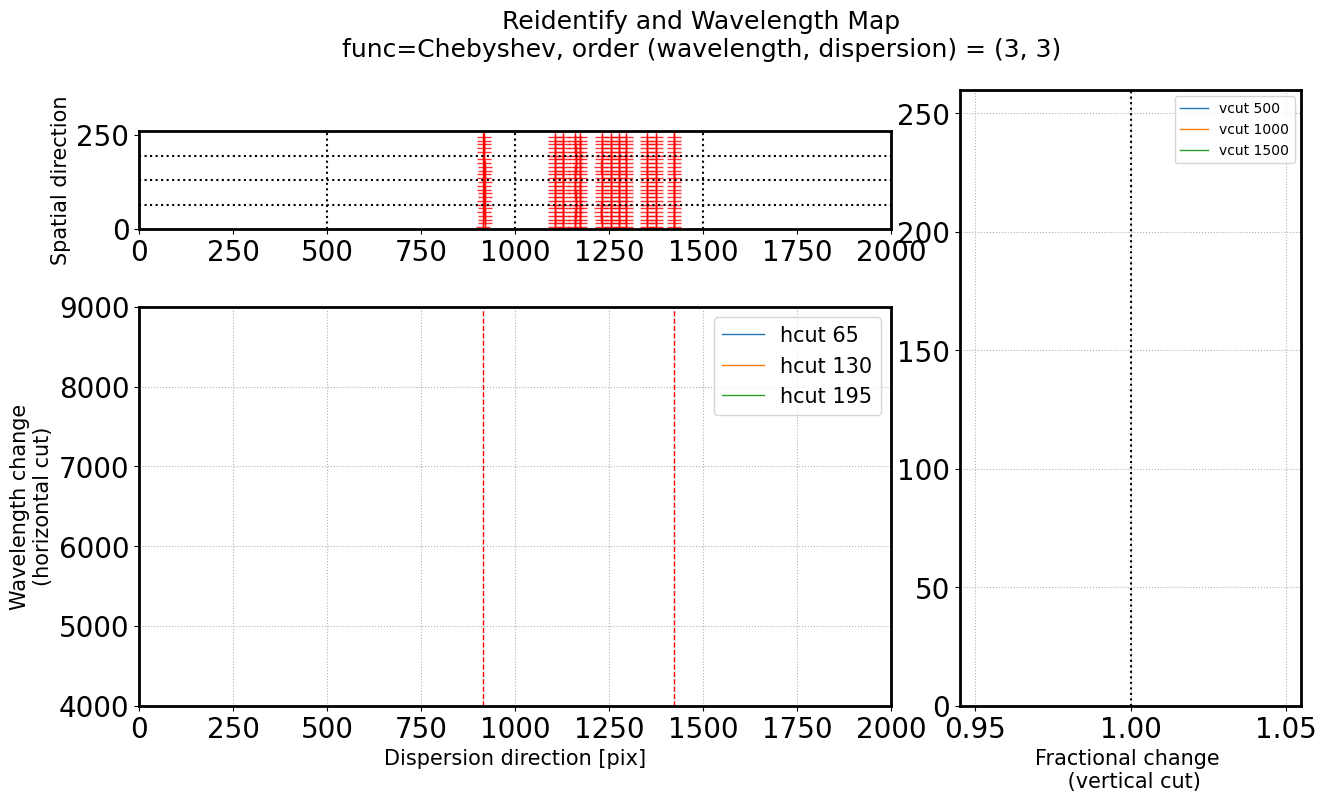

In [50]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[:1, :2])
ax2 = plt.subplot(gs[1:3, :2])
ax3 = plt.subplot(gs[:3, 2])

#Title
title_str = ('Reidentify and Wavelength Map\n'
             + 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))



interp_min = line_REID[~np.isnan(line_REID)].min()
interp_max = line_REID[~np.isnan(line_REID)].max()

ax1.imshow(fit2D_REID(ww, ss).T, origin='lower')
ax1.axvline(interp_max, color='r', lw=1)
ax1.axvline(interp_min, color='r', lw=1)
ax1.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
ax1.set_xlim(0,2000)
ax1.set_ylabel('Spatial \n direction')



for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2
    hcutax  = np.arange(0, N_WAVELEN, 1)
    vcutrep = np.repeat(vcut, len(vcutax))
    hcutrep = np.repeat(hcut, len(hcutax))

    ax1.axvline(x=vcut, ls=':', color='k')   
    ax1.axhline(y=hcut, ls=':', color='k')

    ax2.plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="hcut {:d}".format(int(hcut)))

    
    vcut_profile = fit2D_REID(vcutrep, vcutax)
    vcut_normalize = vcut_profile / np.median(vcut_profile)
    
    ax3.plot(vcut_normalize, vcutax, lw=1,
             label="vcut {:d}".format(int(vcut)))



ax2.axvline(interp_max, color='r', lw=1,ls='--')
ax2.axvline(interp_min, color='r', lw=1,ls='--')    
    
ax1.set_ylabel('Spatial direction')
ax2.grid(ls=':')
ax2.legend(fontsize=15)
ax2.set_xlabel('Dispersion direction [pix]')
ax2.set_ylabel('Wavelength change\n(horizontal cut)')

ax3.axvline(1, ls=':', color='k')
ax3.grid(ls=':', which='both')
ax3.set_xlabel('Fractional change \n (vertical cut)')
ax3.legend(fontsize=10)

ax1.set_ylim(0, N_SPATIAL)
ax1.set_xlim(0, N_WAVELEN)
# ax2.set_xlim(300, 1700)
ax2.set_xlim(0, N_WAVELEN)
ax2.set_ylim(4000,9000)
ax3.set_ylim(0, N_SPATIAL)
plt.show()

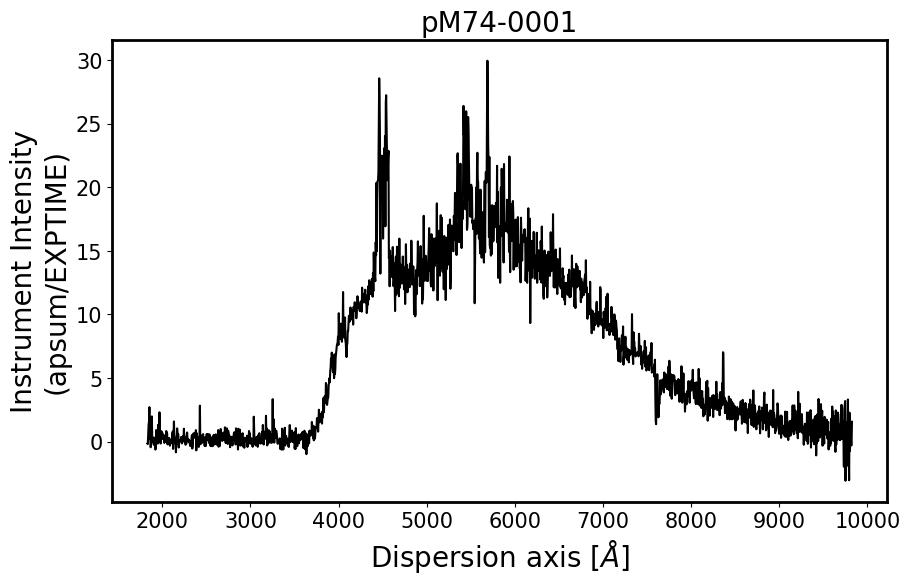

In [60]:
#Plot the spectrum respect to wavelength

#for i in range(len(ap_summed)) : 
Wavelength = chebval(np.arange(len(compimage[0])),coeff_ID)
Wavelength = Wavelength[200:]

x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(Wavelength,ap_summed,color='k',alpha=1)


FILENAME = objname.split('\\')[-1].split('.')[0]
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.tick_params(labelsize=15)
#ax.set_xlim(2000,5000)
plt.show()



SAVE_FILENAME = os.path.join(Sciencepath,FILENAME+f'_spec_{i}pixels.csv')

Data = [Wavelength,ap_summed,ap_std]
data = Table(Data, names=['wave','inten','std'])
data['wave'].format = "%.3f" 
data['inten'].format = "%.3f" 
data['std'].format = "%.3f" 

ascii.write(data,SAVE_FILENAME,overwrite=True,format='csv')

# 같은 과정을 표준성 hr8634에 대해서도 하자

In [61]:
# Brin the image and combine
#obj = []
#for i in range(1,6):
#    objname = 'phr8634-000{}.fits'.format(i)
#    objname = os.path.join(subpath, objname) # you should change the path properly depending the directory
#    hdul = fits.open(objname)[0]
#    obj0 = hdul.data
#    header = hdul.header
#    obj.append(obj0)
#
#obj = np.array(obj)
#obj = np.median(obj, axis = 0) # median combine
#obj = obj[:,500:2000] 
#EXPTIME = header['EXPTIME']
#fig,ax = plt.subplots(1,1,figsize=(10,15))
#ax.imshow(obj,vmin=0, vmax=1000)
#ax.set_title('EXPTIME = {0}s'.format(EXPTIME))
#ax.set_xlabel('Dispersion axis [pixel]')
#ax.set_ylabel('Spatial axis \n [pixel]')
#plt.ylim(50,250)
#plt.show()

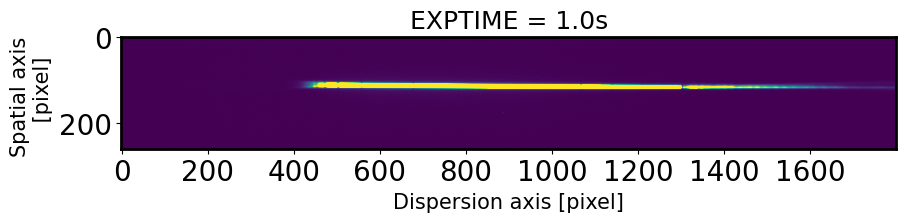

In [62]:
# 한장짜리 코드

##Bring the sample image
#
#objname = os.path.join(subpath,'M77-0002.fits')
stdname = os.path.join(subpath,'phr8634-0001.fits')
hdul = fits.open(stdname)[0]
obj = hdul.data
obj = obj[:,200:2000]
header = hdul.header
EXPTIME = header['EXPTIME']
fig,ax = plt.subplots(1,1,figsize=(10,15))
ax.imshow(obj,vmin=0,vmax=2000)
ax.set_title('EXPTIME = {0}s'.format(EXPTIME))
ax.set_xlabel('Dispersion axis [pixel]')
ax.set_ylabel('Spatial axis \n [pixel]')
plt.show()

[[113]]


<ipython-input-63-784b41353384>:19: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(apall_1, indices=True,num_peaks=10,


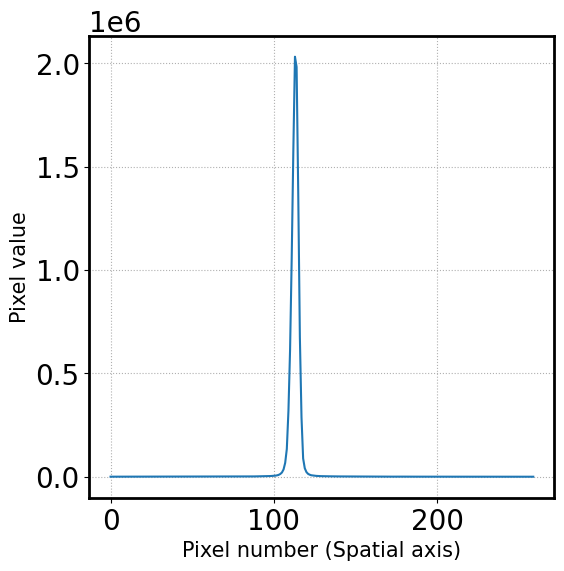

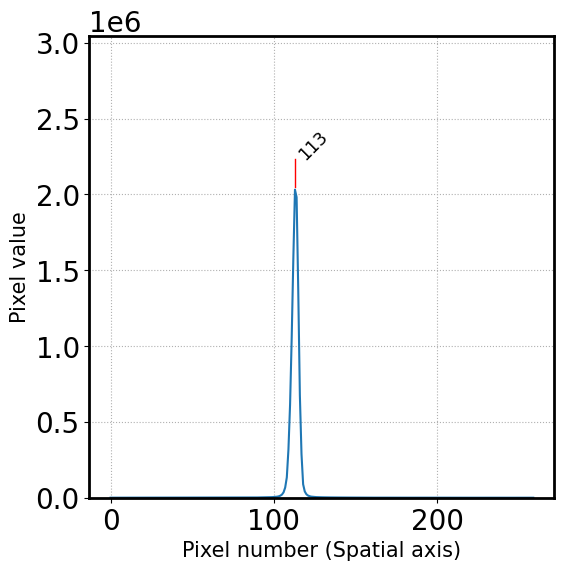

Pixel coordinatate in spatial direction = 113


In [63]:
#Let's find the peak

#Plot the spectrum along the spatial direction



lower_cut = 700
upper_cut = 750 # 이건 중심이 찍히는 곳의 픽셀값을 임의로 잡아서 50픽셀 간격으로 설정
apall_1 = np.sum(obj[:,lower_cut:upper_cut],axis=1)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(apall_1)
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.grid(ls=':')

#Find the peak

peak_pix = peak_local_max(apall_1, indices=True,num_peaks=10,
                          min_distance = 30,
                          threshold_abs=np.median(apall_1))
print(peak_pix)

fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.arange(0, len(apall_1))
ax.plot(x,apall_1)
ax.set_xlabel('Spatial axis')

peak = []
for i in peak_pix:
    ax.plot((i, i), 
            (apall_1[i]+0.01*max(apall_1),apall_1[i]+0.1*max(apall_1)),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i[0], apall_1[i][0]+0.1*max(apall_1)),
            fontsize='small', rotation=45)
    peak.append(apall_1[i])

order = peak.index(max(peak))
pix_peak = peak_pix[order] 

ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, apall_1[pix_peak]*1.5)

plt.show()

print('Pixel coordinatate in spatial direction = {0}'.format(pix_peak[0]))

Peak pixel is 113 pix
ap_sky =  [ 33  73 153 193]
x_sky =  [ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192]
sky_val =  [384. 299. 448. 439. 463. 511. 409. 490. 423. 415. 411. 484. 489. 436.
 544. 490. 373. 514. 576. 471. 557. 617. 637. 601. 610. 577. 631. 606.
 691. 635. 638. 753. 657. 818. 800. 886. 852. 772. 998. 897. 971. 906.
 852. 861. 788. 786. 775. 793. 617. 713. 671. 764. 636. 692. 604. 622.
 568. 557. 583. 507. 481. 576. 560. 583. 562. 455. 589. 509. 471. 529.
 415. 507. 455. 442. 422. 403. 396. 491. 467. 437.]
Sky area is from 33 pix ~ 73 pix and 153 pix ~ 193 pix


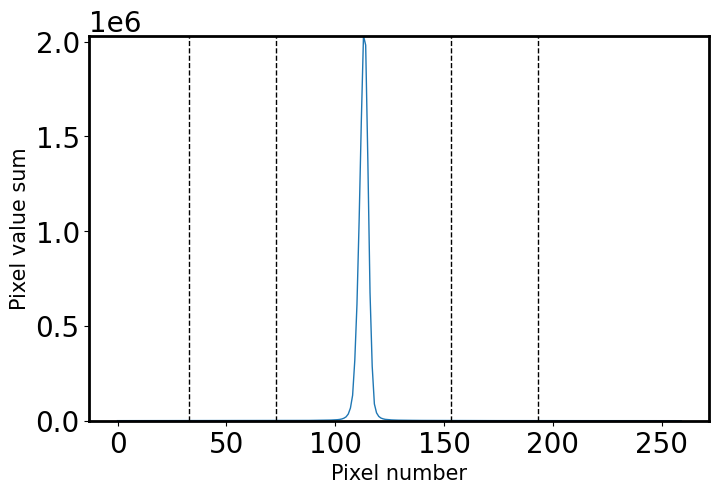

In [64]:
#select the sky area
peak = pix_peak[0] # Center
print('Peak pixel is {0} pix'.format(pix_peak[0]))

lower_limit = 40
upper_limit = 80
ap_sky = np.array([peak-upper_limit,peak-lower_limit,
                   peak+lower_limit,peak+upper_limit]) #Setting the Sky area
print('ap_sky = ',ap_sky)

x_sky = np.hstack((np.arange(ap_sky[0], ap_sky[1]), 
                   np.arange(ap_sky[2], ap_sky[3])))  #Bring the 
print('x_sky = ',x_sky)

sky_val = np.hstack((apall_1[ap_sky[0]:ap_sky[1]], 
                     apall_1[ap_sky[2]:ap_sky[3]]))
print('sky_val = ',sky_val)

print('Sky area is from {0} pix ~ {1} pix \
and {2} pix ~ {3} pix'.format(ap_sky[0], ap_sky[1], ap_sky[2], ap_sky[3]))


#Plot the sky area
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.plot(x, apall_1, lw=1)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]

ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*1)
plt.show()

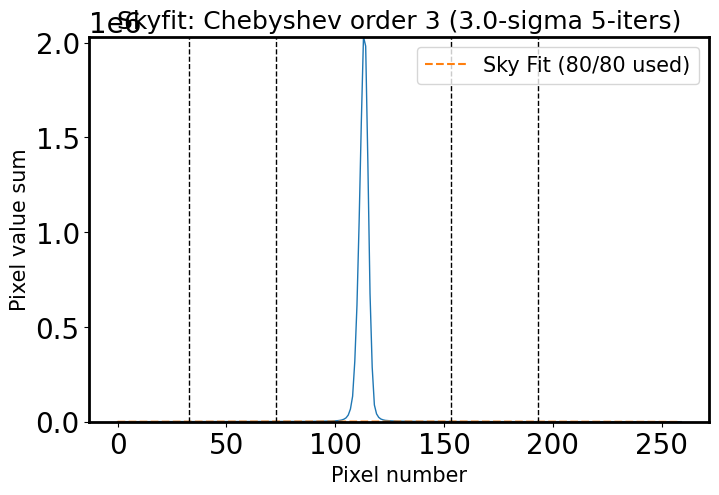

In [65]:
#Sigma Clipping
Sigma = 3
clip_mask = sigma_clip(sky_val,
                       sigma= Sigma,
                       maxiters= 5).mask

#Fit the sky
ORDER_APSKY = 3
coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
                               sky_val[~clip_mask],
                               deg=ORDER_APSKY,
                               full=True)
sky_fit = chebval(x, coeff_apsky) 

#Calculate the RMS of Fit
residual = fitfull[0][0] 
fitRMS = np.sqrt(residual/len(x_sky[~clip_mask]))


n_sky = len(x_sky)
n_rej = np.count_nonzero(clip_mask)

#Plot the sky area & fitted sky
fig,ax = plt.subplots(1,1,figsize=(8, 5))

ax.plot(x, apall_1, lw=1)
ax.plot(x, sky_fit, ls='--',
        label='Sky Fit ({:d}/{:d} used)'.format(n_sky - n_rej, n_sky))
ax.plot(x_sky[clip_mask], sky_val[clip_mask], marker='x', ls='', ms=10)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]


title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*1)
ax.legend()
ax.set_title(title_str.format('Chebyshev', ORDER_APSKY,
                              Sigma, 5))
plt.show()

Center pix of Peak is 113.21 with FWHM 4.66


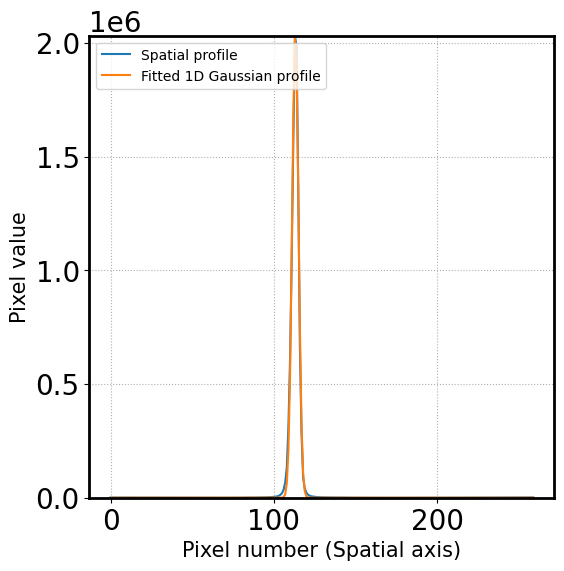

In [66]:
#Finding the peak center by fitting the gaussian 1D function again

sub_apall_1 = apall_1 - sky_fit #Profile - sky 

g_init = Gaussian1D(amplitude=sub_apall_1[pix_peak], 
                    mean = pix_peak,
                    stddev = 15* gaussian_fwhm_to_sigma)

fitter = LevMarLSQFitter()
fitted = fitter(g_init, x, sub_apall_1) # 이 코드 잘못됨 슬랙참고
center_pix = fitted.mean.value
std = fitted.stddev.value
FWHM_AP = fitted.fwhm
print('Center pix of Peak is {0:.2f} with FWHM {1:.2f}'.format(center_pix, FWHM_AP))


#Plot the image 
fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.arange(0, len(apall_1))
ax.plot(x,sub_apall_1, label='Spatial profile')

re_g_init = Gaussian1D(amplitude=fitted.amplitude.value, 
                       mean = center_pix,
                       stddev = std)
ax.plot(x,re_g_init(x), label='Fitted 1D Gaussian profile')
ax.set_xlabel('Spatial axis')

ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, apall_1[pix_peak])
ax.legend(loc=2,fontsize=10)

plt.show()

In [67]:
#Trace the Aperture (Peak) along the wavelength
#Repeat the above process for all wavelength bands.
aptrace = []
aptrace_fwhm = []
STEP_AP = 10  
N_AP = len(obj[0])//STEP_AP
FWHM_AP = 10
peak = center_pix
for i in range(N_AP - 1):
    lower_cut, upper_cut = i*STEP_AP, (i+1)*STEP_AP
    apall_i = np.sum(obj[:, lower_cut:upper_cut], axis=1)
    sky_val = np.hstack( (apall_i[ap_sky[0]:ap_sky[1]], 
                          apall_i[ap_sky[2]:ap_sky[3]]) )
    clip_mask = sigma_clip(sky_val,
                           sigma=3,
                           maxiters=5).mask
    coeff, fitfull = chebfit(x_sky[~clip_mask], 
                             sky_val[~clip_mask],
                             deg=ORDER_APSKY,
                             full=True)
    apall_i -= chebval(x,coeff)  # Object profile - the fitted sky #apall_i = apall_i - chebval(x,coeff)
    
    search_min = int(peak - 3*FWHM_AP)
    search_max = int(peak + 3*FWHM_AP)
    cropped = apall_i[search_min:search_max]
    x_cropped = np.arange(len(cropped))
    
    peak_pix = peak_local_max(cropped, 
                              indices=True,
                              min_distance=FWHM_AP,
                              num_peaks=1)
 
    if len(peak_pix)==0: #만약 스펙트럼의 중심을 찾을 수 없으면
        aptrace.append(np.nan)
        aptrace_fwhm.append(0)
        continue
        
    else:
        peak_pix = peak_pix[0][0] #스펙트럼의 중심을 찾았다면

        g_init = Gaussian1D(amplitude=cropped[peak_pix], #가우시안 피팅을 해서 중심을 다시 찾자
                            mean = peak_pix,
                            stddev = FWHM_AP * gaussian_fwhm_to_sigma,
                            bounds={'amplitude':(0, 2*cropped[peak_pix]) ,
                                   'mean':(peak_pix-3*FWHM_AP, peak_pix+3*FWHM_AP),
                                   'stddev':(0.00001, FWHM_AP*gaussian_fwhm_to_sigma)})
        fitted = fitter(g_init, x_cropped, cropped)
        center_pix_new = fitted.mean.value + search_min
        aptrace_fwhm.append(fitted.fwhm)
        aptrace.append(center_pix_new)    
        
aptrace = np.array(aptrace)
aptrace_fwhm = np.array(aptrace_fwhm)          




<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_pix = peak_local_max(cropped,
<ipython-input-67-5add04460e09>:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indic

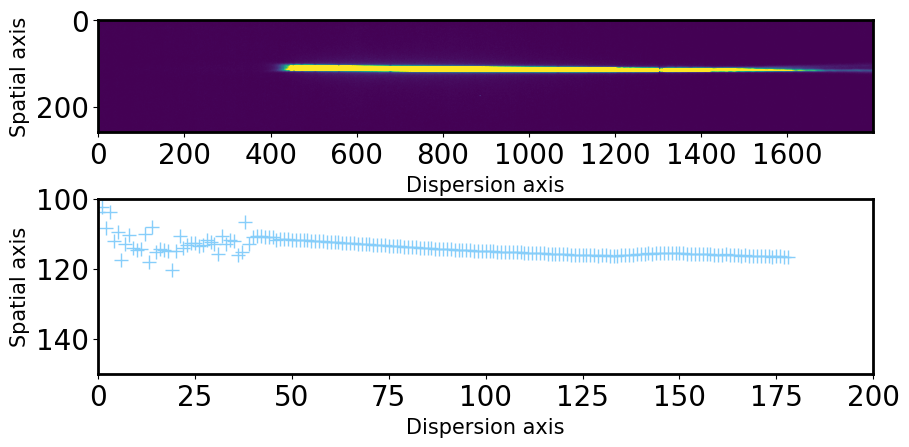

In [68]:
#Plot the center of profile peak
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].imshow(obj,vmin=0,vmax=1000)
ax[0].set_xlabel('Dispersion axis',fontsize=15)
ax[0].set_ylabel('Spatial axis',fontsize=15)

ax[1].plot(aptrace,ls='', marker='+', ms=10,color='lightskyblue')
ax[1].set_xlim(0,200)
ax[1].set_ylim(150,100) #확대해보면 찌글찌글하다
ax[1].set_xlabel('Dispersion axis',fontsize=15)
ax[1].set_ylabel('Spatial axis',fontsize=15)
plt.show()

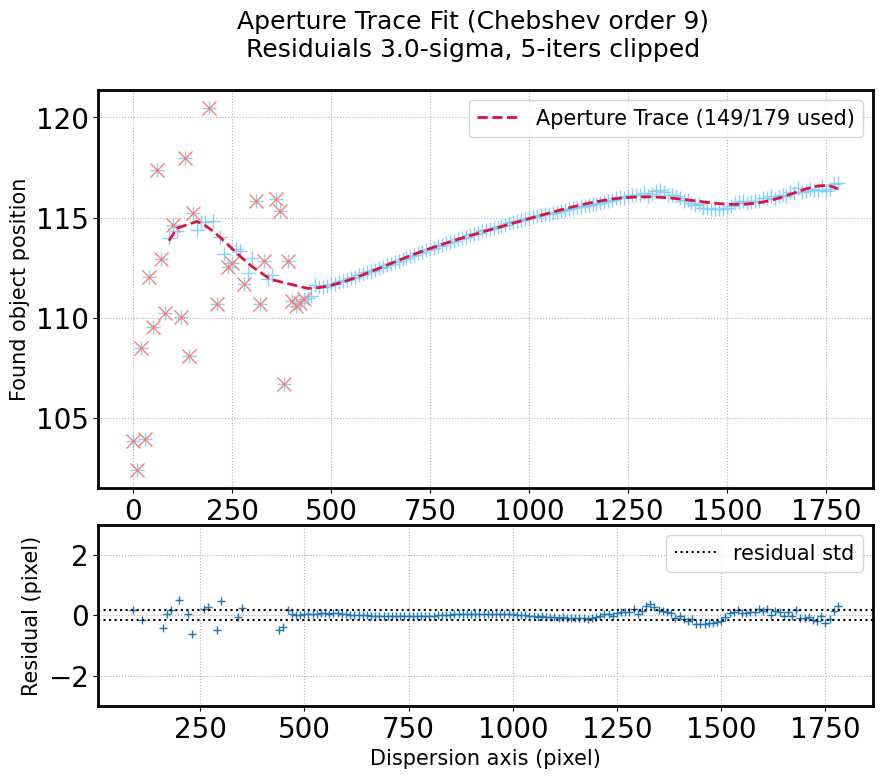

In [69]:
#Fitting the peak with Chebyshev function

ORDER_APTRACE = 9
SIGMA_APTRACE = 3
ITERS_APTRACE = 5 #When sigma_clipping

#Fitting the line
x_aptrace = np.arange(N_AP-1) * STEP_AP
coeff_aptrace = chebfit(x_aptrace, aptrace, deg=ORDER_APTRACE)

#Sigma clipping
resid_mask = sigma_clip(aptrace - chebval(x_aptrace, coeff_aptrace), 
                        sigma=SIGMA_APTRACE, maxiters=ITERS_APTRACE).mask

#Fitting the peak again after sigma clipping
x_aptrace_fin = x_aptrace[~resid_mask]
aptrace_fin = aptrace[~resid_mask]
coeff_aptrace_fin = chebfit(x_aptrace_fin, aptrace_fin, deg=ORDER_APTRACE)   

fit_aptrace_fin   = chebval(x_aptrace_fin, coeff_aptrace_fin)
resid_aptrace_fin = aptrace_fin - fit_aptrace_fin
del_aptrace = ~np.in1d(x_aptrace, x_aptrace_fin) # deleted points #x_aptrace에서 x_aptrace_fin이 없으면 True
'''
test = np.array([0, 1, 2, 5, 0])
states = [0, 2]
mask = np.in1d(test, states)
mask
array([ True, False,  True, False,  True])
'''


#Plot the Fitted line & residual
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])

ax1.plot(x_aptrace, aptrace, ls='', marker='+', ms=10,color='lightskyblue')
ax1.plot(x_aptrace_fin, fit_aptrace_fin, ls='--',color='crimson',zorder=10,lw=2,
         label="Aperture Trace ({:d}/{:d} used)".format(len(aptrace_fin), N_AP-1))
ax1.plot(x_aptrace[del_aptrace], aptrace[del_aptrace], ls='', marker='x',color='salmon', ms=10)
ax1.set_ylabel('Found object position')
ax1.grid(ls=':')
ax1.legend()


ax2.plot(x_aptrace_fin, resid_aptrace_fin, ls='', marker='+')
ax2.axhline(+np.std(resid_aptrace_fin, ddof=1), ls=':', color='k')
ax2.axhline(-np.std(resid_aptrace_fin, ddof=1), ls=':', color='k', 
            label='residual std')


ax2.set_ylabel('Residual (pixel)')
ax2.set_xlabel('Dispersion axis (pixel)')

ax2.grid(ls=':')
ax2.set_ylim(-3, 3)
ax2.legend()

#Set plot title
title_str = ('Aperture Trace Fit ({:s} order {:d})\n'
            + 'Residuials {:.1f}-sigma, {:d}-iters clipped')
plt.suptitle(title_str.format('Chebshev', ORDER_APTRACE,
                              SIGMA_APTRACE, ITERS_APTRACE))
plt.show()


In [70]:
residual_std=np.std(resid_aptrace_fin)
print(f'residual의 std는 {residual_std}')

residual의 std는 0.15757609197350678


In [71]:
#Aperture sum

apsum_sigma_lower = 3 #[Sigma]
apsum_sigma_upper = 3
ap_fwhm = np.median(aptrace_fwhm[~resid_mask]) #[pix]
ap_sigma = ap_fwhm *gaussian_fwhm_to_sigma #[pixel/sigma]
x_ap = np.arange(len(obj[0])) #Pixel along the dispersion axis
y_ap = chebval(x_ap, coeff_aptrace_fin) #Center of peak for each line
ap_sky_offset = ap_sky - pix_peak #location of sky area regarding of peak point


#Extract the spectrum along the dispersion axis
ap_summed  = []
ap_sig = []

for i in range(len(obj[0])):
    cut_i = obj[:,i] #Cut spatial direction
    peak_i = y_ap[i]
    ap_sky_i = int(peak_i) + ap_sky_offset
    
    #aperture size = apsum_sigma_lower * ap_sigma
    x_obj_lower = int(np.around(peak_i - apsum_sigma_lower * ap_sigma)) 
    x_obj_upper = int(np.around(peak_i + apsum_sigma_upper * ap_sigma))         
    x_obj = np.arange(x_obj_lower, x_obj_upper)
    obj_i = cut_i[x_obj_lower:x_obj_upper]
    


    #Fitting Sky value
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])) )
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]) )
    clip_mask = sigma_clip(sky_val, sigma= Sigma,
                           maxiters= 5).mask
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    #Subtract the sky
    sub_obj_i = obj_i - chebval(x_obj, coeff) # obj - lsky  subtraction

    
    #Calculate error
    sig_i = RN **2 + sub_obj_i \
    + chebval(x_obj,coeff)
    #RN**2 + flux_i + sky value 
    
    ap_summed.append(np.sum(sub_obj_i)) 
    ap_sig.append(np.sqrt(np.sum(sig_i)))
    
ap_summed = np.array(ap_summed)/EXPTIME    
ap_std = np.array(ap_sig) / EXPTIME    

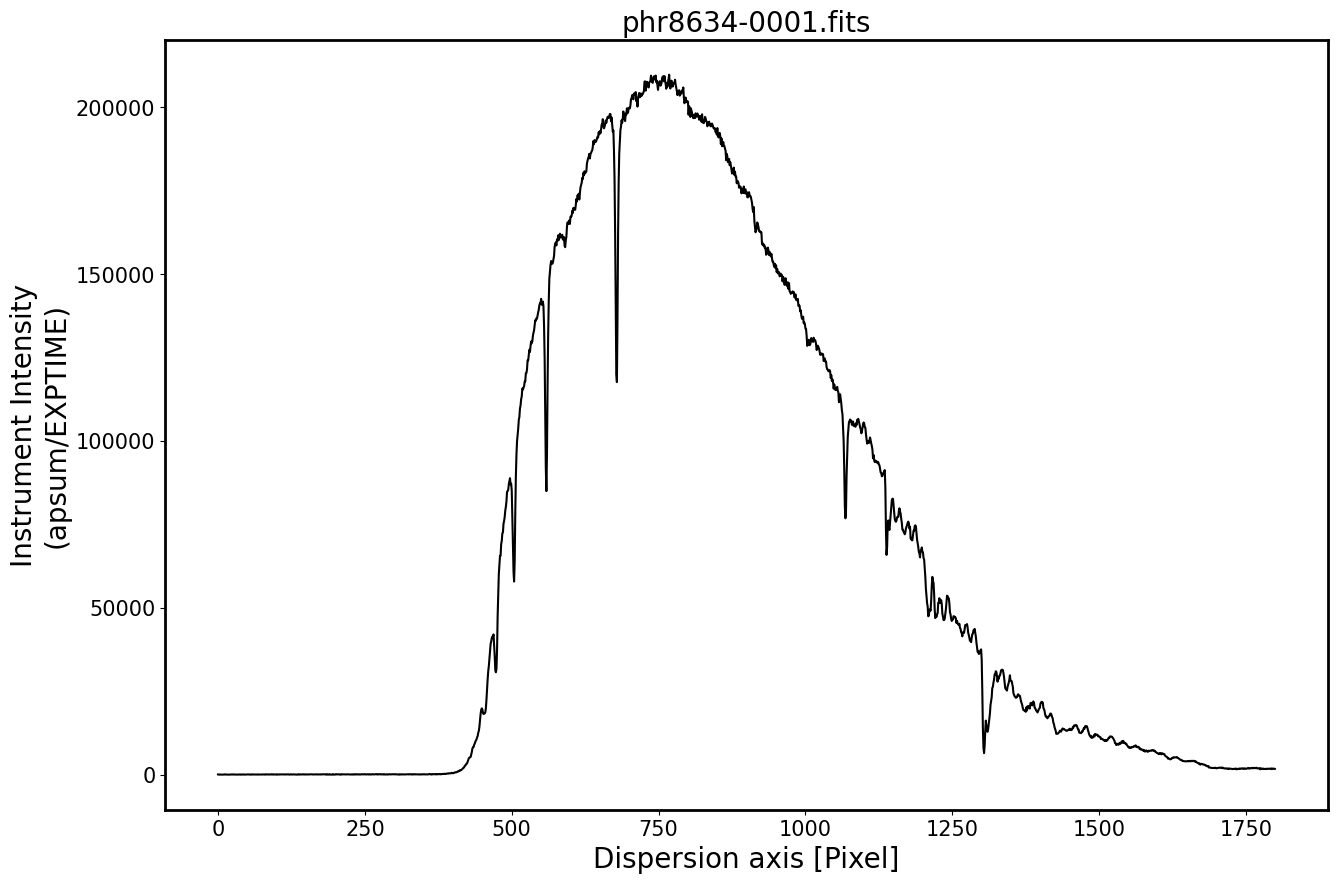

In [72]:
#Plot the spectrum 

x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(x_pix,ap_summed,color='k',alpha=1)


FILENAME = stdname.split('\\')[-1]
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis [Pixel]',fontsize=20) 
ax.tick_params(labelsize=15)
plt.show()




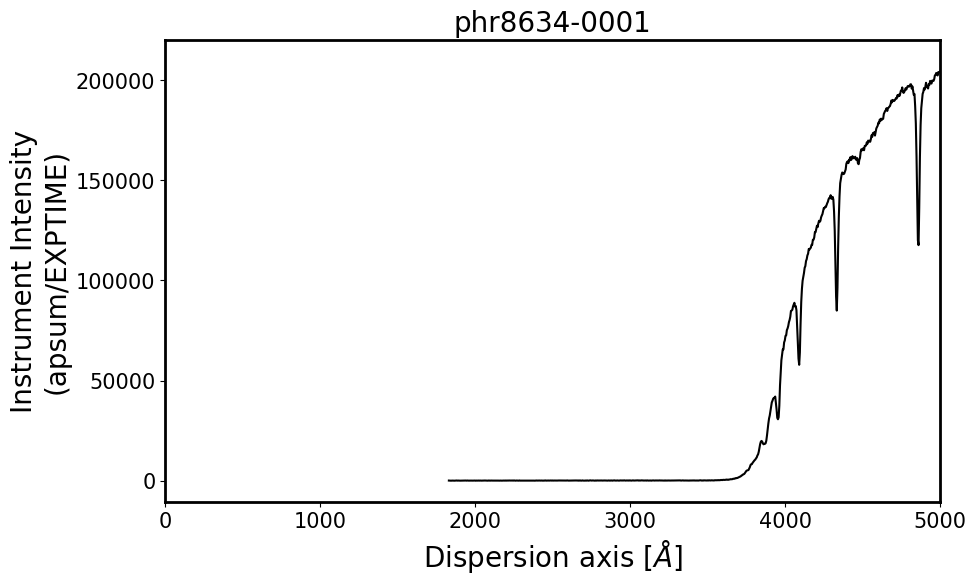

In [73]:
#Plot the spectrum respect to wavelength

Wavelength = chebval(np.arange(len(compimage[0])),coeff_ID)
Wavelength = Wavelength[200:]
x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(Wavelength,ap_summed,color='k',alpha=1)


FILENAME = stdname.split('\\')[-1].split('.')[0]
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.tick_params(labelsize=15)
ax.set_xlim(0,5000)
plt.show()



SAVE_FILENAME = os.path.join(subpath,FILENAME+'_spec.csv')

Data = [Wavelength,ap_summed,ap_std]
data = Table(Data, names=['wave','inten','std'])
data['wave'].format = "%.3f" 
data['inten'].format = "%.3f" 
data['std'].format = "%.3f" 

ascii.write(data,SAVE_FILENAME,overwrite=True,format='csv')

# 3. Flux calibration

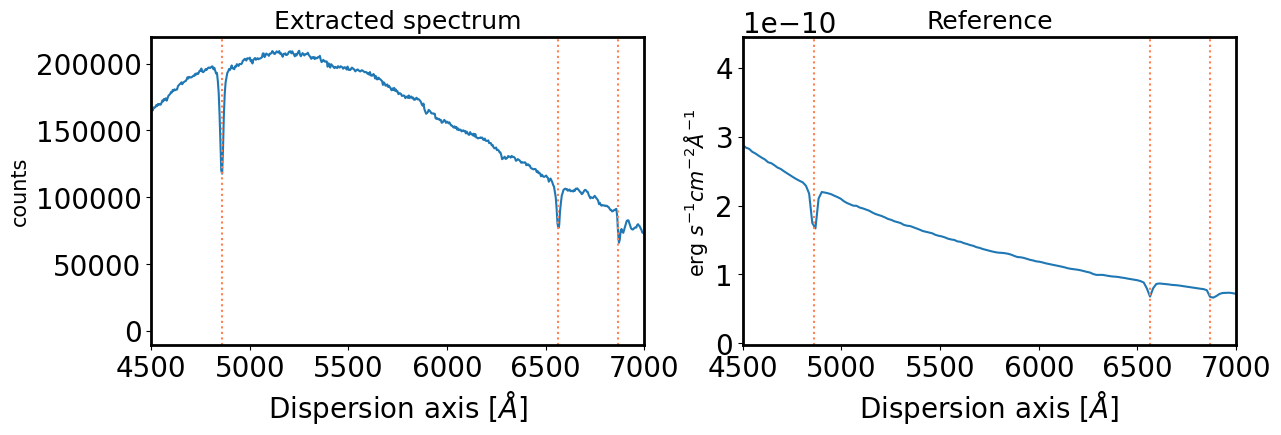

In [79]:
 def _mag2flux(wave, mag, zeropt=48.60):
    '''
    Convert magnitudes to flux units. This is important for dealing with standards
    and files from IRAF, which are stored in AB mag units. To be clear, this converts
    to "PHOTFLAM" units in IRAF-speak. Assumes the common flux zeropoint used in IRAF

    Parameters
    ----------
    wave : 1d numpy array
        The wavelength of the data points
    mag : 1d numpy array
        The magnitudes of the data
    zeropt : float, optional
        Conversion factor for mag->flux. (Default is 48.60)

    Returns
    -------
    Flux values!
    '''

    c = 2.99792458e18 # speed of light, in A/s
    flux = 10.0**( (mag + zeropt) / (-2.5) )
    return flux * (c / wave**2.0)

import urllib.request
target='https://ftp.eso.org/pub/usg/standards/ctiostan/mhr8634.dat'
urllib.request.urlretrieve(target,'mhr8634.dat')
fn='mhr8634.dat'
std_wave, std_mag, std_wth=np.loadtxt(fn,unpack=True,usecols=[0,1,2])
std_flux = _mag2flux(std_wave,std_mag)


obj = ascii.read(os.path.join(subpath,'phr8634-0001_spec.csv'))
obj_wave = obj['wave']
obj_flux = obj['inten']

'''
stdfile = os.path.join(subpath,'hr8634.csv')
stddata = ascii.read(stdfile)
std_wave, std_mag, std_wth  = stddata['wave'],stddata['mag'],stddata['width']
std_flux = _mag2flux(std_wave,std_mag)
'''



fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(obj_wave,obj_flux)
ax[0].set_xlim(4500,7000)
ax[0].set_title('Extracted spectrum')
ax[0].set_ylabel(r'counts')
ax[0].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[1].plot(std_wave,std_flux)
ax[1].set_xlim(4500,7000)
ax[1].set_title('Reference')
ax[1].set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax[1].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 


balmer = np.array([6563, 4861, 4341,4100,6867,7593.7], dtype='float')
for i in balmer:
    ax[0].axvline(i,color='coral',ls=':')
    ax[1].axvline(i,color='coral',ls=':')
plt.show()

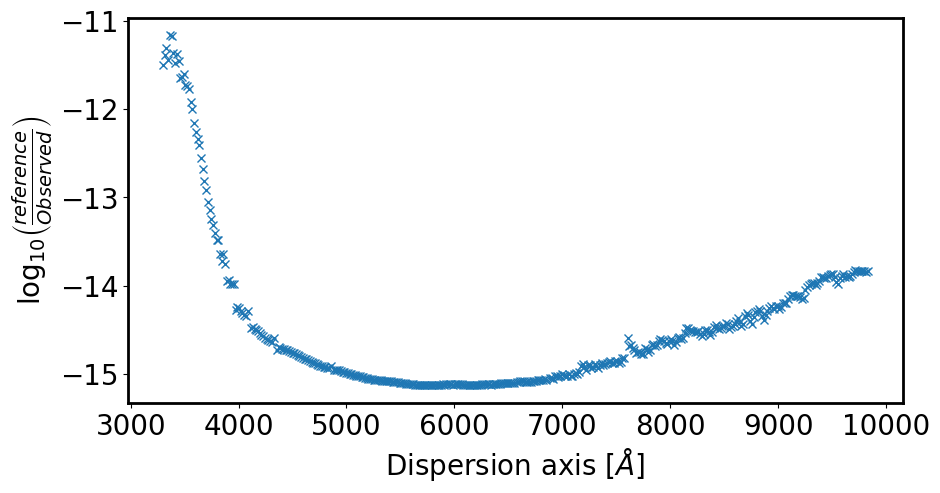

In [80]:
from scipy.interpolate import UnivariateSpline



obj_flux_ds = []
obj_wave_ds = []
std_flux_ds = []

for i in range(len(std_wave)):
    rng = np.where( (obj_wave >= std_wave[i] - std_wth[i] / 2.0) &
                           (obj_wave < std_wave[i] + std_wth[i] / 2.0)) #STD-wave 범위 안에 들어가는 obj_wave

    IsH = np.where((balmer >= std_wave[i] - std_wth[i] / 2.0) &
                           (balmer < std_wave[i] + std_wth[i] / 2.0))
    
    if (len(rng[0]) > 1) and (len(IsH[0]) == 0): 
        # does this bin contain observed spectra, and no Balmer line?
        # obj_flux_ds.append(np.sum(obj_flux[rng]) / std_wth[i])
        obj_flux_ds.append( np.nanmean(obj_flux[rng]) )
        obj_wave_ds.append(std_wave[i])
        std_flux_ds.append(std_flux[i])
        
ratio = np.abs(np.array(std_flux_ds, dtype='float') /
                       np.array(obj_flux_ds, dtype='float'))
LogSensfunc = np.log10(ratio)


fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(obj_wave_ds,LogSensfunc,marker='x',ls='')
#ax.set_xlim(4500,8000)
#ax.set_ylim(-16,-13)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylabel(r'$\log_{10} \left( \frac{reference}{Observed} \right)$',fontsize=20) 
plt.show()

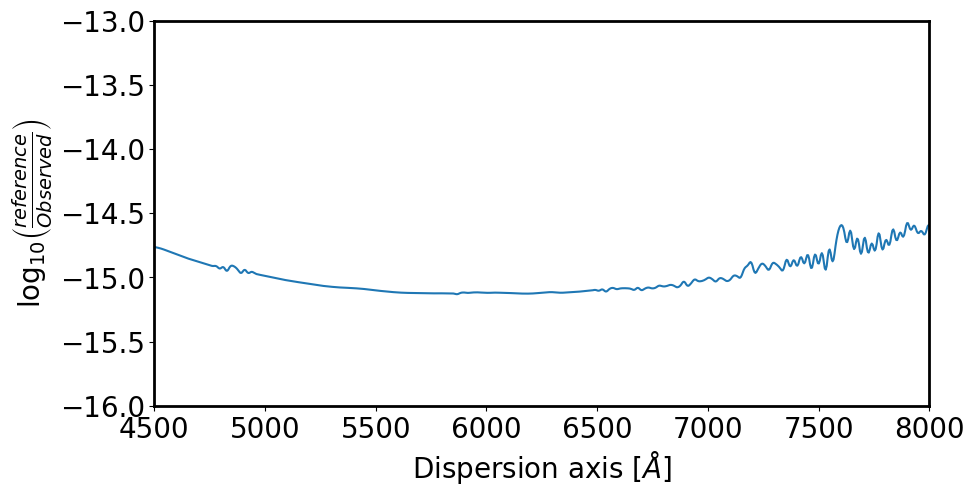

In [81]:
# interpolate back on to observed wavelength grid
spl = UnivariateSpline(obj_wave_ds, LogSensfunc, ext=0, k=2 ,s=0.0025)
sensfunc2 = spl(obj_wave)

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(obj_wave,sensfunc2)
ax.set_xlim(4500,8000)
ax.set_ylim(-16,-13)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylabel(r'$\log_{10} \left( \frac{reference}{Observed} \right)$',fontsize=20)
plt.show()

<ipython-input-82-74ec3e090ce4>:1: RuntimeWarning: overflow encountered in power
  sensfunc = 10**sensfunc2
<ipython-input-82-74ec3e090ce4>:2: RuntimeWarning: overflow encountered in multiply
  obj_cal = obj_flux*sensfunc #flux after flux calibration
<ipython-input-82-74ec3e090ce4>:2: RuntimeWarning: invalid value encountered in multiply
  obj_cal = obj_flux*sensfunc #flux after flux calibration


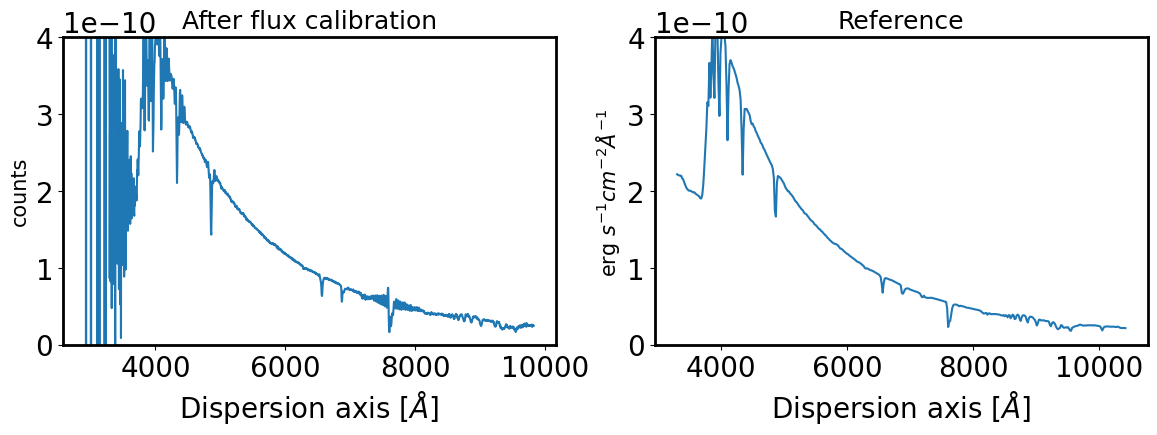

In [82]:
sensfunc = 10**sensfunc2
obj_cal = obj_flux*sensfunc #flux after flux calibration

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(obj_wave,obj_cal)
#ax[0].set_xlim(4500,8000)
ax[0].set_title('After flux calibration')
ax[0].set_ylabel(r'counts')
ax[0].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[0].set_ylim(0,8*10**(-10.3))
ax[1].plot(std_wave,std_flux)
#ax[1].set_xlim(4500,8000)
ax[1].set_title('Reference')
ax[1].set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax[1].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[1].set_ylim(0,8*10**(-10.3))
plt.show()

In [83]:
Data = [ap_summed,  ap_std]

data = Table(Data, names=['inten','std'])
data['inten'].format = "%.3f" 
data['std'].format = "%.3f" 

SAVEFILE = os.path.join(subpath,'Spectrum.csv')
ascii.write(data,SAVEFILE,overwrite=True,format='csv')

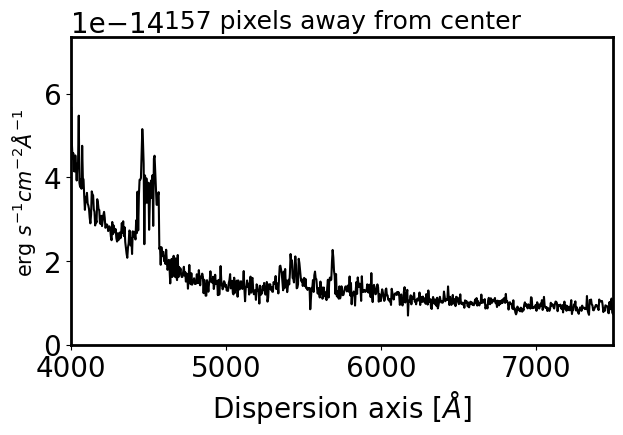

In [100]:
#for i in range(len(Ap_summed)):
fig, ax = plt.subplots(1,1,figsize=(7,4))
#for n,i in enumerate([10,11]) :
tar = ascii.read(os.path.join(Sciencepath,f'pM74-0001_spec_0pixels.csv'))
tar_wave = tar['wave']
tar_flux = tar['inten']
tar_std = tar['std']
idx = np.where((tar_wave>4000) & (tar_wave<7500))
tar_wave = tar_wave[idx]
tar_flux = tar_flux[idx]
tar_std = tar_std[idx]
sensfunct=sensfunc[idx]
tar_cal = tar_flux*sensfunct #flux after flux calibration
tar_std = tar_std*sensfunct

Data = [tar_wave,tar_cal,tar_std]
data = Table(Data, names = ['wave','flux','std'])
data['flux'].format = "%.2e"
data['std'].format = "%.2e"
SAVEFILE = os.path.join(Sciencepath,f'pM74-0001_spec_fcal_0pixels.csv')
ascii.write(data,SAVEFILE,overwrite=True,format='csv')

idx = np.where((tar_wave>3500) & (tar_wave<7500))
tar_wave = tar_wave[idx]
tar_cal = tar_cal[idx]


#fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(tar_wave,tar_cal,color='black')
ax.set_xlim(4000,7500)
ax.set_title(f'{i} pixels away from center')
ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylim(0,np.max(tar_cal)*1.3)   
plt.show()

# Science!!!!

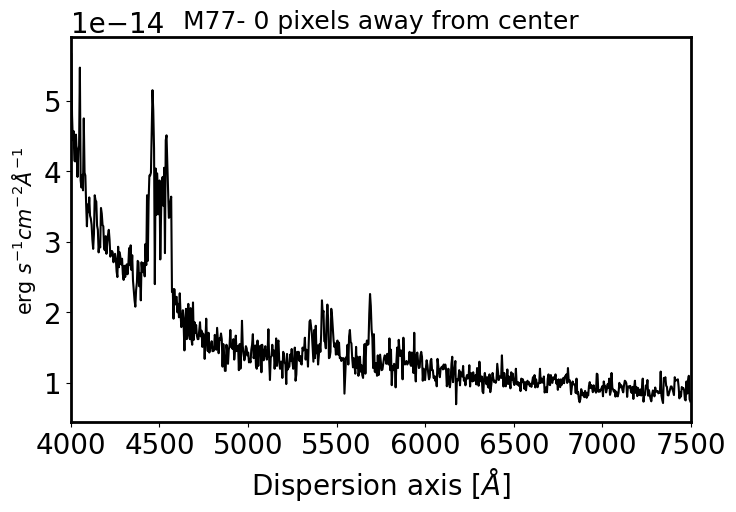

In [96]:
tar = ascii.read(os.path.join(Sciencepath,f'pM74-0001_spec_fcal_0pixels.csv'))
wave = tar['wave']
idx = np.where((wave>4000) & (wave<7500))
wave = wave[idx]
flux = tar['flux']
flux=flux[idx]
std = tar['std']
std=std[idx]


### 0III 4363 찾기
#idx2 = np.where((wave>4000) & (wave<4500))
#wave = wave[idx2]
#flux = flux[idx2]
#std = std[idx2]

###



#find peak
coordinates = peak_local_max(flux, min_distance=2,
                         threshold_abs= max(flux)*0.11)
coordinatest = []
for i in np.arange(len(coordinates)) :
    coordinatest.append(coordinates[i][0])
coordinates = coordinatest
coordinates = sorted(coordinates)

elements = ['$H_β$','[OIII]','[OIII]','$H_{α}$+[NII]','[SII]']
##


fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(wave,flux,'black')
ax.set_xlim(4000,7500)


#for n,i in enumerate(coordinates) :
#    plt.annotate(str(wave[i])+' '+elements[n], xy=(wave[i],flux[i]), xytext=(wave[i],flux[i]+0.2*1e-13),
#                fontsize=14, ha='center',
#                arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
    
#for n,i in enumerate(coordinates) :
#    plt.annotate(str(wave[i]), xy=(wave[i],flux[i]), xytext=(wave[i],flux[i]+0.2*1e-14),
#            fontsize=14, ha='center',
#            arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
#plt.annotate('4249.013 OIII', xy=(wave[49],flux[49]), xytext=(wave[49],flux[49]+0.2*1e-13),fontsize=14,ha='center',
#            arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
#plt.annotate('4372.935 OIII', xy=(wave[60],flux[60]), xytext=(wave[60],flux[60]+0.2*1e-13),fontsize=14,ha='center',
#            arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
#ax.set_xlim(4800,)
#ax.set_ylim(0,1.2*np.max(flux))
#ax.set_ylim(0,0.3e-13)
ax.set_title('M77- 0 pixels away from center')
#plt.errorbar(wave,flux,xerr=std,linestyle='None',capsize=4,color='black')
plt.show()


In [ ]:
#import numpy as np
#from scipy.optimize import curve_fit
#import matplotlib.pyplot as plt
#
#def gauss_1(x, amp1, cen1, sigma1):
#    return amp1 * (1 / (sigma1 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))
#
#def gauss_2(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
#    """ Fitting Function"""
#    return amp1 * (1 / (sigma1 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
#           amp2 * (1 / (sigma2 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2)))
#
#
#Hafluxarr = []
#Hastdarr = []
#NIIfluxarr = []
#NIIstdarr = []
#Hbfluxarr = []
#Hbstdarr = []
#OIIIfluxarr = []
#OIIIstdarr = []
#for i in range(len(Ap_summed)-3) :
#    tar = ascii.read(os.path.join(Sciencepath,f'pM77-0002_spec_fcal_{i}pixels.csv'))
#    wave = tar['wave']
#    idx = np.where((wave>6500) & (wave<6700))
#    idx2 = np.where((wave>4800) & (wave<4940))
#    hawave = wave[idx]
#    hbwave = wave[idx2]
#    flux = tar['flux']
#    haflux=flux[idx]
#    hbflux = flux[idx2]
#    std = tar['std']
#    hastd=std[idx]
#    hbstd = std[idx2]
#    
#    pix_peak = peak_local_max(haflux, min_distance=2,threshold_abs= max(haflux)*0.11)
#    print('Peak pixel is {0} pix'.format(pix_peak[0]))
#    
#    ap_sky = np.array([0,9,31,40]) #Setting the Sky area
#    print('ap_sky = ',ap_sky)
#
#    x_sky = np.hstack((np.arange(ap_sky[0], ap_sky[1]), 
#                       np.arange(ap_sky[2], ap_sky[3])))  #Bring the 
#    print('x_sky = ',x_sky)
#
#    sky_val = np.hstack((haflux[ap_sky[0]:ap_sky[1]], 
#                         haflux[ap_sky[2]:ap_sky[3]]))
#    print('sky_val = ',sky_val)
#
#    print('Sky area is from {0} pix ~ {1} pix \
#    and {2} pix ~ {3} pix'.format(ap_sky[0], ap_sky[1], ap_sky[2], ap_sky[3]))
#    #Sigma Clipping
#    Sigma = 3
#    clip_mask = sigma_clip(sky_val,
#                           sigma= Sigma,
#                           maxiters= 5).mask
#
#    #Fit the sky
#    ORDER_APSKY = 3
#    coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
#                                   sky_val[~clip_mask],
#                                   deg=ORDER_APSKY,
#                                   full=True)
#    x = np.arange(45)
#    sky_fit = chebval(x, coeff_apsky) 
#
#    #Calculate the RMS of Fit
#    residual = fitfull[0][0] 
#    fitRMS = np.sqrt(residual/len(x_sky[~clip_mask]))
#
#
#    n_sky = len(x_sky)
#    n_rej = np.count_nonzero(clip_mask)
#
#    sub_apall_1 = haflux - sky_fit #Profile - sky 
#
#    xx = np.linspace(0,45,100)
#    x = np.linspace(0,45,45)
#    y = sub_apall_1
#
#    amp1 = haflux[23]*0.5
#    sigma1 = 1
#    cen1 = 23
#    amp2 = haflux[23]*0.5
#    sigma2 = 1
#    cen2 = 21
#
#    p0 = [amp1, cen1, sigma1, amp2, cen2, sigma2]
#    y0 = gauss_2(x, *p0)
#
#    popt, pcov = curve_fit(gauss_2, x, y, p0=p0,maxfev=10000)
#    (a,c,s) = popt.reshape(-1,3)[0]
#    NIIfluxarr.append(np.max(gauss_1(xx,a,c,s)))
#    NIIstdarr.append(4.385*s)
#    
#    (a,c,s) = popt.reshape(-1,3)[1]
#    hafluxarr.append(np.max(gauss_1(xx,a,c,s)))
#    hastdarr.append(4.385*s)
#    
#    fig, ax = plt.subplots(figsize=(14,8))
#    ax.plot(x, y, color='blue', label="given data")
#    #ax.plot(x, y0, 'g', ls=':', label="initial fit params")
#    ax.plot(xx, gauss_2(xx, *popt), ls=':', label="Fit function", linewidth=4, color='red')
#
#    (a,c,s) = popt.reshape(-1,3)[0]
#    ax.plot(xx, gauss_1(xx, a, c, s), ls='-', linewidth=1, color='green')
#    (a,c,s) = popt.reshape(-1,3)[1]
#    ax.plot(xx, gauss_1(xx, a, c, s), ls='-', linewidth=1, color='purple')
#
#    #ax.axvline(popt.reshape(-1,3)[0][1],color='black',ls=':')
#    #ax.axvline(popt.reshape(-1,3)[1][1],color='black',ls=':')
#    plt.title(f'double gaussian fitting for H$\\alpha$ & NII')
#    plt.xlabel('dispersion axis(pixel)')
#    plt.ylabel('-intensity+12000-continuum(DN)')
#    ax.legend()
#    ax.autoscale(axis='x', tight=True)
#    plt.show()

In [ ]:
#Data = [hafluxarr,hastdarr,NIIfluxarr,NIIstdarr]
#data = Table(Data, names = ['Haflux','Hastd','NIIflux','NIIstd'])
#data['Haflux'].format = "%.2e"
#data['Hastd'].format = "%.2e"
#data['NIIflux'].format = "%.2e"
#data['NIIstd'].format = "%.2e"
#SAVEFILE = os.path.join(Sciencepath,f'pM77-0002_radius_flux.csv')
#ascii.write(data,SAVEFILE,overwrite=True,format='csv')

# Reference

In [ ]:
import urllib.request
target='http://ned.ipac.caltech.edu/spc1/2006/2006ApJS..164...81M/NGC_1068_nuc:S:Opt:mk2006.txt'
urllib.request.urlretrieve(target,'mk2006.txt')
fn='mk2006.txt'
wave, mag, sky=np.loadtxt(fn,unpack=True,usecols=[0,1,2])
flux = _mag2flux(wave,mag)

fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(wave,mag,'black')
coordinates = peak_local_max(mag, min_distance=5, 
                         threshold_abs= max(mag)*0.1)
for i in coordinates :
    wave[i]
    plt.annotate(float(wave[i]), xy=(wave[i],mag[i]), xytext=(wave[i], mag[i]+0.2*1e-13),
                fontsize=14, ha='center',
                arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
#ax.set_xlim(6500,)
ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_title('reference')

plt.show()

In [ ]:
import urllib.request
target='http://ned.ipac.caltech.edu/spc1/2006/2006ApJS..164...81M/NGC_1068:S:Opt:mk2006.txt'
urllib.request.urlretrieve(target,'mk2006.txt')
fn='mk2006.txt'
wave, mag, sky=np.loadtxt(fn,unpack=True,usecols=[0,1,2])
flux = _mag2flux(wave,mag)

fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(wave,mag,'black')
coordinates = peak_local_max(mag, min_distance=5, 
                         threshold_abs= max(mag)*0.4)
for i in coordinates :
    wave[i]
    plt.annotate(float(wave[i]), xy=(wave[i],mag[i]), xytext=(wave[i], mag[i]+1*1e-13),
                fontsize=14, ha='center',
                arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
#ax.set_xlim(6500,)
ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_title('reference')
    
plt.show()

# 6748.351의 값을 이용해 속도 구하기

In [ ]:
 
# 원래 값은 6723이므로
lamm = 6748.351
lamr = 6723
z = (lamm-lamr)/lamr
c = 2.998*10**5
v = c*z
v

# r=0에서 equivalent width 구하기

In [ ]:
tar = ascii.read(os.path.join(Sciencepath,f'pM77-0002_spec_fcal_0pixels.csv'))
wave = tar['wave']
idx = np.where((wave>4000) & (wave<7500))
wave = wave[idx]
flux = tar['flux']
flux=flux[idx]
std = tar['std']
std=std[idx]

idx2 = np.where((wave>5500) & (wave<6000))
continuum = flux[idx2]
mean = np.mean(continuum)
mean
print(f'continuum의 세기는 {mean}')
print(f'H_alpha는 6525~6650, Oiii는 4900~5050, Hb는 4775~4875 Sii는 6700~6800, OIII4363은 4278.896' )
## plotting
coordinates = peak_local_max(flux, min_distance=5, 
                         threshold_abs= max(flux))
coordinatest = []
for i in np.arange(len(coordinates)) :
    coordinatest.append(coordinates[i][0])
coordinates = coordinatest
coordinates = sorted(coordinates)

elements = ['$H_β$','[OIII]','[OIII]','$H_{α}$+[NII]','SII']
##


fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(wave,flux,'black')


for n,i in enumerate(coordinates) :
    plt.annotate(str(wave[i]), xy=(wave[i],flux[i]), xytext=(wave[i],flux[i]+0.2*1e-13),
                fontsize=14, ha='center',
                arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))

ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_xlim(4000,7500)
ax.set_ylim(0*1e-13,max(flux)*1.3)
ax.set_title('M77')
#plt.errorbar(wave,flux,xerr=std,linestyle='None',capsize=4,color='black')
ax.axhline(mean,color='red',ls='--')
plt.show()

In [ ]:
def Haint(hawave,haflux) :
    summ = 0 
    for i in range(len(hawave)-1) :
        delx = hawave[i+1]-hawave[i]
        y = haflux[i]
        summ += delx*y
    return summ

def Hbint(hbwave,hbflux) :
    summ = 0 
    for i in range(len(hbwave)-1) :
        delx = hbwave[i+1]-hbwave[i]
        y = hbflux[i]
        summ += delx*y
    return summ

def O3int(O3wave,O3flux) :
    summ = 0 
    for i in range(len(O3wave)-1) :
        delx = O3wave[i+1]-O3wave[i]
        y = O3flux[i]
        summ += delx*y
    return summ

def S2int(S2wave,S2flux) :
    summ = 0 
    for i in range(len(S2wave)-1) :
        delx = S2wave[i+1]-S2wave[i]
        y = S2flux[i]
        summ += delx*y
    return summ

Haarr = []
Hbarr = []
S2arr = []
O3arr = []


for i in range(len(Ap_summed)-2) :

    tar = ascii.read(os.path.join(Sciencepath,f'pM77-0002_spec_fcal_{i}pixels.csv'))
    wave = tar['wave']
    idx = np.where((wave>4000) & (wave<7500))
    wave = wave[idx]
    flux = tar['flux']
    flux=flux[idx]
    std = tar['std']
    std=std[idx]
    
    idx2 = np.where((wave>5500) & (wave<6000))
    continuum = flux[idx2]
    mean = np.mean(continuum)
    
    haidx = np.where((wave>6525) &(wave<6650))
    hawave = wave[haidx]
    haflux = flux[haidx]

    hbidx = np.where((wave>4775) &(wave<4875))
    hbwave = wave[hbidx]
    hbflux = flux[hbidx]

    O3idx = np.where((wave>4900) &(wave<5050))
    O3wave = wave[O3idx]
    O3flux = flux[O3idx]

    S2idx = np.where((wave>6700) &(wave<6800))
    S2wave = wave[S2idx]
    S2flux = flux[S2idx]
    
    Hafluxx = Haint(hawave,haflux-mean)
    Hbfluxx = Hbint(hbwave,hbflux-mean)
    O3fluxx = O3int(O3wave,O3flux-mean)
    S2fluxx = S2int(S2wave,S2flux-mean)
    Haarr.append(Hafluxx/(max(haflux)-mean))
    Hbarr.append(Hbfluxx/(max(hbflux)-mean))
    S2arr.append(S2fluxx/(max(S2flux)-mean))
    O3arr.append(O3fluxx/(max(O3flux)-mean))
                

In [ ]:
x = range(11)
plt.plot(x,Haarr,'o--',label='Ha')
plt.plot(x,Hbarr,'o--',label='Hb')
plt.plot(x,O3arr,'o--',label='O3')
plt.plot(x,S2arr,'o--',label='S2')
#plt.xscale('log')
#plt.plot(S2arr,'o--')
plt.legend()
#plt.ylim(0,1000)
plt.xlabel('radius(pixel)')
plt.ylabel('equivalent width')
plt.show()

# metalicity

# continuum 빼주기

In [ ]:

for k in range(len(Ap_summed)-1) :
    tar = ascii.read(os.path.join(Sciencepath,f'pM77-0002_spec_fcal_{k}pixels.csv'))
    wave = tar['wave']
    idx = np.where((wave>4000) & (wave<7500))
    wave = wave[idx]
    flux = tar['flux']
    flux=flux[idx]
    std = tar['std']
    std=std[idx]

    idx2 = np.where((wave>5500) & (wave<6000))
    continuum = flux[idx2]
    mean = np.mean(continuum)
    mean
    print(f'continuum의 세기는 {mean}')
    print(f'H_alpha는 6525~6650, Oiii는 4900~5050, Hb는 4775~4875 Sii는 6700~6800, OIII4363은 4278.896' )
    ## plotting
    coordinates = peak_local_max(flux, min_distance=5, 
                             threshold_abs= max(flux)*0.1)
    coordinatest = []
    for i in np.arange(len(coordinates)) :
        coordinatest.append(coordinates[i][0])
    coordinates = coordinatest
    coordinates = sorted(coordinates)

    elements = ['$H_β$','[OIII]','[OIII]','$H_{α}$+[NII]','SII']
    ##


    fig,ax = plt.subplots(1,1,figsize=(8,5))
    ax.plot(wave,flux-mean,'black')
    ax.set_xlim(4000,7500)
    ax.set_ylim(0*1e-13,2*10**-13)
    
    #for n,i in enumerate(coordinates) :
    #    plt.annotate(str(wave[i]), xy=(wave[i],flux[i]), xytext=(wave[i],flux[i]+0.2*1e-13),
    #                fontsize=14, ha='center',
    #                arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))

    Data = [wave,flux-mean,std]
    data = Table(Data, names = ['wave','flux','std'])
    data['flux'].format = "%.2e"
    data['std'].format = "%.2e"
    SAVEFILE = os.path.join(Sciencepath,f'pM77-0002_spec_fcal_continuumx_{k}pixels.csv')
    ascii.write(data,SAVEFILE,overwrite=True,format='csv')
    ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
    ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
    
    
    #ax.set_xlim(6650,6850)
    #ax.set_ylim(0,0.5*1e-13)
    ax.set_title('M77')
    #plt.errorbar(wave,flux,xerr=std,linestyle='None',capsize=4,color='black')
    #ax.axhline(mean,color='red',ls='--')
    plt.show()

# metallicity 계산

In [ ]:
def D02(S2flux,haflux,S2std,hastd) :
    S2 = np.log10(S2flux/haflux)
    S2Harelstd = ((hastd/haflux)**2+(S2std/S2flux)**2)**0.5
    S2Hastd = S2Harelstd * S2flux/haflux
    S2err = S2Hastd/(np.log(10)*S2flux/haflux)
    logO_H = 9.12+0.73*S2
    stdO_H = S2err*0.73
    #print(S2)
    return [float(logO_H),float(stdO_H)]

def O3N2(O2flux,hbflux,S2flux,haflux,O2std,hbstd,S2std,hastd) :
    arr = [O2flux,hbflux,S2flux,haflux,O2std,hbstd,S2std,hastd]
    O2flux = float(O2flux)
    S2flux = float(S2flux)
    haflux = float(haflux)
    hbflux = float(hbflux)
    O2std = float(O2std)
    S2std = float(S2std)
    hastd = float(hastd)
    hbstd = float(hbstd)

    
    a = O2flux/hbflux
    b = S2flux/haflux
    ab = a/b
    O3N2 = np.log10(a/b)
    
    arelstd = ((O2std/O2flux)**2+(hbstd/hbflux)**2)**0.5
    brelstd = ((S2std/S2flux)**2+(hastd/haflux)**2)**0.5
    astd = arelstd * a
    bstd = brelstd * b
    abrelstd = ((astd/a)**2+(bstd/b)**2)**0.5
    abstd = abrelstd * ab
    O3N2err = abstd/(np.log(10)*ab)
    logO_H = 8.73-0.32*O3N2
    stdO_H = O3N2err*0.32
    #print('a,b,ab,O3N2,log0_H=',a,b,ab,O3N2,logO_H)
    #print('arelstd,brelstd,astd,bstd,abrelstd,abstd',arelstd,brelstd,astd,bstd,abrelstd,abstd)
    #print('O3N2,logO_H', O3N2,logO_H)
    return [logO_H,stdO_H]

def PP04(S2flux,haflux,S2std,hastd) :
    S2 = np.log10(S2flux/haflux)
    S2Ha = S2flux/haflux
    S2Harelstd = ((hastd/haflux)**2+(S2std/S2flux)**2)**0.5
    S2Hastd = S2Harelstd * S2flux/haflux
    S2err = S2Hastd/(np.log(10)*S2flux/haflux)
    logO_H = 9.37+2.03*S2+1.26*S2**2+0.32**S2**3
    dlogO_H = 2.03+2.52*S2+0.96*S2**2
    stdO_H = dlogO_H * S2err
    return [float(logO_H),float(stdO_H)]


DO2O_Harr = []
DO2stdO_Harr = []
O3N2O_Harr = []
O3N2stdO_Harr = []
PP04O_Harr = []
PP04stdO_Harr = []

for i in range(10) :
    tar = ascii.read(os.path.join(Sciencepath,f'pM77-0002_spec_fcal_continuumx_{i}pixels.csv'))
    wave = tar['wave']
    idx = np.where((wave>4000) & (wave<7500))
    wave = wave[idx]
    flux = tar['flux']
    flux=flux[idx]
    std = tar['std']
    std=std[idx]
    haidx = np.where(wave==wave[593])
    hawave = wave[haidx]
    haflux = flux[haidx]
    hastd = std[haidx]

    hbidx = np.where(wave==wave[198])
    hbwave = wave[hbidx]
    hbflux = flux[hbidx]
    hbstd = std[hbidx]

    O1idx = np.where(wave==wave[221])
    O1wave = wave[O1idx]
    O1flux = flux[O1idx]
    O1std = flux[O1idx]

    O2idx = np.where(wave==wave[232])
    O2wave = wave[O2idx]
    O2flux = flux[O2idx]
    O2std = std[O2idx]

    S2idx = np.where(wave==wave[625])
    S2wave = wave[S2idx]
    S2flux = flux[S2idx]
    S2std = std[S2idx]
    
    ##D02 method
    O_H,stdO_H = D02(S2flux,haflux,S2std,hastd)
    DO2O_Harr.append(O_H)
    DO2stdO_Harr.append(stdO_H)
    
    ##O3N2 method
    O_H,stdO_H = O3N2(O2flux,hbflux,S2flux,haflux,O2std,hbstd,S2std,hastd)
    O3N2O_Harr.append(O_H)
    O3N2stdO_Harr.append(stdO_H)
    #print(stdO_H)
    
    ##PP04 method
    O_H,stdO_H = PP04(S2flux,haflux,S2std,hastd)
    PP04O_Harr.append(O_H)
    PP04stdO_Harr.append(stdO_H)

In [ ]:
p = (np.array(DO2stdO_Harr)**2+0.034**2)**0.5
L = (np.array(O3N2stdO_Harr)**2+0.012**2)**0.5
M = (np.array(PP04stdO_Harr)**2+0.021**2)**0.5

In [ ]:
x = np.arange(10)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax1 = ax.twiny()
ax.errorbar(x,DO2O_Harr,color='red',yerr=3*p,linestyle='None',capsize=3,label='3 sigma')
ax.errorbar(x,O3N2O_Harr,color='red',yerr=3*L,linestyle='None',capsize=3)#
#plt.errorbar(x,PP04O_Harr,color='red',yerr=3*M,linestyle='None',capsize=3)
ax.plot(x,DO2O_Harr,'o',color='black',label='DO2',markersize=5)
ax.plot(x,O3N2O_Harr,'s',color='blue',label='O3N2',markersize=5)
#ax.plot(x,PP04O_Harr,'^',color='green',label='N2',markersize=5)

ax.set_xlabel('radius(pixel)')
ax.set_ylabel('12+log(O/H)')
ax1.set_xlabel('radius(ly)')


ax.legend()
#plt.title('Oxygen Abundunces of M77')
plt.show()

# 두 profile 비교분석!!

In [ ]:
DO2m = [x,DO2O_Harr,DO2stdO_Harr]
O3N2m = [x,O3N2O_Harr,O3N2stdO_Harr]

fig, ax = plt.subplots(1,1,figsize=(10,5))
sol = np.array([x,np.array(DO2O_Harr)-np.array(O3N2O_Harr),(np.array(DO2stdO_Harr)**2+np.array(O3N2stdO_Harr)**2)**0.5])
mean = np.mean(sol[1])
std = np.std(sol[1])
plt.plot(sol[0],sol[1]-mean,'o',color='black')
stdend = (sol[2]**2+std**2)**0.5
stdendmean = np.mean(stdend)
plt.errorbar(sol[0],sol[1]-mean,color='red',yerr=(sol[2]**2+std**2)**0.5,linestyle='None',capsize=3)
plt.ylim(-0.3,0.3)
plt.axhline(0,color='green',ls='-')
plt.axhline(-stdendmean,color='black',ls='--',label='1sigma')
plt.axhline(+stdendmean,color='black',ls='--')
plt.ylabel('residual(dex)')
plt.xlabel('radius(pixel)')
plt.title('(D02-O3N2) - E(D02-O3N2)')
plt.legend()
plt.show()

In [ ]:
DO2m = [x,DO2O_Harr,DO2stdO_Harr]
O3N2m = [x,O3N2O_Harr,O3N2stdO_Harr]

DO2mean = np.mean(DO2O_Harr)
DO2std = np.std(DO2O_Harr)

O3N2mean = np.mean(O3N2O_Harr)
O3N2std = np.std(O3N2O_Harr)

xarr = np.linspace(7,10,100)
g = Gaussian1D(1e-14,DO2mean,DO2std)
h = Gaussian1D(1e-14,O3N2mean,O3N2std)
plt.plot(xarr,g(xarr))
plt.plot(xarr,h(xarr))
plt.show()